# A PVLIB-Python Simulation for *Los Andes University* Photovoltaic System
Based on: [Sandia' PVPMC](https://pvpmc.sandia.gov/) and [Sandia' PVLIB-Python](https://pvlib-python.readthedocs.io/en/stable/).

By Nelson Andrés Salazar Peña (na.salazar10@uniandes.edu.co).

Reviewed by Andrés Leonardo González Mancera, Ph.D. (angonzal@uniandes.edu.co).

May, 2020.

<!--![Los%20Andes%20PV%20System.png](attachment:Los%20Andes%20PV%20System.png)-->
___
### TABLE OF CONTENTS
#### Section 1: Accesing Forecast Data
- 1.1. Introducing First the Main Modules and Supporting Features
- 1.2. Choose a Locationd and Time
- 1.3. Forecast Models from Unidata Thredds Server
- 1.4. Retrieve Data from Unidata Thredds Server Model
- 1.5. Process Data Function

#### Section 2: Cloud Cover Irradiation
- 2.1. Cloud Cover Forecast
- 2.2. Irradiance Forecast

#### Section 3: Weather Models
- 3.1. PVLIB-Python Thredds Unidata Library
- 3.2. TMY Meteorological Data
- 3.3. Meteoblue Meteorological Data

#### Section 4: Modeling Intermediates Calculus
- 4.1. Solar Position
- 4.2. Extraterrestrial DNI
- 4.3. Airmass
- 4.4. Plane of Array (POA)
- 4.5. Angle of Incidente (AOI)
- 4.6. Total POA
- 4.7. Cell and Module Temperature
- 4.8. Angle of Indicende Modifiers
- 4.9. Effective Irradiance

#### Section 5: PV Power Modeling
- 5.1. Get the Inversors Information from Multiples Databases
- 5.2. Systems' Five Parameters by Single Diode Methods Initialization

#### Section 6: PV System Outputs
- 6.1. DC Voltage
- 6.2. DC Current
- 6.3. DC Power
- 6.4. AC Power
- 6.5. DC vs. AC Power Comparison
- 6.6. Module Temperature
- 6.7. Energy

#### Section 7: Different PV System Simulation Models
- 7.1. PVLIB-Python ModelChain Initialization
- 7.2. PVSyst ModelChain Initialization
- 7.3. PVWatts Manual Initialization (with Losses)
- 7.4. PVWatts ModelChain Initialization (with Losses)
- 7.5. PVWatts ModelChain Initialization (without Losses)

#### Section 8: PV System Simulation Models Output Comparison
- 8.1. PVLIB-Python vs. Measured Data
- 8.2. All Simulation Models Comparison
- 8.3. All Simulation Models vs. Measured Data

#### Section 9: Conclusions
- 9.1. PVLIB-Python Modeling Conclusions
- 9.2. All Simulation Models Conclusions
___

___
## SECTION 1: ACCESING FORECAST DATA

### 1.1. INTRODUCING FIRST THE MAIN MODULES AND SUPPORTING FEATURES

In [1]:
# Set-up
%matplotlib inline
import matplotlib.pyplot as plt

# Built-in Python modules
import datetime
import inspect
import os
import csv

# Python add-ons
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import dates as mpl_dates

# For accessing UNIDATA THREDDS servers
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

# Sandia PVLIB-Python Module
import pvlib
from pvlib import solarposition, irradiance, atmosphere, pvsystem

# Sandia PVLIB-Python Forecasting Class
from pvlib.forecast import GFS, HRRR_ESRL, NAM, NDFD, HRRR, RAP

# Sandia PVLIB-Python Location Class
from pvlib.location import Location

# Sandia PVLIB-Python PV Power Classes
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

/Users/nelsonsasa07/opt/anaconda3/lib/python3.7/site-packages/pvlib/forecast.py:21: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The API may change, the functionality may be consolidated into an io ' +


### 1.2. CHOOSE A LOCATION AND TIME
The location selected is **Bogotá**, **Colombia** and the data retrieved is in *Decimal Coordinate*.

In [2]:
latitude = 4.6024
longitude = -74.0674
tz = 'America/Bogota' #Time Zone at Bogotá, Colombia

#start = pd.Timestamp(pd.datetime.now(), tz=tz) # Today's date
#end = start + pd.Timedelta(days=-7) # 7 days back from today

start = pd.Timestamp('2020-05-05', tz=tz) # Start of Init-May (May 05, 2020)
end = pd.Timestamp('2020-05-11', tz=tz) # End of Init-May (May 11, 2020)

print(start, end)

2020-05-05 00:00:00-05:00 2020-05-11 00:00:00-05:00


___
**Note:** In case you want to eyeball all the PVLIB-Python time zones available, run the code snipped below.

```python
import pytz

# Print all the time zones available worldwide
print(pytz.all_timezones)

# Print all the time zones available at the country you specify
country = 'CO'
print(pytz.country_timezones(country))
```

To more information visit https://pvlib-python.readthedocs.io/en/stable/timetimezones.html.
___

### 1.3. FORECAST MODELS FROM UNIDATA THREDDS SERVER

In [3]:
from pvlib.forecast import GFS, HRRR_ESRL, NAM, NDFD, HRRR, RAP 

In [4]:
# Global Forecast System (GFS) Model Selected (Defaults to 0.5 degree resolution)

fm = GFS()

### 1.4. RETRIEVE DATA FROM UNIDATA THREDDS SERVER MODEL

In [5]:
# Retrieve data from Unidata THREDDS Server model selected in the window of time specified

data = fm.get_data(latitude, longitude, start, end)
data.head();

### 1.5. PROCESS DATA FUNCTION

According to Sandia' PVLIB-Python, many of the forecast models use different names to describe the same quantity and not all variables are present in all models. For instance, on the THREDDS server, the GFS has a field named ```Total_cloud_cover_entire_atmosphere_Mixed_intervals_Average```, while the NAM has a field named ```Total_cloud_cover_entire_atmosphere_single_layer``` and a similar field in the HRRR is named ```Total_cloud_cover_entire_atmosphere```.

PVLIB-Python aims to simplify the access of the model fields relevant for solar power forecasts. Model data accessed with PVLIB-Python is returned as a pandas DataFrame with consistent column names: ```temp_air```, ```wind_speed```, ```total_clouds```, ```low_clouds```, ```mid_clouds```, ```high_clouds```, ```dni``` (Direct Normal Irradiance), ```dhi``` (Diffuse Horizontal Irradiance), ```ghi``` (Global Horizontal Irradiance).


The GFS class’s ```process_data()``` method combines these steps in a single function. In fact, each forecast model class implements its own ```process_data method``` since the data from each weather model is slightly different. The process_data functions are designed to be explicit about how the data is being processed. The forecast model classes also implement a ```get_processed_data()``` method that combines the ```get_data()``` and ```process_data()``` calls.

In [6]:
data_weatherforecast = fm.process_data(data)
data_weatherforecast.to_csv('data_weatherforecast.csv')
data_weatherforecast.head()

,temp_air,wind_speed,ghi,dni,dhi,total_clouds,low_clouds,mid_clouds,high_clouds
2020-05-05 06:00:00-05:00,9.854584,0.645949,2.452760,0.000000,2.452760,96.0,92.0,7.0,57.0
2020-05-05 09:00:00-05:00,10.250305,0.217010,256.740275,15.666338,245.474670,95.0,91.0,0.0,39.0
2020-05-05 12:00:00-05:00,11.810394,0.933612,363.802682,20.287270,343.962274,96.0,74.0,1.0,67.0
2020-05-05 15:00:00-05:00,15.871735,1.901875,234.490719,13.148068,225.586245,96.0,4.0,50.0,93.0
2020-05-05 18:00:00-05:00,18.414337,3.918862,0.004853,0.000000,0.004853,85.0,7.0,60.0,54.0


In [7]:
#Setting the Weather Data from a File Taken from Above 'Data_WeatherForecast' Values
file = '/Users/nelsonsasa07/Documents/PV Simulations/CSV Files/data_weatherforecast copia.csv'

data_weather = pd.read_csv(file)
data_weather.index = pd.to_datetime(data_weatherforecast.index, unit='s')
data_weatherforecast = pd.DataFrame(data_weather)
data_weatherforecast.head()

,Unnamed: 0,temp_air,wind_speed,ghi,dni,dhi,total_clouds,low_clouds,mid_clouds,high_clouds
2020-05-05 06:00:00-05:00,2020-05-05 06:00:00-05:00,9.854584,0.645949,2.452760,0.000000,2.452760,96.0,92.0,7.0,57.0
2020-05-05 09:00:00-05:00,2020-05-05 09:00:00-05:00,10.250305,0.217010,256.740275,15.666338,245.474670,95.0,91.0,0.0,39.0
2020-05-05 12:00:00-05:00,2020-05-05 12:00:00-05:00,11.810394,0.933612,363.802682,20.287270,343.962274,96.0,74.0,1.0,67.0
2020-05-05 15:00:00-05:00,2020-05-05 15:00:00-05:00,15.871735,1.901875,234.490719,13.148068,225.586245,96.0,4.0,50.0,93.0
2020-05-05 18:00:00-05:00,2020-05-05 18:00:00-05:00,18.414337,3.918862,0.004853,0.000000,0.004853,85.0,7.0,60.0,54.0


___

___
## SECTION 2: CLOUD COVER IRRADIATION

### 2.1. CLOUD COVER FORECAST

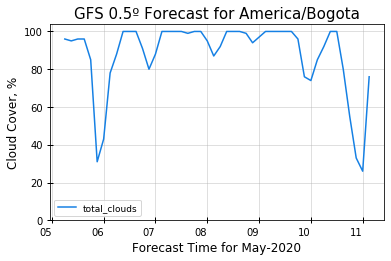

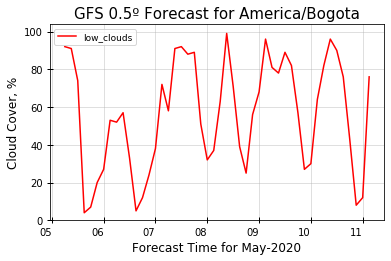

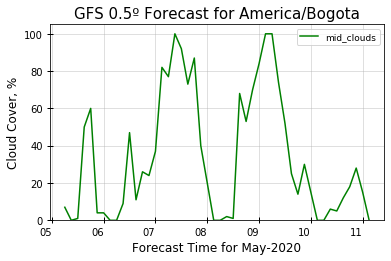

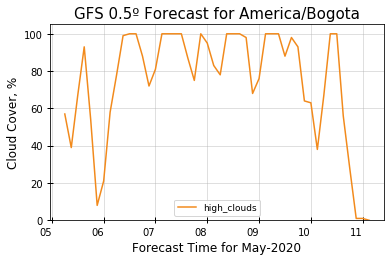

In [8]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']

plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();
ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

data_weatherforecast['total_clouds'].plot(label='total_clouds', color='#1580E4');

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Forecast for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Cloud Cover, %', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
#plt.legent(loc="upper left", bbox_to_anchor=(1,1), fontsize=9) #Legend outside the box
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Total_Clouds.eps', bbox_inches='tight')

# Figure 2
fig2, ax2 = plt.subplots();
ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

data_weatherforecast['low_clouds'].plot(label='low_clouds',color='red');

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Forecast for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Cloud Cover, %', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Low_Clouds.eps', bbox_inches='tight')

# Figure 3
fig3, ax3 = plt.subplots();
ax3.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

data_weatherforecast['mid_clouds'].plot(label='mid_clouds',color='green');

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Forecast for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Cloud Cover, %', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Mid_Clouds.eps', bbox_inches='tight')

# Figure 4
fig4, ax4 = plt.subplots();
ax4.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

data_weatherforecast['high_clouds'].plot(label='high_clouds',color='#F28A1C');

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Forecast for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Cloud Cover, %', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('High_Clouds.eps', bbox_inches='tight')

### 2.2. IRRADIANCE FORECAST

As the reader can see, the forecast models provides irradiance data. However, many of forecast models do not include radiation components in their output fields, or if they do then the radiation fields suffer from poor solar position or radiative transfer algorithms. In order to improve this setback, it is often more accurate to create empirically derived radiation forecasts from the weather models' cloud cover forecasts.

PVLIB-Python provides two basic ways to convert cloud cover forecasts to irradiance forecasts. One method assumes a linear relationship between cloud cover and GHI, applies the scaling to a clear sky climatology, and then uses the DISC model to calculate DNI. The second method assumes a linear relationship between cloud cover and atmospheric transmittance, and then uses the *Liu-Jordan* model to calculate GHI, DNI, and DHI. Clear sky scaling of climatological GHI is also used in *Larson et. al*.

**Note:** Irradiance data is compared with the satellite data from **Meteocontrol**, the photovoltaic monitoring system arranged at *Los Andes University* campus.

##### 2.2.1. Empirical Derivation of Irradiance Forecast by Larson et. al. Model

In [9]:
#Location
location = Location(latitude,longitude,tz,altitude=2624)
pressure = pvlib.atmosphere.alt2pres(altitude=2624) #Theorethical pressure is 560 mmHg (75 660.5 Pa)

# Irradiance Data
irrads_larson = fm.cloud_cover_to_irradiance(data_weatherforecast['total_clouds'], how='clearsky_scaling');
data_weatherforecast.to_csv('irrads_larson.csv')
irrads_larson.head();
diff = irrads_larson - data_weatherforecast[['ghi', 'dni', 'dhi']];
diff.head() #The irradiance forecast method by Larson et. al. is the same as the get_processed_data() function

,ghi,dni,dhi
2020-05-05 06:00:00-05:00,-1.104246e-07,0.000000,-1.104246e-07
2020-05-05 09:00:00-05:00,4.800914e-06,0.000001,3.990045e-06
2020-05-05 12:00:00-05:00,-1.637859e-05,-0.000002,-1.453207e-05
2020-05-05 15:00:00-05:00,-1.055690e-05,-0.000003,-8.780832e-06
2020-05-05 18:00:00-05:00,1.034132e-10,0.000000,1.034132e-10


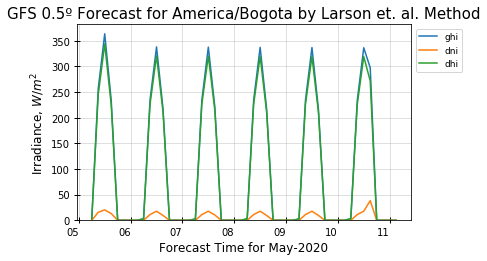

In [10]:
# Plot Irradiance Larson et. al. Method
plt.style.use('fast')

irrads_larson.plot();

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Forecast for {} by Larson et. al. Method'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Irradiance_Larson.eps', bbox_inches='tight')

##### 2.2.2. Empirical Derivation of Irradiance Forecast by Liu-Jordan Model

In [11]:
# Irradiance Data
irrads_liujordan = fm.cloud_cover_to_irradiance(data_weatherforecast['total_clouds'], how='liujordan');
data_weatherforecast.to_csv('irrads_liujordan.csv');
irrads_liujordan.head()

,ghi,dni,dhi
2020-05-05 06:00:00-05:00,22.563146,1.350672e-19,22.563146
2020-05-05 09:00:00-05:00,296.562425,1.403833e+01,286.464749
2020-05-05 12:00:00-05:00,419.105306,3.724137e+01,382.683755
2020-05-05 15:00:00-05:00,276.285039,7.632293e+00,271.114311
2020-05-05 18:00:00-05:00,1.105872,1.937082e-31,1.105872


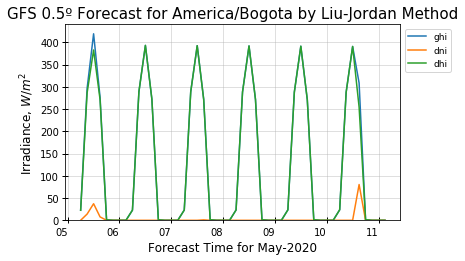

In [12]:
# Plot Irradiance Liu-Jordan Method
plt.style.use('fast')

irrads_liujordan.plot();

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Forecast for {} by Liu-Jordan Method'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Irradiance_LiuJordan.eps', bbox_inches='tight')

##### 2.2.3.1. GHI Comparison between Larson et. al. Model and Liu-Jordan Model

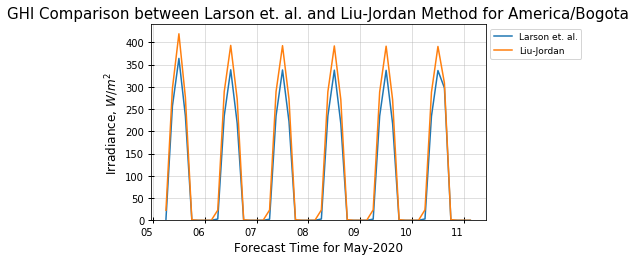

In [13]:
# GHI Comparison Plot

plt.style.use('fast')

irrads_larson['ghi'].plot(label='Larson et. al.');
irrads_liujordan['ghi'].plot(label='Liu-Jordan');

plt.rc('font', family='Helvetica')

plt.title('GHI Comparison between Larson et. al. and Liu-Jordan Method for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Irradiance_Comparison_GHI.eps', bbox_inches='tight')

In [14]:
GHI_dif = irrads_larson['ghi'] - irrads_liujordan['ghi'];
GHI_dif.head()

2020-05-05 06:00:00-05:00   -20.110386
2020-05-05 09:00:00-05:00   -39.822145
2020-05-05 12:00:00-05:00   -55.302641
2020-05-05 15:00:00-05:00   -41.794331
2020-05-05 18:00:00-05:00    -1.101020
Name: ghi, dtype: float64

##### 2.2.3.2. DNI Comparison between Larson et. al. Model and Liu-Jorsan Model

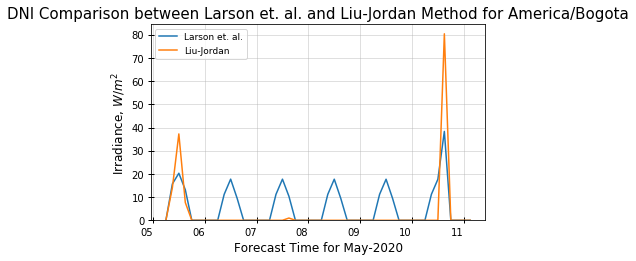

In [15]:
# DNI Comparison Plot

plt.style.use('fast')

irrads_larson['dni'].plot(label='Larson et. al.');
irrads_liujordan['dni'].plot(label='Liu-Jordan');

plt.rc('font', family='Helvetica')

plt.title('DNI Comparison between Larson et. al. and Liu-Jordan Method for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", fontsize=9);
plt.tight_layout;
plt.savefig('Irradiance_Comparison_DNI.eps', bbox_inches='tight')

In [16]:
DNI_dif = irrads_larson['dni'] - irrads_liujordan['dni'];
DNI_dif.head()

2020-05-05 06:00:00-05:00   -1.350672e-19
2020-05-05 09:00:00-05:00    1.628012e+00
2020-05-05 12:00:00-05:00   -1.695411e+01
2020-05-05 15:00:00-05:00    5.515773e+00
2020-05-05 18:00:00-05:00   -1.937082e-31
Name: dni, dtype: float64

##### 2.2.3.2. DHI Comparison between Larson et. al. Model and Liu-Jorsan Model

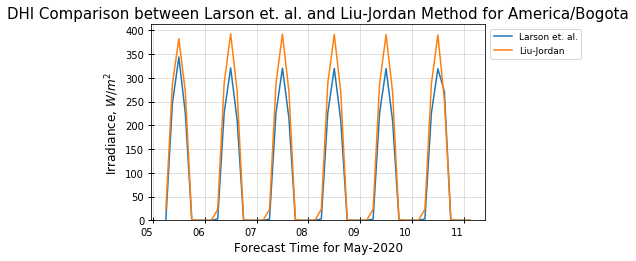

In [17]:
# DHI Comparison Plot

plt.style.use('fast')

irrads_larson['dhi'].plot(label='Larson et. al.');
irrads_liujordan['dhi'].plot(label='Liu-Jordan');

plt.rc('font', family='Helvetica')

plt.title('DHI Comparison between Larson et. al. and Liu-Jordan Method for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Irradiance_Comparison_DHI.eps', bbox_inches='tight')

In [18]:
DHI_dif = irrads_larson['dhi'] - irrads_liujordan['dhi'];
DHI_dif.head()

2020-05-05 06:00:00-05:00   -20.110386
2020-05-05 09:00:00-05:00   -40.990075
2020-05-05 12:00:00-05:00   -38.721495
2020-05-05 15:00:00-05:00   -45.528075
2020-05-05 18:00:00-05:00    -1.101020
Name: dhi, dtype: float64

##### 2.2.3.3. Interpolation Test to Improve Resolution and Precision for Irradiance Data
Most weather model output has a fairly coarse time resolution, at least an hour. The irradiance forecasts have the same time resolution as the weather data. However, it is straightforward to interpolate the cloud cover forecasts onto a higher resolution time domain, and then recalculate the irradiance.

In [19]:
resampled_data = data_weatherforecast.resample('5min').interpolate()

resampled_irrads = fm.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling') #Larson Method

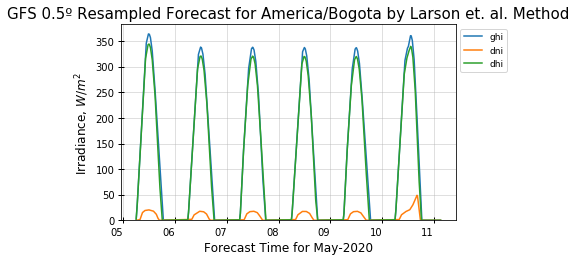

In [20]:
plt.style.use('fast')

resampled_irrads.plot();

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Resampled Forecast for {} by Larson et. al. Method'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Resampled_Irradiance_Larson.eps', bbox_inches='tight')

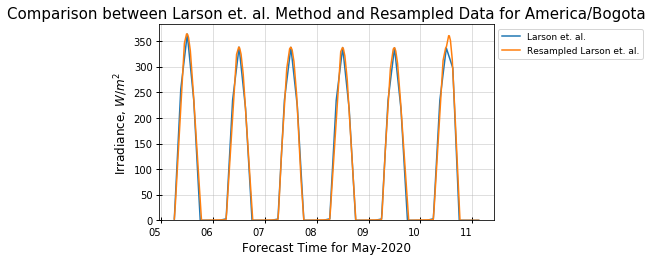

In [21]:
# Irradiance Resolution Comparison Plot

plt.style.use('fast')

irrads_larson['ghi'].plot(label='Larson et. al.');
resampled_irrads['ghi'].plot(label='Resampled Larson et. al.');

plt.rc('font', family='Helvetica')

plt.title('Comparison between Larson et. al. Method and Resampled Data for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Irradiance_Comparison_Resampled.eps', bbox_inches='tight')

___
## SECTION 3: WEATHER MODELS

### 3.1. PVLIB-PYTHON THREDDS UNIDATA LIBRARY
According to Sandia' PVLIB-Python, these are the main weatehr models availaby at the THREDDS Unidata Library.

##### 3.1.1. GFS
The Global Forecast System (GFS) is the US model that provides forecasts for the entire globe. The GFS is updated every 6 hours. The GFS is run at two resolutions, 0.25 deg and 0.5 deg, and is available with 3 hour time resolution. Forecasts from GFS model were shown above. **Use the GFS, among others, if you want forecasts for 1-7 days or if you want forecasts for anywhere on Earth**.

##### 3.1.2. HRRR
The High Resolution Rapid Refresh (HRRR) model is perhaps the most accurate model, however, it is only available for ~15 hours. It is updated every hour and runs at 3 km resolution. The HRRR excels in severe weather situations. See the NOAA ESRL HRRR page for more information. **Use the HRRR, among others, if you want forecasts for less than 24 hours. The HRRR model covers the continental United States**.

##### 3.1.3 RAP
The Rapid Refresh (RAP) model is the parent model for the HRRR. It is updated every hour and runs at 40, 20, and 13 km resolutions. Only the 20 and 40 km resolutions are currently available in PVLIB-Python. It is also excels in severe weather situations. See the NOAA ESRL HRRR page for more information. **Use the RAP, among others, if you want forecasts for less than 24 hours. The RAP model covers most of North America**.

##### 3.1.4. NAM
The North American Mesoscale model covers, not surprisingly, North America. It is updated every 6 hours. PVLIB-Python provides access to 20 km resolution NAM data with **a time horizon of up to 4 days**.

##### 3.1.5. NDFD
The National Digital Forecast Database is not a model, but rather a collection of forecasts made by National Weather Service offices across the country. It is updated every 6 hours. **Use the NDFD, among others, for forecasts at all time horizons. The NDFD is available for the United States**.

All the previous description is taken from: https://pvlib-python.readthedocs.io/en/stable/forecasts.html#weather-models.

### 3.2. TMY METEOROLOGICAL DATA

### 3.3. METEOBLUE METEOROLOGICAL DATA
___

___
## SECTION 4: MODELING INTERMEDIATES CALCULUS

Before we can calculate power for all the forecast times, we will need to calculate:

1. Solar position.
2. Extra terrestrial radiation.
3. Airmass.
4. Angle of incidence.
5. POA sky and ground diffuse radiation.
6. Cell and module temperatures.

**RELEVANT**: It is important to notice that the easiest way to obtain a time series of clear sky irradiance is to use a ```Location``` object’s ```get_clearsky()``` method. The ```get_clearsky()``` method does the dirty work of calculating **solar position**, **extraterrestrial irradiance**, **airmass**, and **atmospheric pressure**, as appropriate, leaving the user to only specify the most important parameters: **time** and **atmospheric attenuation**.

Before all, is relevant to take into account the **turbidity**. Sandia' PVLIB-Python includes a file with monthly climatological turbidity values for the globe. The code below creates turbidity maps for a few months of the year.

More info at https://pvlib-python.readthedocs.io/en/latest/clearsky.html#turbidity-data.

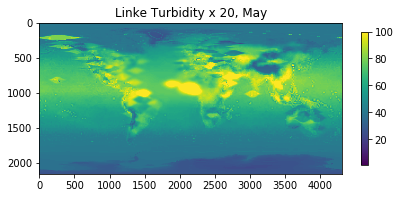

In [22]:
import calendar
import tables

pvlib_path = os.path.dirname(os.path.abspath(pvlib.clearsky.__file__));

filepath = os.path.join(pvlib_path, 'data', 'LinkeTurbidities.h5');

def plot_turbidity_map(month, vmin=1, vmax=100):
     plt.figure();
     with tables.open_file(filepath) as lt_h5_file:
         ltdata = lt_h5_file.root.LinkeTurbidity[:, :, month-1]
     plt.imshow(ltdata, vmin=vmin, vmax=vmax);
     # Data is in units of 20 x turbidity
     plt.title('Linke Turbidity x 20, ' + calendar.month_name[month]);
     plt.colorbar(shrink=0.5);
     plt.tight_layout();
 
plot_turbidity_map(5)

### 4.1. SOLAR POSITION
The default solar position algorithm is based on **Reda and Andreas (2004)**. The implementation here is pretty 'fast', but the reader can make it even faster installing ```numba``` and using the add ```method='nrel_numba'``` to the function call.

More info at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.solarposition.get_solarposition.html.

In [23]:
# Retrieve time and location parameters
time = data_weatherforecast.index;
a_point = fm.location;

solpos = a_point.get_solarposition(time);
solpos.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2020-05-05 06:00:00-05:00,86.786218,87.013648,3.213782,2.986352,73.719160,3.325464
2020-05-05 09:00:00-05:00,44.003832,44.020083,45.996168,45.979917,70.945070,3.335304
2020-05-05 12:00:00-05:00,12.044377,12.047953,77.955623,77.952047,351.853026,3.345000
2020-05-05 15:00:00-05:00,47.352948,47.371207,42.647052,42.628793,288.332404,3.354551
2020-05-05 18:00:00-05:00,89.842567,90.382592,0.157433,-0.382592,286.681924,3.363957


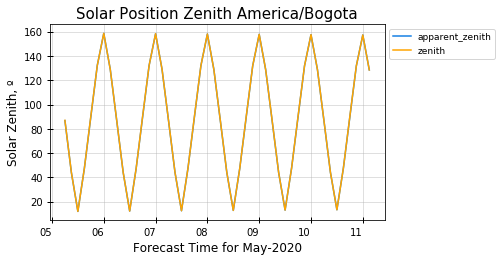

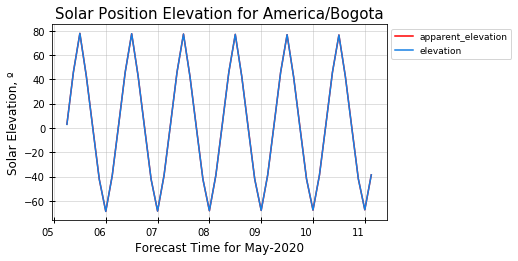

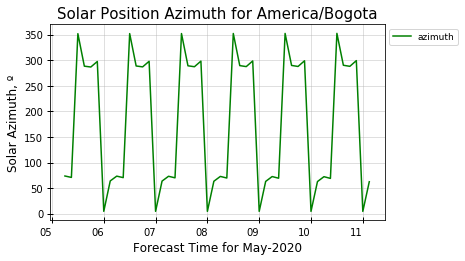

In [24]:
# Plot cloud cover percentages
solpos_vars = ['apparent_zenith', 'zenith','apparent_elevation', 'elevation', 'azimuth', 'equation_of_time']

plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();

solpos['apparent_zenith'].plot(label='apparent_zenith', color='#1580E4');
solpos['zenith'].plot(label='zenith', color='orange');

plt.rc('font', family='Helvetica')

plt.title('Solar Position Zenith {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Solar Zenith, º', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('SolPos_Zenith.eps', bbox_inches='tight')

# Figure 2
fig2, ax2 = plt.subplots();

solpos['apparent_elevation'].plot(label='apparent_elevation', color='red');
solpos['elevation'].plot(label='elevation', color='#1580E4');

plt.rc('font', family='Helvetica')

plt.title('Solar Position Elevation for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Solar Elevation, º', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('SolPos_Elevation.eps', bbox_inches='tight')

# Figure 3
fig3, ax3 = plt.subplots();

solpos['azimuth'].plot(label='azimuth', color='green');

plt.rc('font', family='Helvetica')

plt.title('Solar Position Azimuth for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Solar Azimuth, º', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax3.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('SolPos_Azimuth.eps', bbox_inches='tight')

### 4.2. EXTRATERRESTRIAL DNI

In order to determine many plane of array diffuse irradiance models, is needed to calculate the extra terrestrial radiation. To accomplish this, the ```irradiance``` class is used.

Many solar power algorithms start with the irradiance incident on the top of the Earth's atmosphere, often known as the extraterrestrial radiation. ```PVLIB-Python``` has four different algorithms to calculate the yearly cycle of the extraterrestrial radiation given the solar constant.

By default the method is **Spencer**.

##### 4.2.1. Extraterrestrial Methods Example
The user can also control the solar constant. Recent literature suggests that the solar constant is $1361 \: W/m^2$ rather than the commonly accepted $1367 \: W/m^2$.

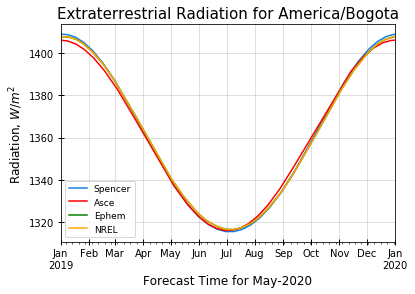

In [25]:
# Extraterrestrial Radiation Data (ETR at the code)

time = pd.date_range('2019-01-01', '2020-01-01')

etr_spencer = irradiance.get_extra_radiation(time, method='Spencer', solar_constant=1361);
etr_asce = irradiance.get_extra_radiation(time, method='Asce', solar_constant=1361);
etr_ephem = irradiance.get_extra_radiation(time, method='Pyephem', solar_constant=1361); 
etr_nrel = irradiance.get_extra_radiation(time, method='NREL', solar_constant=1361);

# Extraterrestrial Methods Example Plot
plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();

etr_spencer.plot(label='Spencer', color='#1580E4');
etr_asce.plot(label='Asce', color='red');
etr_ephem.plot(label='Ephem', color='green');
etr_nrel.plot(label='NREL', color='orange');

plt.rc('font', family='Helvetica')

plt.title('Extraterrestrial Radiation for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Radiation, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

#plt.gcf().autofmt_xdate();
#date_format = mpl_dates.DateFormatter('%m');
#plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('ETR_MethodsExample.eps', bbox_inches='tight')

**The PyEphem and NREL methods are the most accurate**. However, as shown in the plot above, the difference between them and the Spencer method is only $\pm \: 2 \: W/m^2$ over the entire year (shown below).

##### 4.2.2. Extraterrestrial for Los Andes Analysis

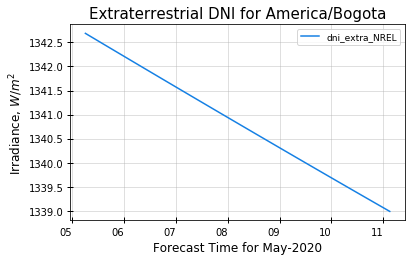

In [26]:
dni_extra = irradiance.get_extra_radiation(fm.time, method='NREL');

# Plot Extraterrestrial DNI
plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();
ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

dni_extra.plot(label='dni_extra_NREL', color='#1580E4');

plt.rc('font', family='Helvetica')

plt.title('Extraterrestrial DNI for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('SolPos_ETDNI.eps', bbox_inches='tight')

### 4.3. AIRMASS

Sandia disposes at PVLIB Atmosphere class a variety of models to get the airmass data. Some of the models are: (i.) **Simple**, (ii.) **Kasten 1966**, (iii.) **Young-Irvine 1967**, (iv.) **Kasten-Young 1989**, (v.) **Gueymard 1993**, **Young 1994** and **Pickering 2002**.

By default the model is **Kasten-Young 1989**.

More information of the model options at the Atmosphere Module Tutorial —https://nbviewer.jupyter.org/github/pvlib/pvlib-python/blob/master/docs/tutorials/atmosphere.ipynb.

##### 4.3.1. Relative Airmass

This module gives the relative (not pressure-corrected) airmass at sea-level when given a sun zenith angle (in degrees).

More info about the model at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.atmosphere.get_relative_airmass.html.

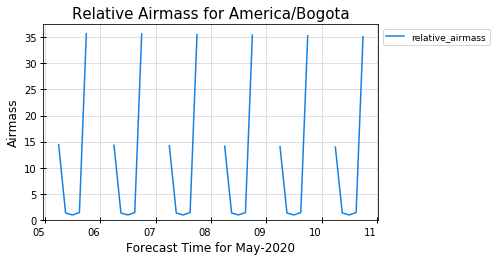

In [27]:
relative_airmass = atmosphere.get_relative_airmass(solpos['apparent_zenith'], model='kastenyoung1989');

# Plot Relative Airmass
plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();

relative_airmass.plot(label='relative_airmass', color='#1580E4');

plt.rc('font', family='Helvetica')

plt.title('Relative Airmass for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Airmass', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Relative_Airmass.eps', bbox_inches='tight')

##### 4.3.2. Absolute Airmass

This module determines absolute (pressure corrected) airmass from relative airmass and pressure.

Gives the airmass for locations not at sea-level (i.e. not at standard pressure). The input argument 'AMrelative' is the relative airmass. The input argument 'pressure' is the pressure (in Pascals) at the location of interest and must be greater than 0. The calculation for absolute airmass is:

$$ Absolute\_Airmass = Relative\_Airmass * \frac{Pressure}{101325}$$

More info about the model at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.atmosphere.get_absolute_airmass.html.

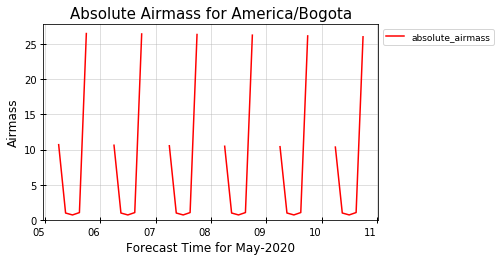

In [28]:
pressure = 75160 #Pressute at Pa according to IDEAM —(p. 26 - 27) http://www.ideam.gov.co/documents/21021/21135/CARACTERIZACION+CLIMATICA+BOGOTA.pdf/d7e42ed8-a6ef-4a62-b38f-f36f58db29aa

absolute_airmass = atmosphere.get_absolute_airmass(relative_airmass,pressure);

# Plot Absolute Airmass
plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();

absolute_airmass.plot(label='absolute_airmass', color='red');

plt.rc('font', family='Helvetica')

plt.title('Absolute Airmass for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Airmass', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Absolute_Airmass.eps', bbox_inches='tight')

##### 4.3.3. Some Others Airmass Models Example

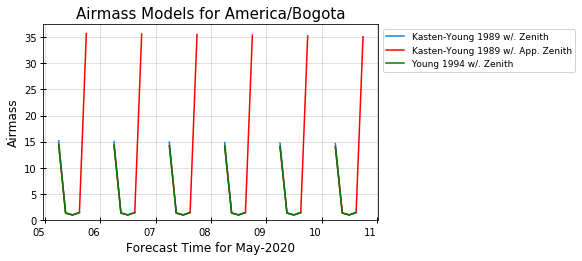

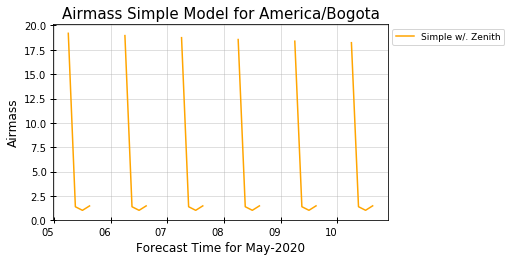

In [29]:
#Kasten-Young 1989 Model with Zenith Variable
airmass_zenith_kastenyoung = atmosphere.get_relative_airmass(solpos['zenith'])

#Kasten-Young 1989 Model with Apparent Zenith Variable
airmass_apparentzenith_kastenyoung = atmosphere.get_relative_airmass(solpos['apparent_zenith'])

#Young 1994 Model with Zenith Variable
airmass_zenith_young = atmosphere.get_relative_airmass(solpos['zenith'], model='young1994')

#Simple Model with Zenith Variable
airmass_zenith_simple = atmosphere.get_relative_airmass(solpos['zenith'], model='simple')

plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();

airmass_zenith_kastenyoung.plot(label='Kasten-Young 1989 w/. Zenith', color='#1580E4');
airmass_apparentzenith_kastenyoung.plot(label='Kasten-Young 1989 w/. App. Zenith', color='red');
airmass_zenith_young.plot(label='Young 1994 w/. Zenith', color='green');

plt.rc('font', family='Helvetica')

plt.title('Airmass Models for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Airmass', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Airmass_Models.eps', bbox_inches='tight')

# Figure 2
fig2, ax2 = plt.subplots();

airmass_zenith_simple.plot(label='Simple w/. Zenith', color='orange');

plt.rc('font', family='Helvetica')

plt.title('Airmass Simple Model for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Airmass', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Airmass_SimpleModel.eps', bbox_inches='tight')

### 4.4. PLANE OF ARRAY (POA)

Sandia disposes at PVLIB Atmosphere class a variety of models to get the airmass data. Some of the models are: (i.) **Simple**, (ii.) **Kasten 1966**, (iii.) **Young-Irvine 1967**, (iv.) **Kasten-Young 1989**, (v.) **Gueymard 1993**, **Young 1994** and **Pickering 2002**.

By default the model is **Kasten-Young 1989**.

More info at https://pvlib-python.readthedocs.io/en/stable/api.html#irradiance.

More info about the model at https://nbviewer.jupyter.org/github/pvlib/pvlib-python/blob/master/docs/tutorials/irradiance.ipynb.

##### 4.4.1. POA Sky Diffuse

Sandia disposes at PVLIB Irradiance class a variety of models to get the POA data. Some of the models are: (i.) **Perez**, (ii.) **Hay-Davies 1980**, (iii.) **Klucher-1979**, (iv.) **Reindl-1990** and (v.) **King**.

More info at https://pvlib-python.readthedocs.io/en/stable/api.html#transposition-models.

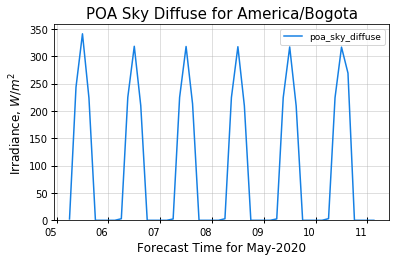

In [30]:
surface_tilt = 10;
surface_azimuth = 180; #Fixed south oriented

poa_sky_diffuse = irradiance.haydavies(surface_tilt, surface_azimuth,
                                       data_weatherforecast['dhi'], data_weatherforecast['dni'], dni_extra,
                                       solpos['apparent_zenith'], solpos['azimuth']);

# POA Sky Diffuse Plot

plt.style.use('fast')

fig1, ax1 = plt.subplots();

poa_sky_diffuse.plot(label='poa_sky_diffuse', color='#1580E4');

plt.rc('font', family='Helvetica')

plt.title('POA Sky Diffuse for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('POA_Sky_Diffuse.eps', bbox_inches='tight')

##### 4.4.2. POA Ground Diffuse

Calculate ground diffuse. We specified the albedo above. You could have also provided a string to the surface_type keyword argument.

More info at https://pvlib-python.readthedocs.io/en/stable/api.html#transposition-models.

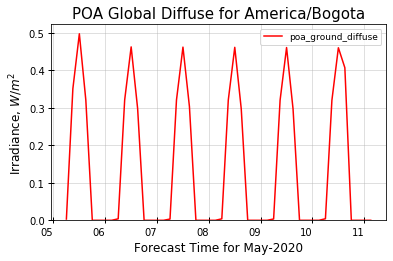

In [31]:
surface_albedo = irradiance.SURFACE_ALBEDOS['urban']; # Check the surfaces albedo list with print(irradiance.SURFACE_ALBEDOS.items()) function

poa_ground_diffuse = irradiance.get_ground_diffuse(surface_tilt, irrads_larson['ghi'], albedo=surface_albedo);

# POA Ground Diffuse Plot

plt.style.use('fast')

fig1, ax1 = plt.subplots();

poa_ground_diffuse.plot(label='poa_ground_diffuse', color='red');

plt.rc('font', family='Helvetica')

plt.title('POA Global Diffuse for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('POA_Global_Diffuse.eps', bbox_inches='tight')

### 4.5. ANGLE OF INCIDENCE (AOI)

Calculates the angle of incidence of the solar vector on a surface. This is the angle between the solar vector and the surface normal. **Input all angles in degrees**.

More info at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.irradiance.aoi.html.

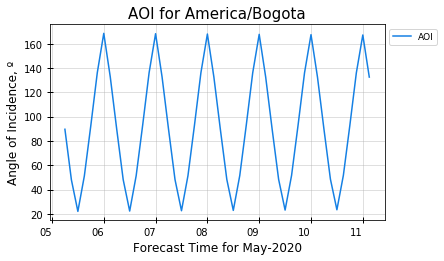

In [32]:
aoi = irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth']);

# AOI Plot

plt.style.use('fast')

fig1, ax1 = plt.subplots();

aoi.plot(label='AOI', color='#1580E4');

plt.rc('font', family='Helvetica')

plt.title('AOI for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Angle of Incidence, º', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('AOI.eps', bbox_inches='tight')

### 4.6. TOTAL POA

Determine in-plane irradiance components. Combines DNI with sky diffuse and ground-reflected irradiance to calculate total, direct and diffuse irradiance components **<ins>in</ins>** the plane of array.

More info of the function at (i.) https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.irradiance.poa_components.html and (ii.) https://pvpmc.sandia.gov/modeling-steps/1-weather-design-inputs/plane-of-array-poa-irradiance/.

An extract from the second page snipped above makes clear that one can measure the plane of array irradiance directly with a pyranometer, reference cell or reference module mounted in the same orientation of the array. **<ins>However</ins>**, the analyst must understand the different characteristics of these sensors to ensure that any subsequent corrections made to the measured POA irradiance are appropriate.  For example, a matched reference cell or module probably has the same reflective properties of the modules in the array, so reflective losses are inherently included in the measured value and should not be *'corrected'* for again.

More info about plane of array (POA) at https://www.campbellsci.cc/blog/albedo-resource-assessment.

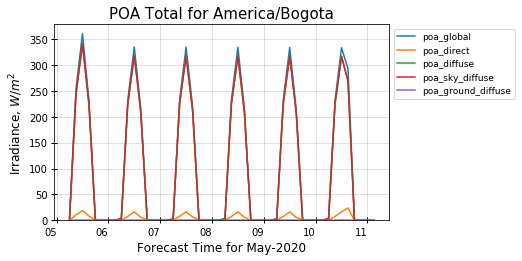

In [33]:
poa_irrad = irradiance.poa_components(aoi, data_weatherforecast['dni'], poa_sky_diffuse, poa_ground_diffuse);

# Total POA Plot

plt.style.use('fast')

poa_irrad.plot(label='poa_irrad');

plt.rc('font', family='Helvetica')

plt.title('POA Total for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^{2}$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('POA_Total.eps', bbox_inches='tight')

### 4.7. CELL AND MODULE TEMPERATURE

Estimate cell and module temperatures per the Sandia PV Array Performance Model (SAPM, SAND2004-3535), from the incident irradiance, wind speed, ambient temperature, and SAPM module parameters.

PV system efficiency can vary by up to 0.5% per ºC, so it is important to accurately model cell and module temperature. From King et. al. (2004):

$$T_{module} = E \: e^{a + b \: · \: WS} + T_a$$

$$T_{cell} = T_{module} + \frac{E}{E_0} · \Delta T$$

The $a$, $b$, and $\Delta T$ parameters depend on the module and racking type. **The default parameter set is** ```open_rack_cell_glassback```.

Notice that ```sapm_celltemp``` works with either scalar or vector inputs, but always returns a pandas DataFrame.


More info at https://wholmgren-pvlib-python-new.readthedocs.io/en/doc-reorg2/generated/pvsystem/pvlib.pvsystem.sapm_celltemp.html.

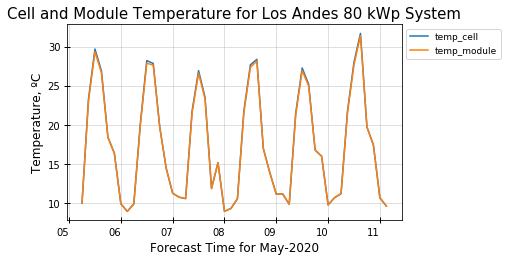

In [34]:
temperature = data_weatherforecast['temp_air'];
wind_speed = data_weatherforecast['wind_speed'];
pvtemps = pvsystem.sapm_celltemp(poa_irrad['poa_global'], wind_speed, temperature, model='roof_mount_cell_glassback');

LosAndesSys = 'Los Andes 80 kWp System';

# Cell and Module Temperature Plot

plt.style.use('fast')

pvtemps.plot();

plt.rc('font', family='Helvetica')

plt.title('Cell and Module Temperature for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('Temperature, ºC', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Cell_Module_Temperature.eps', bbox_inches='tight')

### 4.8. ANGLE OF INCIDENCE MODIFIERS

Determine the incidence angle modifier using the ASHRAE transmission model.

The ASHRAE (American Society of Heating, Refrigeration, and Air Conditioning Engineers) transmission model has been used in commercial software such as **PVSyst**.

More info at https://pvlib-python.readthedocs.io/en/v0.7.2/generated/pvlib.iam.ashrae.html.

If the user want an approach to this concept of solar tracking (*AIM*), please check this page: http://www.solarpanelsplus.com/solar-tracking/.

Sandia has available a bunch of models that comprehends: (i.) **ASHRAE**, (ii.) **Physical**, (iii.) **Martin-Ruiz**, (iv.) **Interp** and (v.) **SAPM**.

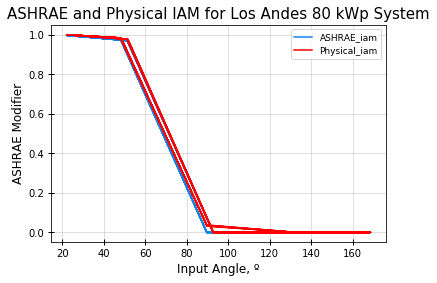

In [35]:
ashraeiam = pd.Series(pvsystem.ashraeiam(aoi, b=0.05), index=aoi);
physicaliam = pvsystem.physicaliam(aoi, n=1.526, K=4.0, L=0.002);

# ASHRAE IAM Plot

plt.style.use('fast')

ashraeiam.plot(label='ASHRAE_iam', color='#1580E4');
plt.plot(aoi, physicaliam, label='Physical_iam', color='red');

plt.rc('font', family='Helvetica')

plt.title('ASHRAE and Physical IAM for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('ASHRAE Modifier', fontname="Helvetica", fontsize=12);
plt.xlabel('Input Angle, º', fontname="Helvetica", fontsize=12);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('ASHRAE_iam.eps', bbox_inches='tight')

### 4.9. EFFECTIVE IRRADIANCE
Effective irradiance is total plane of array (POA) irradiance adjusted for **angle of incidence losses**, **soiling** and **spectral mismatch**. In a general sense it can be thought of as the irradiance that is *'available'* to the PV array for power conversion. In other words, effective irradiance is the irradiance that is converted to electrical current.

More info at https://pvpmc.sandia.gov/modeling-steps/2-dc-module-iv/effective-irradiance/.

##### 4.9.1. Total Irradiance
Here it is determined the total in-plane irradiance according to its beam, sky diffuse and ground reflected components.

**RELEVANT:** It is equivalent as the Total POA section (4.6.) when the author uses the code ```irradiance.poa_components```.

More info at https://wholmgren-pvlib-python-new.readthedocs.io/en/doc-reorg2/generated/irradiance/pvlib.irradiance.total_irrad.html.

/Users/nelsonsasa07/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: pvlibDeprecationWarning: The total_irrad function was deprecated in pvlib 0.6 and will be removed in 0.7. Use get_total_irradiance instead.
  if __name__ == '__main__':


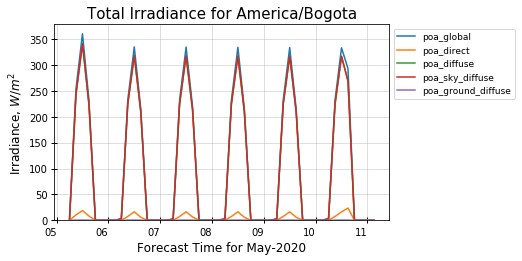

In [36]:
#Total Irradiance
total_irrad = irradiance.total_irrad(surface_tilt,
                                     surface_azimuth,
                                     solpos['apparent_zenith'],
                                     solpos['azimuth'],
                                     irrads_larson['dni'], irrads_larson['ghi'], irrads_larson['dhi'],
                                     dni_extra=dni_extra,
                                     albedo=surface_albedo,
                                     model='haydavies')

# Total Irradiance Plot

plt.style.use('fast')

total_irrad.plot(label='poa_irrad');

plt.rc('font', family='Helvetica')

plt.title('Total Irradiance for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^{2}$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Total_Irradiance.eps', bbox_inches='tight')

**RELEVANT:** SAPM function ```pvlib.pvsystem.sapm``` generates five (5) points on a PV module’s I-V curve ($V_{oc}$, $I_{sc}$, $I_x$, $I_{xx}$, $V_{mp}$ and $I_{mp}$) according to SAND2004-3535. It assumes a reference cell temperature of 25ºC. This same function requires variables referring to spectral mismatch and reflection model modifiers that Sandia modules have **<ins>but</ins>** CEC modules don't. 

In order to solve this setback, first calculate the effective irradiance from plane of array (POA) irradiance, choosing a reflection model (```pvlib.pvsystem.physicaliam``` or ```pvlib.pvsystem.ashraeiam```), and a spectral modifier model (if the user want to account for spectrum, ```pvlib.atmosphere.first_solar_spectral_correction``` is an option that does not require SAPM parameters).

More info at: https://stackoverflow.com/questions/55916387/how-to-calculate-the-effective-irradiance-with-pvlibs-pvwatts-model.

##### 4.9.2. Precipitable Water
Calculates precipitable water (cm) from ambient air temperature (C) and relatively humidity (%) using an empirical model. The accuracy of this method is approximately 20% for moderate PW (1-3 cm) and less accurate otherwise.

**Note:** According to *weather-col.com* the relative humidity at Bogotá from April is 77%. The user can eyeball this information at https://www.weather-col.com/es/colombia/bogota-clima.

More info at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.atmosphere.gueymard94_pw.html.

In [37]:
# Precipitable Water (pw)

pw = atmosphere.gueymard94_pw(data_weatherforecast['temp_air'], relative_humidity=77)
pw.head()

2020-05-05 06:00:00-05:00    1.555662
2020-05-05 09:00:00-05:00    1.593629
2020-05-05 12:00:00-05:00    1.752646
2020-05-05 15:00:00-05:00    2.243662
2020-05-05 18:00:00-05:00    2.615457
Name: temp_air, dtype: float64

##### 4.9.3. First Solar Spectral Correction (Spectral Mismatch)
Spectral mismatch modifier is based on precipitable water and absolute (pressure corrected) airmass. Estimates a spectral mismatch modifier $M$ representing the effect on module short circuit current of variation in the spectral irradiance.

Due to the fact that this is a *'correction'* value, it can also modify the POA irradiance value by direct multiplication given a constant correction factor. This is a sensitive evaluation (as kind of interpolation). The user can try with an arbitrary value. The author will use 70%.

More info at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.atmosphere.first_solar_spectral_correction.html.

In [38]:
# Spectral Mismatch
# More information at https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.atmosphere.first_solar_spectral_correction.html

spectral_mismatch_raw = atmosphere.first_solar_spectral_correction(pw, absolute_airmass, module_type='monosi', coefficients=None);

#spectral_mismatch_raw = spectral_mismatch_raw[~np.isnan(spectral_mismatch_raw)] # Removing NaN values from the array
spectral_mismatch = spectral_mismatch_raw.fillna(1); # Changing NaN values from the array to 1

spectral_mismatch.head()

2020-05-05 06:00:00-05:00    1.040740
2020-05-05 09:00:00-05:00    0.982737
2020-05-05 12:00:00-05:00    0.972214
2020-05-05 15:00:00-05:00    0.987755
2020-05-05 18:00:00-05:00    1.047690
dtype: float64

##### 4.9.4. Effective Irradiance Calculation
Here the author calculates the *effective irradiance* variable by two means: (i.) by the given theoretically equation and (ii.) by the *'correction factor'* established by the author as 80%.

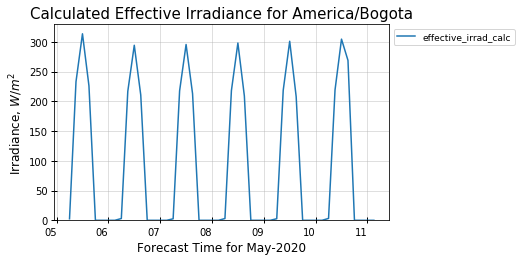

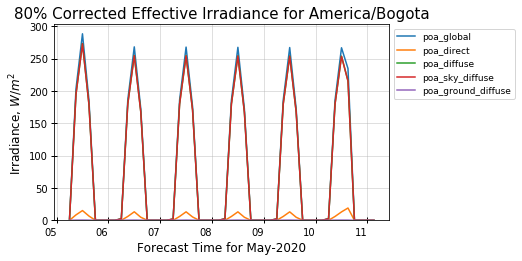

In [39]:
#physicaliam_mod = physicaliam[physicaliam != 0] # Correction tries
#physicaliam_value = np.mean(physicaliam_mod) # Correction tries

effective_irrad_calc = (total_irrad['poa_direct'] * np.cos(aoi) * physicaliam + total_irrad['poa_diffuse']) * spectral_mismatch;

effective_irrad_corr = 0.8*total_irrad;

#Calculated Effective Irradiance Plot

plt.style.use('fast')

effective_irrad_calc.plot(label='effective_irrad_calc');

plt.rc('font', family='Helvetica')

plt.title('Calculated Effective Irradiance for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^{2}$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Effective_Irrad_Calc.eps', bbox_inches='tight')

#Corrected Effective Irradiance Plot

plt.style.use('fast')

effective_irrad_corr.plot(label='effective_irrad_corr');

plt.rc('font', family='Helvetica')

plt.title('80% Corrected Effective Irradiance for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^{2}$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Effective_Irrad_Corr.eps', bbox_inches='tight')

##### 4.9.5. Effective Irradiance Troubles
If the user wants to get the effective irradiance with the ```pvsystem.sapm_effective_irradiance``` function **<ins>but</ins>** with a CEC module, the following variables are required.

More info about this parameters at: https://pvpmc.sandia.gov/modeling-steps/dc-to-ac-conversion/sandia-inverter-model/.

```python
# Effective Irradiance

module['A4'] = -6.93e-05
module['A3'] = 0.0016606
module['A2'] = -0.0157738
module['A1'] = 0.068093
module['A0'] = 0.928385

module['B0'] = 1
module['B1'] = -0.002438
module['B2'] = 0.0003103
module['B3'] = -1.246e-05
module['B4'] = 2.11e-07
module['B5'] = -1.36e-09

module['Bvmpo'] = -0.36
module['Mbvmp'] = 0
module['Bvoco'] = -0.26
module['Mbvoc'] = 0
module['N'] = 1
module['Cells_in_Series'] = 12
module['Isco'] = 10.43
module['Aisc'] = 0
module['Impo'] = 9.83
module['C0'] = -1.28775e-07 #Value from PVWatts API
module['C1'] = -2.4e-05 #Values from PVWatts API
module['C2'] = 0.001013 #Values from PVWatts API
module['C3'] = -0.000319 #Values from PVWatts API
module['Aimp'] = 0
module['Voco'] = 49.2
module['Vmpo'] = 40.2
module['FD'] = 1

effective_irradiance = pvsystem.sapm_effective_irradiance(total_irrad['poa_direct'], total_irrad['poa_diffuse'],                                                                 absolute_airmass, aoi, module)

effective_irradiance.head()

sapm_out = pvsystem.sapm(effective_irradiance, pvtemps['temp_cell'], module) #SAPM function (Section 5.2.)
```

___
## SECTION 5: PV POWER MODELING

First of all, the variables at the Section 4 are recalculated here with the ```PVSystem``` and ```ModelChain``` classes (previously used the ```get_clearsky()``` method).

### 5.1. GET THE INVERSORS INFORMATION FROM MULTIPLES DATABASES

The inversors module databases are: (i.) CEC module database, (ii.) Sandia Module database, (iii.) CEC Inverter database and (iv.) Anton Driesse Inverter database.

More information at: https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.pvsystem.retrieve_sam.html.

In [40]:
# Get the Inversors Characteristics from the Database Selected
# There is two modules due to the fact that the University Solar Park is compound by two different systems
# The user can check the databases here: https://github.com/BreakingBytes/simkit/tree/master/examples/PVPower/pvpower

inverters_database = 'CECInverter';

inverters = retrieve_sam(inverters_database);
inverter_A = inverters.ABB__TRIO_50_0_TL_OUTD_US_480__480V__480V__CEC_2018_; #51.24 kWp System
inverter_B = inverters.ABB__TRIO_27_6_TL_OUTD_S_US_480__480V__480V__CEC_2018_; #28.82 kWp System

___
In case that the user struggles with the search of the exact module or inverter (cannot find it at the availables Sandias' databases), try this way:

1. Search for the module or inverter at the repository by PVFree (https://pvfree.herokuapp.com/).
2. Look for the module or inverter ID that appears at PVFree (i.e. 10267) or the name of the module (i.e. LG400N2W-A5).
3. Run the code snippet below.

The user can find some examples at: https://groups.google.com/forum/m/#!topic/pvlib-python/Zc0grCqYRkA.

The author also encourages the user to join the Google group forum in order to explore more about PVLIB-Python coding procedures (https://groups.google.com/forum/m/#!forum/pvlib-python).
___

In [41]:
import requests
get_module = requests.get('https://pvfree.herokuapp.com/api/v1/cecmodule/10267')
get_module.json()

{'A_c': 2.0,
 'Adjust': 9.380614,
 'BIPV': False,
 'Bifacial': False,
 'Date': '2018-11-04',
 'I_L_ref': 10.48115,
 'I_mp_ref': 9.86,
 'I_o_ref': 1.807477e-11,
 'I_sc_ref': 10.47,
 'Length': 2.0,
 'N_s': 72,
 'Name': 'LG Electronics Inc. LG400N2W-A5',
 'PTC': 368.4,
 'R_s': 0.312859,
 'R_sh_ref': 293.80542,
 'STC': 400.316,
 'T_NOCT': 47.7,
 'Technology': 'Mono-c-Si',
 'V_mp_ref': 40.6,
 'V_oc_ref': 49.3,
 'Version': 'SAM 2018.10.29',
 'Width': 1.0,
 'a_ref': 1.821208,
 'alpha_sc': 0.003141,
 'beta_oc': -0.12818,
 'created_on': '2019-02-12',
 'gamma_r': -0.36,
 'id': 10267,
 'modified_on': '2019-02-12',
 'resource_uri': '/api/v1/cecmodule/10267/'}

___
**Note:** Due to the fact that the exact module was not found in those databases, the author proceed to create it (***LG Electronics Inc. LG400N2W-A5***).
___

In [42]:
# Name,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,I_mp_ref,V_mp_ref,alpha_sc,beta_oc,T_NOCT,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
# LG Electronics Inc. LG400N2W-A5,Mono-c-Si,0,400.316000,368.400000,2,2,1,72,10.470000,49.300000,9.860000,40.600000,0.003141,-0.128180,47.700000,1.821208,10.481150,1.807477e-11,0.312859,293.805420,9.380614,-0.360000,N,SAM 2018.11.11 r2,1/3/2019

LG400N2WA5 = {
'BIPV':                'N',
'Date':          '1/3/2019',
'T_NOCT':             47.7,
'A_c':                 2.0,
'N_s':                  72,
'I_sc_ref':          10.47,
'V_oc_ref':           49.3,
'I_mp_ref':           9.86,
'V_mp_ref':           40.6,
'alpha_sc':       0.003141,
'beta_oc':        -0.12180,
'a_ref':            1.821208,
'I_L_ref':          10.481150,
'I_o_ref':         1.807477e-11,
'R_s':               0.312859,
'R_sh_ref':         293.805420,
'Adjust':            9.380614,
'gamma_r':          -0.36,
'Version':          'NRELv1',
'PTC':               368.4,
'Technology':    'Mono-c-Si',
'Name': 'LG Electronics LG385N2W-A5',
    
#PVSyst Required Variables
'gamma_ref':         1.013, #Diode Quality Factor, Value from PVSyst    
'mu_gamma':          0, #PVSyst specify that mono-cSi modules mu_gamma is very close to zero
'R_sh_0':            3500, #Resistance shunt at 0 irrad., Value from PVSyst                                                           
'R_sh_exp':          5.5, #Experimental resistance shunt, Value from PVSyst
'cells_in_series':  72,    
'EgRef':            1.121,

#PVWatts Required Variables   
'pdc0':              400.316, #Value from PVWatts API and validated with PVSyst API
'gamma_pdc':        -0.0036 #Value from PVWatts API and validated with PVSyst API
}

module = pd.Series(LG400N2WA5, name='LG_Electronics_LG385N2W_A5')

In [43]:
# Definition of the Los Andes Photovoltaic Systems

#System A
sysA_name = 'Los Andes 51.25 kWp System Capacity';
mps_SysA = 16; #Modules Per String
spi_SysA = 8; #Strings Per Inverter

system_A = PVSystem(module_parameters=module, inverter_parameters=inverter_A, surface_azimuth=180, 
                    surface_tilt=10, modules_per_string=mps_SysA, strings_per_inverter=spi_SysA)

#System B
sysB_name = 'Los Andes 28.82 kWp System Capacity';
mps_SysB = 18; #Modules Per String
spi_SysB = 4; #Strings Per Inverter
system_B = PVSystem(module_parameters=module, inverter_parameters=inverter_B, surface_azimuth=180, 
                    surface_tilt=10, modules_per_string=mps_SysB, strings_per_inverter=spi_SysB)

### 5.2. SYSTEMS' FIVE PARAMETERS BY SINGLE DIODE METHOD INITIALIZATION

Here is solved the single-diode model to obtain a photovoltaic I-V curve.

More info about de Single-Diode Method at https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.singlediode.html#pvlib.pvsystem.singlediode.

Due to the fact that the SAPM funcion ```pvsystem.sapm``` requires many parameters that Sandia' modules provides but CEC modules doesn't, it is needed to use another function. 

More info about the function at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.pvsystem.sapm.html. Also, more info about the module at https://www.lg.com/us/business/solar-panels/lg-LG400N2W-A5.

#### 5.2.1. Method 1
The ***Method 1*** refers to, first, get the maximum *n* values of the parameters **<ins>effective irradiance</ins>** and **<ins>cell temperature</ins>** (*n* values according to the number of analyzed days) and then using the function ```pvsystem.singlediode``` to obtain values of $I_{mp}$, $V_{mp}$ and $P_{mp}$.

**Note:** This method retrieve an $I_{mp}$, $V_{mp}$ and $P_{mp}$ value per day analyzed, not a *'continuous'* array during all days.

##### 5.2.1.1. De Soto et. al. Model
In order to achieve the same goal, it will be used the function ```pvsystem.calcparams_desoto``` to obtain five parameter values for the single diode equation at effective irradiance and cell temperature using the De Soto et al. model and then be used by single diode to calculate an I-V curve.

More info at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.pvsystem.calcparams_desoto.html.

In [44]:
max_eff_irrad = effective_irrad_calc.resample('1d').max();

max_location = effective_irrad_calc.resample('1d').apply(lambda s: s.idxmax());

max_temp_cell = pvtemps['temp_cell'].resample('1d').max();

cases = list(zip(max_location.values, max_eff_irrad.values, max_temp_cell.values));
conditions = pd.DataFrame(cases, columns=['Datetime', 'Geff', 'Tcell']);
conditions = conditions.round(2);
conditions.head()

,Datetime,Geff,Tcell
0,2020-05-05 17:00:00,313.85,29.69
1,2020-05-06 17:00:00,294.53,28.20
2,2020-05-07 17:00:00,295.83,26.92
3,2020-05-08 17:00:00,298.28,28.36
4,2020-05-09 17:00:00,301.31,27.26


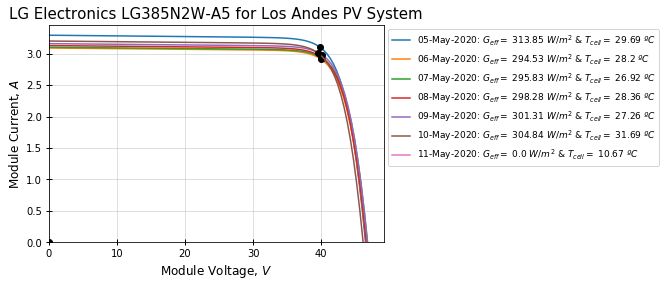

   i_sc   v_oc  i_mp   v_mp    p_mp   i_x  i_xx
0  3.29  46.50  3.10  39.80  123.54  3.27  2.45
1  3.09  46.60  2.91  39.97  116.43  3.07  2.30
2  3.10  46.80  2.93  40.17  117.53  3.08  2.32
3  3.13  46.60  2.95  39.95  117.88  3.10  2.33
4  3.16  46.78  2.98  40.13  119.60  3.14  2.36
5  3.20  46.15  3.02  39.46  118.99  3.18  2.38
6  0.00   0.00  0.00   0.00    0.00  0.00  0.00


<Figure size 432x288 with 0 Axes>

In [45]:
IL_DS, I0_DS, Rs_DS, Rsh_DS, nNsVth_DS = pvsystem.calcparams_desoto(conditions['Geff'],
                                                     conditions['Tcell'],
                                                     module['alpha_sc'],
                                                     module['a_ref'],
                                                     module['I_L_ref'],
                                                     module['I_o_ref'],
                                                     module['R_sh_ref'],
                                                     module['R_s'],
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     dEgdT=-0.0002677) #Retrieved from last link at above description

curve_info_DS = pvsystem.singlediode(photocurrent=IL_DS,
                                  saturation_current=I0_DS,
                                  resistance_series=Rs_DS,
                                  resistance_shunt=Rsh_DS,
                                  nNsVth=nNsVth_DS,
                                  ivcurve_pnts=100,
                                  method='lambertw')

# I-V Curves Plot
plt.style.use('fast')
plt.rc('font', family='Helvetica')
plt.figure()
                                                     
for i, case in conditions.iterrows():
    label = (
        f"{case['Datetime'].strftime('%d-%b-%Y')}: "
        "$G_{eff} = $ " + f"{case['Geff']} $W/m^2$ & "
        "$T_{cell} = $ " + f"{case['Tcell']} $ºC$")
    
    plt.plot(curve_info_DS['v'][i], curve_info_DS['i'][i], label=label)
    v_mp = curve_info_DS['v_mp'][i]
    i_mp = curve_info_DS['i_mp'][i]
    # mark the MPP
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)
                                                     
plt.title(LG400N2WA5['Name'] + ' for Los Andes PV System', fontname="Helvetica", fontsize=15);
plt.ylabel('Module Current, $A$', fontname="Helvetica", fontsize=12);
plt.xlabel('Module Voltage, $V$', fontname="Helvetica", fontsize=12);
plt.grid(True);
plt.ylim(0, None)
plt.xlim(0, None)
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('DS_IV_Curves.eps', bbox_inches='tight') 
plt.show()
plt.gcf().set_tight_layout(True)

data_summary_DS = pd.DataFrame({'i_sc': curve_info_DS['i_sc'],
                                'v_oc': curve_info_DS['v_oc'],
                                'i_mp': curve_info_DS['i_mp'],
                                'v_mp': curve_info_DS['v_mp'],
                                'p_mp': curve_info_DS['p_mp'],
                                'i_x': curve_info_DS['i_x'],
                                'i_xx': curve_info_DS['i_xx']})

data_summary_DS = data_summary_DS.round(2)
print(data_summary_DS)

##### 5.2.1.2. CEC Model
The function calculates five parameter values for the single diode equation at effective irradiance and cell temperature using the CEC model. The CEC model differs from the De Soto et al. model by the parameter *Adjust* (the adjustment to the temperature coefficient for short circuit current, in percent).

**Note:** The *Adjust* is given by the manufacturer of the module, i.e. LG Electronics (https://www.lg.com/us/business/solar-panels/lg-LG400N2W-A5).

More info at https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.calcparams_cec.html#pvlib.pvsystem.calcparams_cec.

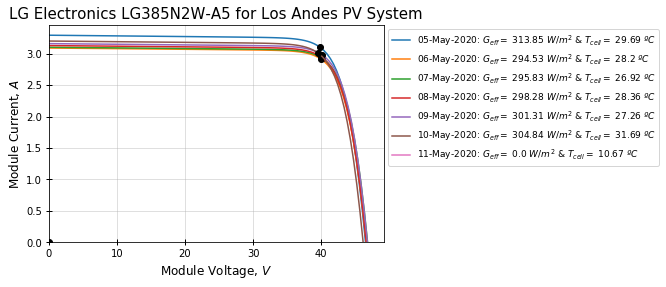

   i_sc   v_oc  i_mp   v_mp    p_mp   i_x  i_xx
0  3.29  46.50  3.10  39.80  123.52  3.27  2.45
1  3.09  46.60  2.91  39.97  116.42  3.07  2.30
2  3.10  46.80  2.93  40.17  117.52  3.08  2.31
3  3.13  46.60  2.95  39.95  117.87  3.10  2.33
4  3.16  46.78  2.98  40.13  119.59  3.14  2.36
5  3.20  46.15  3.01  39.46  118.97  3.18  2.38
6  0.00   0.00  0.00   0.00    0.00  0.00  0.00


<Figure size 432x288 with 0 Axes>

In [46]:
IL_CEC, I0_CEC, Rs_CEC, Rsh_CEC, nNsVth_CEC = pvsystem.calcparams_cec(conditions['Geff'],
                                                     conditions['Tcell'],
                                                     module['alpha_sc'],
                                                     module['a_ref'],
                                                     module['I_L_ref'],
                                                     module['I_o_ref'],
                                                     module['R_sh_ref'],
                                                     module['R_s'],
                                                     Adjust=9.380614,
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     dEgdT=-0.0002677) #Retrieved from last link at above description

curve_info_CEC = pvsystem.singlediode(photocurrent=IL_CEC,
                                  saturation_current=I0_CEC,
                                  resistance_series=Rs_CEC,
                                  resistance_shunt=Rsh_CEC,
                                  nNsVth=nNsVth_CEC,
                                  ivcurve_pnts=100,
                                  method='lambertw')

# I-V Curves Plot
plt.style.use('fast')
plt.rc('font', family='Helvetica')
plt.figure()
                                                     
for i, case in conditions.iterrows():
    label = (
        f"{case['Datetime'].strftime('%d-%b-%Y')}: "
        "$G_{eff} = $ " + f"{case['Geff']} $W/m^2$ & "
        "$T_{cell} = $ " + f"{case['Tcell']} $ºC$")
    
    plt.plot(curve_info_CEC['v'][i], curve_info_CEC['i'][i], label=label)
    v_mp = curve_info_CEC['v_mp'][i]
    i_mp = curve_info_CEC['i_mp'][i]
    # mark the MPP
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)
                                                     
plt.title(LG400N2WA5['Name'] + ' for Los Andes PV System', fontname="Helvetica", fontsize=15);
plt.ylabel('Module Current, $A$', fontname="Helvetica", fontsize=12);
plt.xlabel('Module Voltage, $V$', fontname="Helvetica", fontsize=12);
plt.ylim(0, None)
plt.xlim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('CEC_IV_Curves.eps', bbox_inches='tight') 
plt.show()
plt.gcf().set_tight_layout(True)

data_summary_CEC = pd.DataFrame({'i_sc': curve_info_CEC['i_sc'],
                                'v_oc': curve_info_CEC['v_oc'],
                                'i_mp': curve_info_CEC['i_mp'],
                                'v_mp': curve_info_CEC['v_mp'],
                                'p_mp': curve_info_CEC['p_mp'],
                                'i_x': curve_info_CEC['i_x'],
                                'i_xx': curve_info_CEC['i_xx']})

data_summary_CEC = data_summary_CEC.round(2)
print(data_summary_CEC)

___
**Note:** The ```pvsystem.singlediode``` function gets the $I_{mp}$, $V_{mp}$ and $P_{mp}$ values but also the user could get those by applying the function ```pvsystem.max_power_point```. An example of the code is snipped below.

More info at https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.max_power_point.html#pvlib.pvsystem.max_power_point.
___

In [47]:
mpp_DS = pvsystem.max_power_point(photocurrent=IL_DS,
                                  saturation_current=I0_DS,
                                  resistance_series=Rs_DS,
                                  resistance_shunt=Rsh_DS,
                                  nNsVth=nNsVth_DS, 
                                  method='brentq') #For the Single-Diode Method by De Soto et. al. Parameters

mpp_CEC = pvsystem.max_power_point(photocurrent=IL_CEC,
                                  saturation_current=I0_CEC,
                                  resistance_series=Rs_CEC,
                                  resistance_shunt=Rsh_CEC,
                                  nNsVth=nNsVth_CEC, 
                                  method='brentq')

mpp_CEC.head() #For the Single-Diode Method by CEC Parameters

,i_mp,v_mp,p_mp
0,3.104210,39.791366,123.520742
1,2.913245,39.962922,116.421797
2,2.926088,40.164056,117.523563
3,2.950315,39.949975,117.865016
4,2.980261,40.128431,119.593199


##### 5.2.1.3. Scalating Single Diode Results for the Los Andes Photovoltaic System
The results obtained from the ```pvsystem.singlediode``` method are equivalent to the production of a single module of the photovoltaic system. In order to get the complete production, the method ```pvsystem.scale_voltage_current_power``` is used. This method scales the voltage, current, and power of the designen system (Section 5.1. — Definition of the Los Andes Photovoltaic Systems).

More info at https://cwhanse-pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.scale_voltage_current_power.html.

In [48]:
# Scalating De Soto et. al. Single Diode Results
results_DS = pd.DataFrame(data_summary_DS, columns=data_summary_DS.keys())

scaled_results_DS_SysA = system_A.scale_voltage_current_power(results_DS)
scaled_results_DS_SysB = system_B.scale_voltage_current_power(results_DS)

scaled_results_DS_SysA.head()

,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx
0,26.32,744.00,24.80,636.80,15813.12,26.16,19.60
1,24.72,745.60,23.28,639.52,14903.04,24.56,18.40
2,24.80,748.80,23.44,642.72,15043.84,24.64,18.56
3,25.04,745.60,23.60,639.20,15088.64,24.80,18.64
4,25.28,748.48,23.84,642.08,15308.80,25.12,18.88


In [49]:
# Scalating CEC Single Diode Results
results_CEC = pd.DataFrame(data_summary_CEC, columns=data_summary_CEC.keys())

scaled_results_CEC_SysA = system_A.scale_voltage_current_power(results_CEC)
scaled_results_CEC_SysB = system_B.scale_voltage_current_power(results_CEC)

scaled_results_CEC_SysA.head()

,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx
0,26.32,744.00,24.80,636.80,15810.56,26.16,19.60
1,24.72,745.60,23.28,639.52,14901.76,24.56,18.40
2,24.80,748.80,23.44,642.72,15042.56,24.64,18.48
3,25.04,745.60,23.60,639.20,15087.36,24.80,18.64
4,25.28,748.48,23.84,642.08,15307.52,25.12,18.88


#### 5.2.2. Method 2
The ***Method 2*** is kinda the opposite of the *Method 1*. 

This ***Method 2*** refers to, first, to use the function ```pvsystem.singlediode``` to obtain values of $I_{mp}$, $V_{mp}$ and $P_{mp}$ and then getting the maximum *n* values of the parameters **<ins>effective irradiance</ins>** and **<ins>cell temperature</ins>** (*n* values according to the number of days that are analyzed) .

This method retrieved an $I_{mp}$, $V_{mp}$ and $P_{mp}$ value continuous array (or list, series, DataFrame) per analyzed day, not an *'unique'* value per all days.

**Note:** The ***Method 2*** uses the De Soto et. al. model to then run the ```pvsystem.singlediode``` function.

In [50]:
IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_cec(effective_irrad_calc,
                                                     pvtemps['temp_cell'],
                                                     module['alpha_sc'],
                                                     module['a_ref'],
                                                     module['I_L_ref'],
                                                     module['I_o_ref'],
                                                     module['R_sh_ref'],
                                                     module['R_s'],
                                                     Adjust=9.380614,
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     dEgdT=-0.0002677) #Retrieved from last link at above description

curve_info = pvsystem.singlediode(photocurrent=IL,
                                  saturation_current=I0,
                                  resistance_series=Rs,
                                  resistance_shunt=Rsh,
                                  nNsVth=nNsVth,
                                  ivcurve_pnts=100,
                                  method='lambertw')

# Scalating CEC et. al. Single Diode Results
data_i_sc = pd.Series(curve_info['i_sc'])
data_v_oc = pd.Series(curve_info['v_oc'])
data_i_mp = pd.Series(curve_info['i_mp'])
data_v_mp = pd.Series(curve_info['v_mp'])
data_p_mp = pd.Series(curve_info['p_mp'])
data_i_x = pd.Series(curve_info['i_x'])
data_i_xx = pd.Series(curve_info['i_xx'])

results_general = pd.DataFrame({'i_sc': data_i_sc, 
                        'v_oc': data_v_oc,
                        'i_mp': data_i_mp, 
                        'v_mp': data_v_mp, 
                        'p_mp': data_p_mp, 
                        'i_x': data_i_x,
                        'i_xx': data_i_xx})

sc_SysA = system_A.scale_voltage_current_power(results_general)
sc_SysA['Datetime'] = pd.to_datetime(effective_irrad_calc.index)
sc_SysA = sc_SysA.set_index('Datetime')

sc_SysB = system_B.scale_voltage_current_power(results_general)
sc_SysB['Datetime'] = pd.to_datetime(effective_irrad_calc.index)
sc_SysB = sc_SysB.set_index('Datetime')

In [51]:
# Max Values of Scalated Data for SysA

max_isc_SysA = sc_SysA['i_sc'].resample('1d').max();
max_voc_SysA = sc_SysA['v_oc'].resample('1d').max();
max_imp_SysA = sc_SysA['i_mp'].resample('1d').max();
max_vmp_SysA = sc_SysA['v_mp'].resample('1d').max();
max_pmp_SysA = sc_SysA['p_mp'].resample('1d').max();
max_ix_SysA = sc_SysA['i_x'].resample('1d').max();
max_ixx_SysA = sc_SysA['i_xx'].resample('1d').max();

cases_sc_SysA = list(zip(max_isc_SysA.values, max_voc_SysA.values, max_imp_SysA.values, max_vmp_SysA.values, 
                         max_pmp_SysA.values, max_ix_SysA.values, max_ixx_SysA.values));

sc_max_SysA = pd.DataFrame(cases_sc_SysA, columns=['i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp', 'i_x', 'i_xx']);
sc_max_SysA = sc_max_SysA.round(2);
sc_max_SysA.head()

# Max Values of Scalated Data for SysB

max_isc_SysB = sc_SysB['i_sc'].resample('1d').max();
max_voc_SysB = sc_SysB['v_oc'].resample('1d').max();
max_imp_SysB = sc_SysB['i_mp'].resample('1d').max();
max_vmp_SysB = sc_SysB['v_mp'].resample('1d').max();
max_pmp_SysB = sc_SysB['p_mp'].resample('1d').max();
max_ix_SysB = sc_SysB['i_x'].resample('1d').max();
max_ixx_SysB = sc_SysB['i_xx'].resample('1d').max();

cases_sc_SysB = list(zip(max_isc_SysB.values, max_voc_SysB.values, max_imp_SysB.values, max_vmp_SysB.values, 
                         max_pmp_SysB.values, max_ix_SysB.values, max_ixx_SysB.values));

sc_max_SysB = pd.DataFrame(cases_sc_SysB, columns=['i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp', 'i_x', 'i_xx']);
sc_max_SysB = sc_max_SysB.round(2);
sc_max_SysB.head()

,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx
0,13.17,844.29,12.41,729.03,8893.43,13.07,9.78
1,12.35,850.55,11.65,736.30,8382.16,12.26,9.21
2,12.41,846.17,11.70,731.80,8461.82,12.31,9.26
3,12.51,846.18,11.80,731.80,8509.01,12.42,9.33
4,12.64,847.09,11.92,732.59,8610.54,12.54,9.42


___
## SECTION 6: PV SYSTEM OUTPUTS

System outputs (DC voltage, DC current, DC power, AC power, module temperature and daily energy) *manually calculated* by the code sequence developed in this *Jupyter Notebook*. 

It is highlighted as manually calculated since later it will be compared with the *ModelChain* class (Section 7).

___
**Note:** First, the code snipped below helps to create the bar plots by creating parameters as bars' width and integers of the days for the *x-label*.
___

### 6.1. DC VOLTAGE

In [52]:
bar_width = 0.2;
x = np.arange(len(conditions['Datetime']))

days = np.linspace(int(start.day), int(end.day), len(conditions['Datetime']))

int_days = []
for day in days:
    int_days.append(int(day))

int_days

[5, 6, 7, 8, 9, 10, 11]

,Day,SysA_Method_1,SysB_Method_1,SysA_Method_2,SysB_Method_2
0,5,636.8,716.4,648.0,729.0
1,6,639.5,719.5,654.5,736.3
2,7,642.7,723.1,650.5,731.8
3,8,639.2,719.1,650.5,731.8
4,9,642.1,722.3,651.2,732.6
5,10,631.4,710.3,650.6,732.0
6,11,0.0,0.0,0.0,0.0


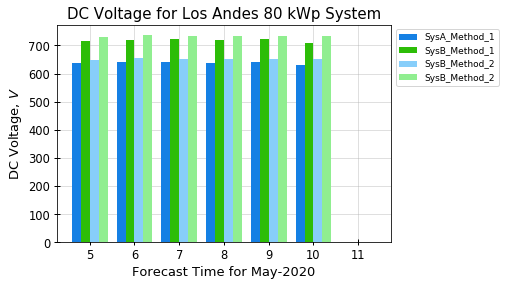

In [53]:
r1 = np.arange(len(conditions['Datetime']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

#DC Voltage Plot
plt.style.use('fast')

plt.bar(r1, scaled_results_DS_SysA['v_mp'], bar_width, label='SysA_Method_1', color='#1580E4', zorder=5);
plt.bar(r2, scaled_results_DS_SysB['v_mp'], bar_width, label='SysB_Method_1', color='#2DBD07', zorder=10);

plt.bar(r3, sc_max_SysA['v_mp'], bar_width, label='SysB_Method_2', color='lightskyblue', zorder=15);
plt.bar(r4, sc_max_SysB['v_mp'], bar_width, label='SysB_Method_2', color='lightgreen', zorder=20);

plt.rc('font', family='Helvetica')

plt.title('DC Voltage for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('DC Voltage, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5, labelsize=11.5)

plt.rcParams['axes.axisbelow'] = True;
plt.xticks(x + bar_width + bar_width/2, int_days)
plt.ylim(0, None)
plt.grid(True, zorder = 0);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('DC_Voltage_Manual.eps', bbox_inches='tight')

#Description of the Results
sgr_DC_voltage = list(zip(int_days, scaled_results_DS_SysA['v_mp'], scaled_results_DS_SysB['v_mp'],
                          sc_max_SysA['v_mp'], sc_max_SysB['v_mp']));
sgr_DC_voltage = pd.DataFrame(sgr_DC_voltage, columns=['Day', 'SysA_Method_1', 'SysB_Method_1',
                                                       'SysA_Method_2', 'SysB_Method_2']);
sgr_DC_voltage = sgr_DC_voltage.round(1);
sgr_DC_voltage

### 6.2. DC CURRENT

,Day,SysA_Method_1,SysB_Method_1,SysA_Method_2,SysB_Method_2
0,5,24.8,12.4,24.8,12.4
1,6,23.3,11.6,23.3,11.6
2,7,23.4,11.7,23.4,11.7
3,8,23.6,11.8,23.6,11.8
4,9,23.8,11.9,23.8,11.9
5,10,24.2,12.1,24.1,12.1
6,11,0.0,0.0,0.0,0.0


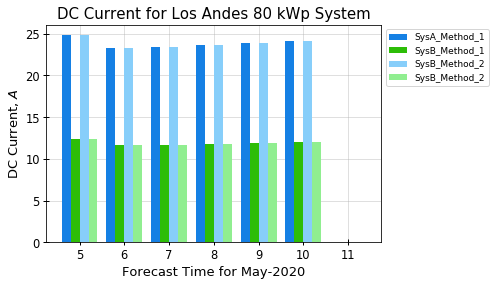

In [54]:
#DC Current Plot
plt.style.use('fast')

plt.bar(r1, scaled_results_DS_SysA['i_mp'], bar_width, label='SysA_Method_1', color='#1580E4');
plt.bar(r2, scaled_results_DS_SysB['i_mp'], bar_width, label='SysB_Method_1', color='#2DBD07');

plt.bar(r3, sc_max_SysA['i_mp'], bar_width, label='SysB_Method_2', color='lightskyblue');
plt.bar(r4, sc_max_SysB['i_mp'], bar_width, label='SysB_Method_2', color='lightgreen');

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Current for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('DC Current, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5, labelsize=11.5)

plt.xticks(x + bar_width + bar_width/2, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('DC_Current_Manual.eps', bbox_inches='tight')

#Description of the Results
sgr_DC_current = list(zip(int_days, scaled_results_DS_SysA['i_mp'], scaled_results_DS_SysB['i_mp'],
                          sc_max_SysA['i_mp'], sc_max_SysB['i_mp']));
sgr_DC_current = pd.DataFrame(sgr_DC_current, columns=['Day', 'SysA_Method_1', 'SysB_Method_1',
                                                       'SysA_Method_2', 'SysB_Method_2']);
sgr_DC_current = sgr_DC_current.round(1);
sgr_DC_current

### 6.3. DC POWER

,Day,SysA_Method_1,SysB_Method_1,Total_Method_1,SysA_Method_2,SysB_Method_2,Total_Method_2
0,5,15.8,8.9,24.7,15.8,8.9,24.7
1,6,14.9,8.4,23.3,14.9,8.4,23.3
2,7,15.0,8.5,23.5,15.0,8.5,23.5
3,8,15.1,8.5,23.6,15.1,8.5,23.6
4,9,15.3,8.6,23.9,15.3,8.6,23.9
5,10,15.2,8.6,23.8,15.4,8.7,24.1
6,11,0.0,0.0,0.0,0.0,0.0,0.0


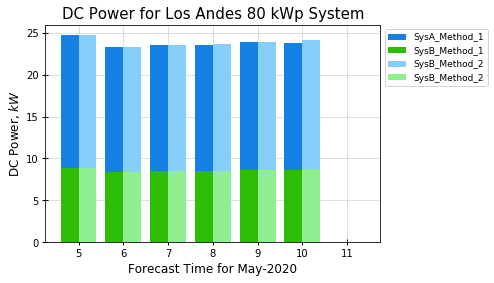

In [55]:
kilo = 1e3;
width = 0.4; #With for Stacked Bar Plots

#DC Power Plot
plt.style.use('fast')

plt.bar(r1, scaled_results_DS_SysA['p_mp']/kilo, width, label='SysA_Method_1', color='#1580E4', bottom=scaled_results_DS_SysB['p_mp']/kilo);
plt.bar(r1, scaled_results_DS_SysB['p_mp']/kilo, width, label='SysB_Method_1', color='#2DBD07');

plt.bar(r3, sc_max_SysA['p_mp']/kilo, width, label='SysB_Method_2', color='lightskyblue', bottom=sc_max_SysB['p_mp']/kilo);
plt.bar(r3, sc_max_SysB['p_mp']/kilo, width, label='SysB_Method_2', color='lightgreen');

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Power for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('DC Power, $kW$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width/2, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('DC_Power_Manual.eps', bbox_inches='tight')

#Description of the Results
DC_power_sum_method_1 = scaled_results_DS_SysA['p_mp']/kilo + scaled_results_DS_SysB['p_mp']/kilo
DC_power_sum_method_2 = sc_max_SysA['p_mp']/kilo + sc_max_SysB['p_mp']/kilo

scaled_global_DC_results = list(zip(int_days, scaled_results_DS_SysA['p_mp']/kilo, scaled_results_DS_SysB['p_mp']/kilo, 
                                    DC_power_sum_method_1, sc_max_SysA['p_mp']/kilo, sc_max_SysB['p_mp']/kilo, 
                                    DC_power_sum_method_2));
scaled_global_DC_results = pd.DataFrame(scaled_global_DC_results, columns=['Day', 'SysA_Method_1', 'SysB_Method_1',
                                                                           'Total_Method_1', 'SysA_Method_2',
                                                                           'SysB_Method_2', 'Total_Method_2']);
scaled_global_DC_results = scaled_global_DC_results.round(1);
scaled_global_DC_results

### 6.4. AC POWER
Here is applied the ```pvsystem.snlinverter``` method in order to converts DC power and voltage to AC power using Sandia’s Grid-Connected PV Inverter model.

The ```pvsystem.snlinverter``` method determines the AC power output of an inverter given the DC voltage, DC power, and appropriate Sandia Grid-Connected Photovoltaic Inverter Model parameters. The output, ac_power, is clipped at the maximum power output, and gives a negative power during low-input power conditions, but does NOT account for maximum power point tracking voltage windows nor maximum current or voltage limits on the inverter.

More info at: https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.pvsystem.snlinverter.html.

___
**Note:** To get the information of a function, add at the end of the line code ```??```, i.e.:
```python
pvlib.pvsystem.snlinverter??
```
___

,Day,SysA_Method_1,SysB_Method_1,Total_Method_1,SysA_Method_2,SysB_Method_2,Total_Method_2
0,5,15.5,8.7,24.2,15.5,8.7,24.2
1,6,14.6,8.2,22.8,14.6,8.2,22.8
2,7,14.7,8.3,23.0,14.7,8.3,23.0
3,8,14.8,8.3,23.1,14.8,8.3,23.1
4,9,15.0,8.4,23.4,15.0,8.4,23.4


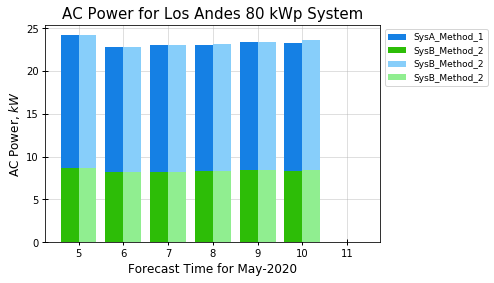

In [56]:
Pot_AC_SysA_method_1 = pvlib.pvsystem.snlinverter(scaled_results_DS_SysA['v_mp'], scaled_results_DS_SysA['p_mp'], 
                                         inverter_A)/kilo;
Pot_AC_SysB_method_1 = pvlib.pvsystem.snlinverter(scaled_results_DS_SysB['v_mp'], scaled_results_DS_SysB['p_mp'], 
                                                  inverter_B)/kilo;

Pot_AC_SysA_method_2 = pvlib.pvsystem.snlinverter(sc_max_SysA['v_mp'], sc_max_SysA['p_mp'], inverter_A)/kilo;
Pot_AC_SysB_method_2 = pvlib.pvsystem.snlinverter(sc_max_SysB['v_mp'], sc_max_SysB['p_mp'], inverter_B)/kilo;

#AC Power Plot
plt.style.use('fast')

plt.bar(r1, Pot_AC_SysA_method_1, width, label='SysA_Method_1', color='#1580E4', bottom=Pot_AC_SysB_method_1);
plt.bar(r1, Pot_AC_SysB_method_1, width, label='SysB_Method_2', color='#2DBD07');

plt.bar(r3, Pot_AC_SysA_method_2, width, label='SysB_Method_2', color='lightskyblue', bottom=Pot_AC_SysB_method_2);
plt.bar(r3, Pot_AC_SysB_method_2, width, label='SysB_Method_2', color='lightgreen');

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('AC Power for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('AC Power, $kW$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width/2, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('AC_Power_Manual.eps', bbox_inches='tight')

#Description of the Results
AC_power_sum_method_1 = Pot_AC_SysA_method_1 + Pot_AC_SysB_method_1
AC_power_sum_method_2 = Pot_AC_SysA_method_2 + Pot_AC_SysB_method_2

scaled_global_AC_results = list(zip(int_days, Pot_AC_SysA_method_1, Pot_AC_SysB_method_1, AC_power_sum_method_1,
                                    Pot_AC_SysA_method_2, Pot_AC_SysB_method_2, AC_power_sum_method_2));
scaled_global_AC_results = pd.DataFrame(scaled_global_AC_results, columns=['Day', 'SysA_Method_1', 'SysB_Method_1',
                                                                           'Total_Method_1', 'SysA_Method_2',
                                                                           'SysB_Method_2', 'Total_Method_2']);
scaled_global_AC_results = scaled_global_AC_results.round(1);
scaled_global_AC_results.head()

### 6.5. DC vs. AC POWER COMPARISON

,Stat,Sys_A,Sys_B
0,Slope,0.9852,0.9827
1,Intercept,-0.0861,-0.0541
2,r_value,1.0000,1.0000
3,Std. Error,0.0014,0.0034


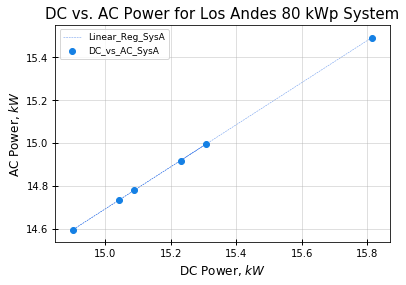

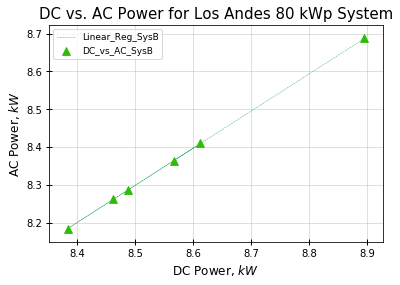

In [57]:
#Deleting (0,0) Values (Last Row of DataFrame)
x_SysA = scaled_results_DS_SysA[:-1]/kilo
y_SysA = Pot_AC_SysA_method_1[:-1]

x_SysB = scaled_results_DS_SysB[:-1]/kilo
y_SysB = Pot_AC_SysB_method_1[:-1]

#Least Squares Linear Regression
coef_SysA = np.polyfit(x_SysA['p_mp'], y_SysA, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

coef_SysB = np.polyfit(x_SysB['p_mp'], y_SysB, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

#Scipy Stats
from scipy import stats

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_SysA['p_mp'], y_SysA)
slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_SysB['p_mp'], y_SysB)

data_descrip = ['Slope', 'Intercept', 'r_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, std_err_SysA]
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, std_err_SysB]

stat_sysA = list(zip(data_descrip, data_result_SysA, data_result_SysB));
stat_sysA = pd.DataFrame(stat_sysA, columns=['Stat', 'Sys_A', 'Sys_B']);
stat_sysA = stat_sysA.round(4);

#DC vs. AC Power Plot
plt.style.use('fast')

fig1, ax1 = plt.subplots()

plt.plot(x_SysA['p_mp'], poly1d_fn_SysA(x_SysA['p_mp']), '--k',
         label='Linear_Reg_SysA', color='cornflowerblue', linewidth=0.5, zorder = 0)

plt.scatter(x_SysA['p_mp'], y_SysA, label='DC_vs_AC_SysA', color='#1580E4', zorder = 10);

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC vs. AC Power for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('AC Power, $kW$', fontname="Helvetica", fontsize=12);
plt.xlabel('DC Power, $kW$', fontname="Helvetica", fontsize=12);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('DC_vs_AC_Manual_SysA.eps', bbox_inches='tight')

fig2, ax2 = plt.subplots()

plt.plot(x_SysB['p_mp'], poly1d_fn_SysB(x_SysB['p_mp']), '--k',
         label='Linear_Reg_SysB', color='mediumseagreen', linewidth=0.5, zorder = 5)

plt.scatter(x_SysB['p_mp'], y_SysB, label='DC_vs_AC_SysB', color='#2DBD07', marker='^', s=60, zorder = 15);

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC vs. AC Power for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('AC Power, $kW$', fontname="Helvetica", fontsize=12);
plt.xlabel('DC Power, $kW$', fontname="Helvetica", fontsize=12);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('DC_vs_AC_Manual_SysB.eps', bbox_inches='tight')
stat_sysA.head()

### 6.6. MODULE TEMPERATURE
This is taken from the Section 4.7.

,Day,Temp. Module
0,5,29.7
1,6,28.2
2,7,26.9
3,8,28.4
4,9,27.3


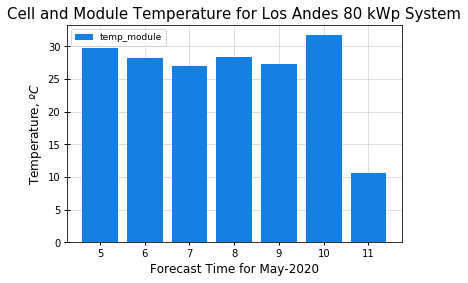

In [58]:
# Module Temperature Plot
plt.style.use('fast')

plt.bar(x, max_temp_cell, label='temp_module', color='#1580E4');

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Cell and Module Temperature for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('Temperature, $ºC$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Module_Temperature.eps', bbox_inches='tight')

# Description of the Results
temp_module_results = list(zip(int_days, max_temp_cell));
temp_module_results = pd.DataFrame(temp_module_results, columns=['Day', 'Temp. Module']);
temp_module_results = temp_module_results.round(1);
temp_module_results.head()

### 6.7. ENERGY
In order to get easier the value of the daily energy, the ***Method 2*** is applied and then the function ```pvsystem.snlinverter``` is used in order to get a *'continuous'* data of AC power during each day (and not only the maximum value as stated with ***Method 1***).

In [59]:
#Continuos Calculus of AC Power for Both Systems at Los Andes University
cont_ACPow_SysA = pvsystem.snlinverter(sc_SysA['v_mp'], sc_SysA['p_mp'], inverter_A)/kilo;
cont_ACPow_SysB = pvsystem.snlinverter(sc_SysB['v_mp'], sc_SysB['p_mp'], inverter_B)/kilo;

___
**Note:** When AC power is less than the startup power required ($P_{s0}$ as parametrically stated by PVLIB-Python), then the function ```pvsystem.snlinverter``` set the variable AC power to $\: -1 \cdot |P_{nt}|\:$ to represent nightly power losses.

If the user considers this ot truly relevant, with the code snipped below can change those negative values to zero.

```python
d = {-1:0}
cont_ACPow_SysA = cont_ACPow_SysA.replace(d)
cont_ACPow_SysA.head()
```
___

In [60]:
#Detailed AC Power

#SysA
detailed_ACPow_SysA = pd.DataFrame(cont_ACPow_SysA, columns=['AC_Power'])
detailed_ACPow_SysA['Day'] = detailed_ACPow_SysA.index.day
detailed_ACPow_SysA['Hour'] = detailed_ACPow_SysA.index.hour
detailed_ACPow_SysA = detailed_ACPow_SysA[['Day', 'Hour', 'AC_Power']]

#SysB
detailed_ACPow_SysB = pd.DataFrame(cont_ACPow_SysB, columns=['AC_Power'])
detailed_ACPow_SysB['Day'] = detailed_ACPow_SysB.index.day
detailed_ACPow_SysB['Hour'] = detailed_ACPow_SysB.index.hour
detailed_ACPow_SysB = detailed_ACPow_SysB[['Day', 'Hour', 'AC_Power']]

#Daily Total AC Power
daily_total_ACPow_SysA = pd.DataFrame(cont_ACPow_SysA, columns=['SysA'])
daily_total_ACPow_SysB = pd.DataFrame(cont_ACPow_SysB, columns=['SysB'])

daily_total_ACPow_SysA = daily_total_ACPow_SysA.resample('1d').sum();
daily_total_ACPow_SysB = daily_total_ACPow_SysB.resample('1d').sum();

#Delta Hour (Or Hour Resolution)
delta_hour = detailed_ACPow_SysA['Hour'][1] - detailed_ACPow_SysA['Hour'][0]

#Daily Energy
daily_energy_SysA = daily_total_ACPow_SysA * delta_hour
daily_energy_SysB = daily_total_ACPow_SysB * delta_hour

de_SysA = pd.DataFrame(daily_energy_SysA)
de_SysB = pd.DataFrame(daily_energy_SysB)
daily_energy = de_SysA.join(de_SysB)
daily_energy

,SysA,SysB
Datetime,,
2020-05-05 00:00:00-05:00,115.022738,64.475798
2020-05-06 00:00:00-05:00,107.742538,60.388594
2020-05-07 00:00:00-05:00,108.961223,61.078818
2020-05-08 00:00:00-05:00,108.068793,60.569497
2020-05-09 00:00:00-05:00,108.943445,61.066370
2020-05-10 00:00:00-05:00,117.818239,66.044852
2020-05-11 00:00:00-05:00,-0.006000,-0.003660


,Day,Energy_SysA,Energy_SysB,Total_Energy
0,5,115.0,64.5,179.5
1,6,107.7,60.4,168.1
2,7,109.0,61.1,170.0
3,8,108.1,60.6,168.6
4,9,108.9,61.1,170.0


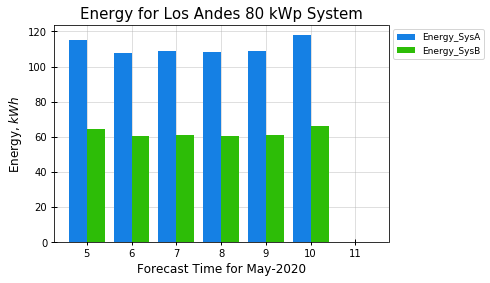

In [61]:
#Energy Plot
plt.style.use('fast')

plt.bar(r1, daily_energy['SysA'], width, label='Energy_SysA', color='#1580E4');
plt.bar(r3, daily_energy['SysB'], width, label='Energy_SysB', color='#2DBD07');

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Energy for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('Energy, $kWh$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width/2, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Energy_Manual.eps', bbox_inches='tight')

#Description of the Results
total_energy = daily_energy['SysA'] + daily_energy['SysB']

energy_results = list(zip(int_days, daily_energy['SysA'], daily_energy['SysB'], total_energy));
energy_results = pd.DataFrame(energy_results, columns=['Day', 'Energy_SysA', 'Energy_SysB',
                                                                           'Total_Energy']);
energy_results = energy_results.round(1);
energy_results.head()

___
## SECTION 7: DIFFERENT PV SYSTEM SIMULATION MODELS

This section gets through the PV system modeling by using different classes (as *ModelChain*) and also by another models (as PVSyst and PVWatts by NREL).

**RELEVANT**: Both PVSyst and PVWatts models are achieved by using the PVLIB-Python code available. Further work will compare these results with the ones by the official APIs.

___
**Note:** There will not be plots for each variable of each modeling method. At the end, all of them, including the PVLIB-Python manual modeling, will be compared.
___

Mode info about the models at: https://pvlib-python.readthedocs.io/en/latest/api.html. Also, other *open-source* tools for PV modeling at https://openpvtools.readthedocs.io/en/latest/.

### 7.1. PVLIB-Python MODELCHAIN INITIALIZATION
The ModelChain class to provides a standardized, high-level interface for all of the modeling steps necessary for calculating PV power from a time series of weather inputs.

ModelChain objects provide convenience methods that can provide default selections for models and can also fill necessary input with modeled data. For example, no air temperature or wind speed data is provided in the input weather DataFrame, so the ModelChain object defaults to 20ºC and 0 m/s. Also, if no irradiance transposition model is specified (keyword argument transposition for ModelChain), the ModelChain defaults to the *HayDavies* model.

More info at: https://cwhanse-pvlib-python.readthedocs.io/en/latest/generated/pvlib.modelchain.ModelChain.html#pvlib.modelchain.ModelChain.

##### 7.1.1. PVLIB-Python ModelChain Model Creation

In [62]:
# PVLIB-Python SysA ModelChain Object to Calculate Modeling Intermediates
pvlib_mc_SysA = pvlib.modelchain.ModelChain(system_A, 
                            location, 
                            orientation_strategy=None, #None to sets the surface_azimuth and surface_tilt properties of the system 
                            clearsky_model='ineichen', 
                            transposition_model='haydavies', 
                            solar_position_method='nrel_numpy', 
                            airmass_model='kastenyoung1989', 
                            dc_model='cec', 
                            ac_model='snlinverter', 
                            aoi_model='physical', 
                            spectral_model='first_solar', 
                            temperature_model='sapm', 
                            losses_model='no_loss', 
                            name='PVLIB_mc_SysA')

# PVLIB-Python SysB ModelChain Object to Calculate Modeling Intermediates
pvlib_mc_SysB = pvlib.modelchain.ModelChain(system_B, 
                            location, 
                            orientation_strategy=None, #None to sets the surface_azimuth and surface_tilt properties of the system 
                            clearsky_model='ineichen', 
                            transposition_model='haydavies', 
                            solar_position_method='nrel_numpy', 
                            airmass_model='kastenyoung1989', 
                            dc_model='cec', 
                            ac_model='snlinverter', 
                            aoi_model='physical', 
                            spectral_model='first_solar', 
                            temperature_model='sapm', 
                            losses_model='no_loss', 
                            name='PVLIB_mc_SysB')

##### 7.1.2. PVLIB-Python ModelChain Running
The model created above is run and return these variables:

- Solar Position
- Airmass
- Irradiance
- Total Irradiance
- Effective Irradiance
- Weather
- Cell Temperature
- Angle of Incidence (AOI)
- Angle of Incidence Modifiers
- Spectral Modifier (Spectral Mismatch)
- Single Diode Parameters
- DC Variables
- AC Variables
- Losses
___
**Note:** Since the ```spectral_model``` is *first_solar* (as Section 4.9.3), it is required that the precipitable water data be annexed **<ins>IN</ins>** the meteorological data DataFrame. These are the first two line codes below.
___

In [63]:
# Extract Relevant Data from ModelChain
mc_data_weather = data_weatherforecast
mc_data_weather['precipitable_water'] = pw

In [64]:
# Running the PVLIB-Python ModelChain Modeling Method
pvlib_mc_SysA.run_model(mc_data_weather.index, mc_data_weather);
pvlib_mc_SysB.run_model(mc_data_weather.index, mc_data_weather);

/Users/nelsonsasa07/opt/anaconda3/lib/python3.7/site-packages/pvlib/singlediode.py:424: RuntimeWarning: invalid value encountered in greater
  idx_p = 0. < Gsh
/Users/nelsonsasa07/opt/anaconda3/lib/python3.7/site-packages/pvlib/tools.py:411: RuntimeWarning: invalid value encountered in greater
  df['SW_Flag'] = df['f1'] > df['f2']
/Users/nelsonsasa07/opt/anaconda3/lib/python3.7/site-packages/pvlib/tools.py:418: RuntimeWarning: invalid value encountered in greater
  errflag = (abs(err) > .01).any()


##### 7.1.3. PVLIB-Python ModelChain DC Model Maximum Values

In [65]:
#PVSyst DC Power Values
pvlib_mc_dc_SysA = pvlib_mc_SysA.dc;
pvlib_mc_dc_SysB = pvlib_mc_SysB.dc;

# Max. DC Power Values of Scalated Data for SysA
pvlib_max_mc_DCpmp_SysA = pvlib_mc_dc_SysA.resample('1d').max();

pvlib_max_mc_DCpmp_SysA = pd.DataFrame(pvlib_max_mc_DCpmp_SysA, columns=['p_mp']);
pvlib_max_mc_DCpmp_SysA = pvlib_max_mc_DCpmp_SysA.round(2);

# Max. DC Power Values of Scalated Data for SysB
pvlib_max_mc_DCpmp_SysB = pvlib_mc_dc_SysB.resample('1d').max();

pvlib_max_mc_DCpmp_SysB = pd.DataFrame(pvlib_max_mc_DCpmp_SysB, columns=['p_mp']);
pvlib_max_mc_DCpmp_SysB = pvlib_max_mc_DCpmp_SysB.round(2);
pvlib_max_mc_DCpmp_SysB.head()

,p_mp
2020-05-05 00:00:00-05:00,10184.07
2020-05-06 00:00:00-05:00,9492.84
2020-05-07 00:00:00-05:00,9517.86
2020-05-08 00:00:00-05:00,9483.35
2020-05-09 00:00:00-05:00,9482.30


##### 7.1.4. PVLIB-Python ModelChain AC Model Maximum Values

In [66]:
#PVSyst AC Power Values
pvlib_mc_ac_SysA = pvlib_mc_SysA.ac;
pvlib_mc_ac_SysB = pvlib_mc_SysB.ac;

# Max. AC Power Values of Scalated Data for SysA
pvlib_max_mc_ACpmp_SysA = pvlib_mc_ac_SysA.resample('1d').max();

pvlib_max_mc_ACpmp_SysA = pd.DataFrame(pvlib_max_mc_ACpmp_SysA, columns=['p_mp']);
pvlib_max_mc_ACpmp_SysA = pvlib_max_mc_ACpmp_SysA.round(2);

# Max. AC Power Values of Scalated Data for SysB
pvlib_max_mc_ACpmp_SysB = pvlib_mc_ac_SysB.resample('1d').max();

pvlib_max_mc_ACpmp_SysB = pd.DataFrame(pvlib_max_mc_ACpmp_SysB, columns=['p_mp']);
pvlib_max_mc_ACpmp_SysB = pvlib_max_mc_ACpmp_SysB.round(2);
pvlib_max_mc_ACpmp_SysB.head()

,p_mp
2020-05-05 00:00:00-05:00,9961.76
2020-05-06 00:00:00-05:00,9281.67
2020-05-07 00:00:00-05:00,9307.20
2020-05-08 00:00:00-05:00,9272.74
2020-05-09 00:00:00-05:00,9271.92


##### 7.1.5. PVLIB-Python ModelChain Energy

In [67]:
# Daily Total AC Power
pvlib_daily_total_ACPow_SysA = pd.DataFrame(pvlib_mc_ac_SysA, columns=['SysA'])
pvlib_daily_total_ACPow_SysB = pd.DataFrame(pvlib_mc_ac_SysB, columns=['SysB'])

pvlib_daily_total_ACPow_SysA = pvlib_daily_total_ACPow_SysA.resample('1d').sum();
pvlib_daily_total_ACPow_SysB = pvlib_daily_total_ACPow_SysB.resample('1d').sum();

# Daily Energy
pvlib_daily_energy_SysA = pvlib_daily_total_ACPow_SysA * delta_hour
pvlib_daily_energy_SysB = pvlib_daily_total_ACPow_SysB * delta_hour

pvlib_de_SysA = pd.DataFrame(pvlib_daily_energy_SysA)
pvlib_de_SysB = pd.DataFrame(pvlib_daily_energy_SysB)
pvlib_daily_energy = pvlib_de_SysA.join(pvlib_de_SysB)
pvlib_daily_energy

,SysA,SysB
2020-05-05 00:00:00-05:00,126009.883132,70669.589357
2020-05-06 00:00:00-05:00,116742.410731,65464.129069
2020-05-07 00:00:00-05:00,117709.992128,66013.166503
2020-05-08 00:00:00-05:00,116304.324833,65215.556135
2020-05-09 00:00:00-05:00,116615.641152,65395.616907
2020-05-10 00:00:00-05:00,127564.495431,71541.079307
2020-05-11 00:00:00-05:00,-6.000000,-3.660000


### 7.2. PVSyst MODELCHAIN INITIALIZATION
As stated above, the ModelChain class to provides a standardized, high-level interface for all of the modeling steps necessary for calculating PV power from a time series of weather inputs.

PVLIB-Python provides two main function of PVSyst model: (i.) ```pvlib.temperature.pvsyst_cell``` to obtain, by calculis, the cell temperature using an empirical heat loss factor model as implemented in **PVsyst**;  and (ii.) ```pvlib.pvsystem.calcparams_pvsyst``` to calculate five parameter values for the *Single Diode* equation at effective irradiance and cell temperature using the PVsyst V6 model. Those five values returned by ```calcparams_pvsyst``` function are used to get the I-V curve.

These two functions are run in the *ModelChain* class by setting the *ModelChain* parameters ```dc_model``` and ```temperature_model``` as ```'pvsyst'```, as shown below.

More info about ```pvlib.pvsystem.calcparams_pvsyst``` function at: https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.calcparams_pvsyst.html#pvlib.pvsystem.calcparams_pvsyst.

More info about ```pvlib.temperature.pvsyst_cell``` function at: https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.temperature.pvsyst_cell.html#pvlib.temperature.pvsyst_cell.

##### 7.2.1. PVSyst ModelChain Model Creation

In [68]:
calcparams_pvsyst_sysA = pvsystem.calcparams_pvsyst(effective_irrad_calc,
                                                     pvtemps['temp_cell'],
                                                     module['alpha_sc'],
                                                     module['gamma_ref'], #Diode Quality Factor, Value from PVSyst
                                                     module['mu_gamma'], #PVSyst specify that mono-cSi modules mu_gamma is very close to zero
                                                     I_L_ref=module['I_L_ref'],
                                                     I_o_ref=module['I_o_ref'],
                                                     R_sh_ref=module['R_sh_ref'],
                                                     R_sh_0=module['R_sh_0'], #Resistance shunt at 0 irrad., Value from PVSyst
                                                     R_s=module['R_s'],
                                                     cells_in_series=module['N_s'],
                                                     R_sh_exp=module['R_sh_exp'],
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     irrad_ref=1000, #Retrieved from last link at above description
                                                     temp_ref=25) #Retrieved from last link at above description

In [69]:
# PVSyst SysA ModelChain Object to Calculate Modeling Intermediates
pvsyst_mc_SysA = pvlib.modelchain.ModelChain(system_A, 
                            location, 
                            orientation_strategy=None, #None to sets the surface_azimuth and surface_tilt properties of the system 
                            clearsky_model='ineichen', 
                            transposition_model='haydavies', 
                            solar_position_method='nrel_numpy', 
                            airmass_model='kastenyoung1989', 
                            dc_model='pvsyst', 
                            ac_model='snlinverter', 
                            aoi_model='physical', 
                            spectral_model='first_solar', 
                            temperature_model='pvsyst', 
                            losses_model='no_loss', 
                            name='PVSyst_mc_SysA')

# PVSyst SysB ModelChain Object to Calculate Modeling Intermediates
pvsyst_mc_SysB = pvlib.modelchain.ModelChain(system_B, 
                            location, 
                            orientation_strategy=None, #None to sets the surface_azimuth and surface_tilt properties of the system 
                            clearsky_model='ineichen', 
                            transposition_model='haydavies', 
                            solar_position_method='nrel_numpy', 
                            airmass_model='kastenyoung1989', 
                            dc_model='pvsyst', 
                            ac_model='snlinverter', 
                            aoi_model='physical', 
                            spectral_model='first_solar', 
                            temperature_model='pvsyst', 
                            losses_model='no_loss', 
                            name='PVSyst_mc_SysB')

##### 7.2.2. PVSyst ModelChain Running
The model created above is run and return these variables:

- Solar Position
- Airmass
- Irradiance
- Total Irradiance
- Effective Irradiance
- Weather
- Cell Temperature
- Angle of Incidence (AOI)
- Angle of Incidence Modifiers
- Spectral Modifier (Spectral Mismatch)
- Single Diode Parameters
- DC Variables
- AC Variables
- Losses
___
**Note:** Since the ```spectral_model``` is *first_solar* (as Section 4.9.3), it is required that the precipitable water data be annexed **<ins>IN</ins>** the meteorological data DataFrame. These are the first two line codes below.
___

In [70]:
# Running the PVSyst ModelChain Modeling Method
pvsyst_mc_SysA.run_model(mc_data_weather.index, mc_data_weather);
pvsyst_mc_SysB.run_model(mc_data_weather.index, mc_data_weather);

/Users/nelsonsasa07/opt/anaconda3/lib/python3.7/site-packages/pvlib/singlediode.py:424: RuntimeWarning: invalid value encountered in greater
  idx_p = 0. < Gsh
/Users/nelsonsasa07/opt/anaconda3/lib/python3.7/site-packages/pvlib/tools.py:411: RuntimeWarning: invalid value encountered in greater
  df['SW_Flag'] = df['f1'] > df['f2']
/Users/nelsonsasa07/opt/anaconda3/lib/python3.7/site-packages/pvlib/tools.py:418: RuntimeWarning: invalid value encountered in greater
  errflag = (abs(err) > .01).any()


##### 7.2.3. PVSyst DC Model Maximum Values

In [71]:
#PVSyst DC Power Values
pvsyst_mc_dc_SysA = pvsyst_mc_SysA.dc;
pvsyst_mc_dc_SysB = pvsyst_mc_SysB.dc;

# Max. DC Power Values of Scalated Data for SysA
pvsyst_max_mc_DCpmp_SysA = pvsyst_mc_dc_SysA.resample('1d').max();

pvsyst_max_mc_DCpmp_SysA = pd.DataFrame(pvsyst_max_mc_DCpmp_SysA, columns=['p_mp']);
pvsyst_max_mc_DCpmp_SysA = pvsyst_max_mc_DCpmp_SysA.round(2);

# Max. DC Power Values of Scalated Data for SysB
pvsyst_max_mc_DCpmp_SysB = pvsyst_mc_dc_SysB.resample('1d').max();

pvsyst_max_mc_DCpmp_SysB = pd.DataFrame(pvsyst_max_mc_DCpmp_SysB, columns=['p_mp']);
pvsyst_max_mc_DCpmp_SysB = pvsyst_max_mc_DCpmp_SysB.round(2);
pvsyst_max_mc_DCpmp_SysB.head()

,p_mp
2020-05-05 00:00:00-05:00,10454.57
2020-05-06 00:00:00-05:00,9740.54
2020-05-07 00:00:00-05:00,9759.19
2020-05-08 00:00:00-05:00,9728.15
2020-05-09 00:00:00-05:00,9725.05


##### 7.2.4. PVSyst AC Model Maximum Values

In [72]:
#PVSyst AC Power Values
pvsyst_mc_ac_SysA = pvsyst_mc_SysA.ac;
pvsyst_mc_ac_SysB = pvsyst_mc_SysB.ac;

# Max. AC Power Values of Scalated Data for SysA
pvsyst_max_mc_ACpmp_SysA = pvsyst_mc_ac_SysA.resample('1d').max();

pvsyst_max_mc_ACpmp_SysA = pd.DataFrame(pvsyst_max_mc_ACpmp_SysA, columns=['p_mp']);
pvsyst_max_mc_ACpmp_SysA = pvsyst_max_mc_ACpmp_SysA.round(2);

# Max. AC Power Values of Scalated Data for SysB
pvsyst_max_mc_ACpmp_SysB = pvsyst_mc_ac_SysB.resample('1d').max();

pvsyst_max_mc_ACpmp_SysB = pd.DataFrame(pvsyst_max_mc_ACpmp_SysB, columns=['p_mp']);
pvsyst_max_mc_ACpmp_SysB = pvsyst_max_mc_ACpmp_SysB.round(2);
pvsyst_max_mc_ACpmp_SysB.head()

,p_mp
2020-05-05 00:00:00-05:00,10234.66
2020-05-06 00:00:00-05:00,9531.78
2020-05-07 00:00:00-05:00,9550.96
2020-05-08 00:00:00-05:00,9519.82
2020-05-09 00:00:00-05:00,9517.08


##### 7.2.5. PVSyst Energy

In [73]:
# Daily Total AC Power
pvsyst_daily_total_ACPow_SysA = pd.DataFrame(pvsyst_mc_ac_SysA, columns=['SysA'])
pvsyst_daily_total_ACPow_SysB = pd.DataFrame(pvsyst_mc_ac_SysB, columns=['SysB'])

pvsyst_daily_total_ACPow_SysA = pvsyst_daily_total_ACPow_SysA.resample('1d').sum();
pvsyst_daily_total_ACPow_SysB = pvsyst_daily_total_ACPow_SysB.resample('1d').sum();

# Daily Energy
pvsyst_daily_energy_SysA = pvsyst_daily_total_ACPow_SysA * delta_hour
pvsyst_daily_energy_SysB = pvsyst_daily_total_ACPow_SysB * delta_hour

pvsyst_de_SysA = pd.DataFrame(pvsyst_daily_energy_SysA)
pvsyst_de_SysB = pd.DataFrame(pvsyst_daily_energy_SysB)
pvsyst_daily_energy = pvsyst_de_SysA.join(pvsyst_de_SysB)
pvsyst_daily_energy

,SysA,SysB
2020-05-05 00:00:00-05:00,129321.588669,72559.861635
2020-05-06 00:00:00-05:00,119748.193468,67182.194865
2020-05-07 00:00:00-05:00,120651.239314,67694.152455
2020-05-08 00:00:00-05:00,119335.395937,66947.694863
2020-05-09 00:00:00-05:00,119572.185855,67085.513284
2020-05-10 00:00:00-05:00,130985.534802,73492.948279
2020-05-11 00:00:00-05:00,-6.000000,-3.660000


### 7.3. PVWatts MANUAL INITIALIZATION (with Losses)
PVLIB-Python provides three main function of PVWatts model: 
- First, ```pvsystem.pvwatts_dc``` implements NREL' PVWatts DC power model. It is truly relevant to make explicit that **$P_{dc0}$ refers to the DC power of the modules at reference conditions <ins>in this unique function</ins>**. The PVWatts DC power model is:

$$P_{dc} = \frac{G_{POA_{Eff}}}{1000} \: P_{dc0} \: \left[1 + \gamma_{pdc} \: \left(T_{cell} - T_{ref} \right)\right]$$

___
**Note:** To be fully consistent with PVWatts, the user must have already applied angle of incidence losses, **<ins>but not</ins>** soiling, spectral, etc.
___

- Next, ```pvsystem.pvwatts_ac``` implements NREL’s PVWatts inverter model. It is truly relevant to make explicit that **$P_{dc0}$ refers to the DC power input limit of the inverter <ins>in this unique function</ins>**. The PVWatts AC power model is:

$$\eta = \frac{\eta_{nom}}{\eta_{ref}} \: \left( −0.0162 \: \zeta - \frac{0.0059}{\zeta} + 0.9858 \right)$$

$$P_{ac} = \text{min} \: (\eta P_{dc}, P_{ac0})$$

$$\zeta = \frac{P_{dc}}{P_{dc0}}$$

$$P_{dc0} = \frac{P_{ac0}}{\eta_{nom}}$$

- Finally, ```pvsystem.pvwatts_losses``` implements NREL’s PVWatts system loss model. It is truly relevant to make explicit that **all parameters must be in units of percentage (%)**. The PVWatts loss model is:

$$L_{total} \: (\%) \: = 100 \: \left[1 - \prod{}{}  _i \: \left(1 - \frac{L_i}{100} \right) \right]$$

___
**Note:** The ```pvsystem.pvwatts_losses``` function stated default values for the input parameters. This could be an error source if the user does not count with those values. But, in order to have a complete analysis, it will be simulated the model with and withoud losses (the no-losses analysis will be more comparable with the PVLIB-Python and PVSyst models stuied because for them the system losses were not taken into account, just meterological effectiveness without losses due to environment).
___

More info about ```pvsystem.pvwatts_dc``` function at: https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.pvwatts_dc.html.

More info about ```pvsystem.pvwatts_ac``` function at: https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.pvwatts_ac.html#pvlib.pvsystem.pvwatts_ac.

More info about ```pvsystem.pvwatts_losses``` function at: https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.pvwatts_losses.html.

##### 7.3.1. PVWatts Losses Model

In [74]:
losses = pvlib.pvsystem.pvwatts_losses(soiling=2, shading=3, snow=0, mismatch=2, 
                                               wiring=2, connections=0.5, lid=1.5, 
                                               nameplate_rating=1, age=0, availability=3);

pvwatts_losses = losses/100;

##### 7.3.2. PVWatts DC Model Creation, Scalation and Losses Decrease

In [75]:
#Variables Required for PVWatts_DC Function
eta_inv_nom = 0.98184; #CEC Weighted Efficiency, Value from PVWatts API
eta_inv_ref=0.986; #Value from PVWatts API

pdc0_inv = 50881.8; #Value from PVWatts API

#PVWatts DC Model
pvwatts_dc_model = pvsystem.pvwatts_dc(g_poa_effective=total_irrad['poa_global'], 
                                       temp_cell=pvtemps['temp_cell'], 
                                       pdc0=module['pdc0'], 
                                       gamma_pdc=module['gamma_pdc'], 
                                       temp_ref=25.0)

#Scalating PVWatts DC Model Results
pvwatts_dc_model_SysA = pvwatts_dc_model*mps_SysA*spi_SysA; #Scalated DC Power for SysA
pvwatts_dc_model_SysB = pvwatts_dc_model*mps_SysB*spi_SysB; #Scalated DC Power for SysB

#Decrease Due to Losses
pvwatts_dc_model_SysA = pvwatts_dc_model_SysA - (pvwatts_dc_model_SysA*pvwatts_losses); #DC Power for SysA with Losses
pvwatts_dc_model_SysB = pvwatts_dc_model_SysB - (pvwatts_dc_model_SysB*pvwatts_losses); #DC Power for SysA with Losses

##### 7.3.3. PVWatts DC Model Maximum Values

In [76]:
# Max. DC Power Values of Scalated Data for SysA
pvwatts_max_DCpmp_SysA = pvwatts_dc_model_SysA.resample('1d').max();

pvwatts_max_DCpmp_SysA = pd.DataFrame(pvwatts_max_DCpmp_SysA, columns=['p_mp']);
pvwatts_max_DCpmp_SysA = pvwatts_max_DCpmp_SysA.round(2);

# Max. DC Power Values of Scalated Data for SysB
pvwatts_max_DCpmp_SysB = pvwatts_dc_model_SysB.resample('1d').max();

pvwatts_max_DCpmp_SysB = pd.DataFrame(pvwatts_max_DCpmp_SysB, columns=['p_mp']);
pvwatts_max_DCpmp_SysB = pvwatts_max_DCpmp_SysB.round(2);
pvwatts_max_DCpmp_SysB.head()

,p_mp
2020-05-05 00:00:00-05:00,8775.56
2020-05-06 00:00:00-05:00,8204.27
2020-05-07 00:00:00-05:00,8231.98
2020-05-08 00:00:00-05:00,8199.07
2020-05-09 00:00:00-05:00,8200.30


##### 7.3.4. PVWatts AC Model Creation

In [77]:
#PVWatts AC Model
pvwatts_ac_model_SysA = pvsystem.pvwatts_ac(pdc=pvwatts_dc_model_SysA,
                                       pdc0=pdc0_inv, 
                                       eta_inv_nom=eta_inv_nom, 
                                       eta_inv_ref=eta_inv_ref)

pvwatts_ac_model_SysB = pvsystem.pvwatts_ac(pdc=pvwatts_dc_model_SysB,
                                       pdc0=pdc0_inv, 
                                       eta_inv_nom=eta_inv_nom, 
                                       eta_inv_ref=eta_inv_ref)

#Changing NaN Values from Both Arrays to Zero (To Avoid Setbacks)
pvwatts_ac_model_SysA = pvwatts_ac_model_SysA.fillna(0);
pvwatts_ac_model_SysB = pvwatts_ac_model_SysB.fillna(0);

##### 7.3.5. PVWatts AC Model Maximum Values

In [78]:
# Max. AC Power Values of Scalated Data for SysA
pvwatts_max_ACpmp_SysA = pvwatts_ac_model_SysA.resample('1d').max();

pvwatts_max_ACpmp_SysA = pd.DataFrame(pvwatts_max_ACpmp_SysA, columns=['p_mp']);
pvwatts_max_ACpmp_SysA = pvwatts_max_ACpmp_SysA.round(2);

# Max. AC Power Values of Scalated Data for SysB
pvwatts_max_ACpmp_SysB = pvwatts_ac_model_SysB.resample('1d').max();

pvwatts_max_ACpmp_SysB = pd.DataFrame(pvwatts_max_ACpmp_SysB, columns=['p_mp']);
pvwatts_max_ACpmp_SysB = pvwatts_max_ACpmp_SysB.round(2);
pvwatts_max_ACpmp_SysA.head()

,p_mp
2020-05-05 00:00:00-05:00,14938.47
2020-05-06 00:00:00-05:00,13951.21
2020-05-07 00:00:00-05:00,13999.12
2020-05-08 00:00:00-05:00,13942.23
2020-05-09 00:00:00-05:00,13944.35


##### 7.3.6. PVWatts Manual with Losses Energy

In [79]:
# Daily Total AC Power
pwmle_daily_total_ACPow_SysA = pd.DataFrame(pvwatts_ac_model_SysA, columns=['SysA'])
pwmle_daily_total_ACPow_SysB = pd.DataFrame(pvwatts_ac_model_SysB, columns=['SysB'])

pwmle_daily_total_ACPow_SysA = pwmle_daily_total_ACPow_SysA.resample('1d').sum();
pwmle_daily_total_ACPow_SysB = pwmle_daily_total_ACPow_SysB.resample('1d').sum();

# Daily Energy
pwmle_daily_energy_SysA = pwmle_daily_total_ACPow_SysA * delta_hour
pwmle_daily_energy_SysB = pwmle_daily_total_ACPow_SysB * delta_hour

pwmle_de_SysA = pd.DataFrame(pwmle_daily_energy_SysA)
pwmle_de_SysB = pd.DataFrame(pwmle_daily_energy_SysB)
pwmle_daily_energy = pwmle_de_SysA.join(pwmle_de_SysB)
pwmle_daily_energy

,SysA,SysB
2020-05-05 00:00:00-05:00,105887.012738,58495.199777
2020-05-06 00:00:00-05:00,98308.904018,54217.692447
2020-05-07 00:00:00-05:00,99164.268654,54700.235140
2020-05-08 00:00:00-05:00,97934.309420,54006.361309
2020-05-09 00:00:00-05:00,98236.428214,54176.765221
2020-05-10 00:00:00-05:00,107157.261845,59210.409562
2020-05-11 00:00:00-05:00,0.000000,0.000000


### 7.4. PVWatts MODELCHAIN INITIALIZATION (with Losses)
As stated before, the ModelChain class to provides a standardized, high-level interface for all of the modeling steps necessary for calculating PV power from a time series of weather inputs.

##### 7.4.1. PVWatts ModelChain Model Creation

In [80]:
# PVSyst SysA ModelChain Object to Calculate Modeling Intermediates
pvwatts_losses_mc_SysA = pvlib.modelchain.ModelChain(system_A, 
                            location, 
                            orientation_strategy=None, #None to sets the surface_azimuth and surface_tilt properties of the system 
                            clearsky_model='ineichen', 
                            transposition_model='haydavies', 
                            solar_position_method='nrel_numpy', 
                            airmass_model='kastenyoung1989', 
                            dc_model='pvwatts', 
                            ac_model='pvwatts', 
                            aoi_model='physical', 
                            spectral_model='first_solar', 
                            temperature_model='sapm', 
                            losses_model='pvwatts', 
                            name='PVWatts_mc_losses_SysA')

# PVSyst SysB ModelChain Object to Calculate Modeling Intermediates
pvwatts_losses_mc_SysB = pvlib.modelchain.ModelChain(system_B, 
                            location, 
                            orientation_strategy=None, #None to sets the surface_azimuth and surface_tilt properties of the system 
                            clearsky_model='ineichen', 
                            transposition_model='haydavies', 
                            solar_position_method='nrel_numpy', 
                            airmass_model='kastenyoung1989', 
                            dc_model='pvwatts', 
                            ac_model='pvwatts', 
                            aoi_model='physical', 
                            spectral_model='first_solar', 
                            temperature_model='sapm', 
                            losses_model='pvwatts', 
                            name='PVWatts_mc_losses_SysB')

##### 7.4.2. PVWatts ModelChain Running
The model created above is run and return these variables:

- Solar Position
- Airmass
- Irradiance
- Total Irradiance
- Effective Irradiance
- Weather
- Cell Temperature
- Angle of Incidence (AOI)
- Angle of Incidence Modifiers
- Spectral Modifier (Spectral Mismatch)
- Single Diode Parameters
- DC Variables
- AC Variables
- Losses
___
**Note:** Since the ```spectral_model``` is *first_solar* (as Section 4.9.3), it is required that the precipitable water data be annexed **<ins>IN</ins>** the meteorological data DataFrame. These are the first two line codes below.
___

In [81]:
# Running the PVSyst ModelChain Modeling Method
pvwatts_losses_mc_SysA.run_model(mc_data_weather.index, mc_data_weather);
pvwatts_losses_mc_SysB.run_model(mc_data_weather.index, mc_data_weather);

##### 7.4.3. PVWatts DC Power Scalation

In [82]:
#Scalating PVWatts DC Model Results
pvwatts_mc_losses_dc_SysA = pvwatts_losses_mc_SysA.dc*mps_SysA*spi_SysA; #Scalated DC Power for SysA
pvwatts_mc_losses_dc_SysB = pvwatts_losses_mc_SysB.dc*mps_SysB*spi_SysB; #Scalated DC Power for SysB

##### 7.4.4. PVWatts DC Model Maximum Values

In [83]:
# Max. DC Power Values of Scalated Data for SysA
pvwatts_max_mc_losses_DCpmp_SysA = pvwatts_mc_losses_dc_SysA.resample('1d').max();

pvwatts_max_mc_losses_DCpmp_SysA = pd.DataFrame(pvwatts_max_mc_losses_DCpmp_SysA, columns=['p_mp']);
pvwatts_max_mc_losses_DCpmp_SysA = pvwatts_max_mc_losses_DCpmp_SysA.round(2);

# Max. DC Power Values of Scalated Data for SysB
pvwatts_max_mc_losses_DCpmp_SysB = pvwatts_mc_losses_dc_SysB.resample('1d').max();

pvwatts_max_mc_losses_DCpmp_SysB = pd.DataFrame(pvwatts_max_mc_losses_DCpmp_SysB, columns=['p_mp']);
pvwatts_max_mc_losses_DCpmp_SysB = pvwatts_max_mc_losses_DCpmp_SysB.round(2);
pvwatts_max_mc_losses_DCpmp_SysB.head()

,p_mp
2020-05-05 00:00:00-05:00,10151.07
2020-05-06 00:00:00-05:00,9472.97
2020-05-07 00:00:00-05:00,9496.40
2020-05-08 00:00:00-05:00,9463.28
2020-05-09 00:00:00-05:00,9461.93


##### 7.4.5. PVWatts AC Power Scalation

In [84]:
#Scalating PVWatts DC Model Results
pvwatts_mc_losses_ac_SysA = pvwatts_losses_mc_SysA.ac*mps_SysA*spi_SysA; #Scalated DC Power for SysA
pvwatts_mc_losses_ac_SysB = pvwatts_losses_mc_SysB.ac*mps_SysB*spi_SysB; #Scalated DC Power for SysB

##### 7.4.6. PVWatts AC Model Maximum Values

In [85]:
# Max. AC Power Values of Scalated Data for SysA
pvwatts_max_mc_losses_ACpmp_SysA = pvwatts_mc_losses_ac_SysA.resample('1d').max();

pvwatts_max_mc_losses_ACpmp_SysA = pd.DataFrame(pvwatts_max_mc_losses_ACpmp_SysA, columns=['p_mp']);
pvwatts_max_mc_losses_ACpmp_SysA = pvwatts_max_mc_losses_ACpmp_SysA.round(2);

# Max. AC Power Values of Scalated Data for SysB
pvwatts_max_mc_losses_ACpmp_SysB = pvwatts_mc_losses_ac_SysB.resample('1d').max();

pvwatts_max_mc_losses_ACpmp_SysB = pd.DataFrame(pvwatts_max_mc_losses_ACpmp_SysB, columns=['p_mp']);
pvwatts_max_mc_losses_ACpmp_SysB = pvwatts_max_mc_losses_ACpmp_SysB.round(2);
pvwatts_max_mc_losses_ACpmp_SysB.head()

,p_mp
2020-05-05 00:00:00-05:00,8370.24
2020-05-06 00:00:00-05:00,7804.47
2020-05-07 00:00:00-05:00,7824.03
2020-05-08 00:00:00-05:00,7796.38
2020-05-09 00:00:00-05:00,7795.25


##### 7.4.7. PVWatts ModelChain with Losses Energy

In [86]:
# Daily Total AC Power
pwmcle_daily_total_ACPow_SysA = pd.DataFrame(pvwatts_mc_losses_ac_SysA, columns=['SysA'])
pwmcle_daily_total_ACPow_SysB = pd.DataFrame(pvwatts_mc_losses_ac_SysB, columns=['SysB'])

pwmcle_daily_total_ACPow_SysA = pwmcle_daily_total_ACPow_SysA.resample('1d').sum();
pwmcle_daily_total_ACPow_SysB = pwmcle_daily_total_ACPow_SysB.resample('1d').sum();

# Daily Energy
pwmcle_daily_energy_SysA = pwmcle_daily_total_ACPow_SysA * delta_hour
pwmcle_daily_energy_SysB = pwmcle_daily_total_ACPow_SysB * delta_hour

pwmcle_de_SysA = pd.DataFrame(pwmcle_daily_energy_SysA)
pwmcle_de_SysB = pd.DataFrame(pwmcle_daily_energy_SysB)
pwmcle_daily_energy = pwmcle_de_SysA.join(pwmcle_de_SysB)
pwmcle_daily_energy

,SysA,SysB
2020-05-05 00:00:00-05:00,105872.657538,59553.369865
2020-05-06 00:00:00-05:00,98170.909086,55221.136361
2020-05-07 00:00:00-05:00,98954.719686,55662.029823
2020-05-08 00:00:00-05:00,97816.239278,55021.634594
2020-05-09 00:00:00-05:00,98055.155200,55156.024800
2020-05-10 00:00:00-05:00,107181.912396,60289.825723
2020-05-11 00:00:00-05:00,0.000000,0.000000


### 7.5. PVWatts MODELCHAIN INITIALIZATION (without Losses)
As stated before, the ModelChain class to provides a standardized, high-level interface for all of the modeling steps necessary for calculating PV power from a time series of weather inputs.

##### 7.5.1. PVWatts ModelChain Model Creation

In [87]:
# PVSyst SysA ModelChain Object to Calculate Modeling Intermediates
pvwatts_mc_SysA = pvlib.modelchain.ModelChain(system_A, 
                            location, 
                            orientation_strategy=None, #None to sets the surface_azimuth and surface_tilt properties of the system 
                            clearsky_model='ineichen', 
                            transposition_model='haydavies', 
                            solar_position_method='nrel_numpy', 
                            airmass_model='kastenyoung1989', 
                            dc_model='pvwatts', 
                            ac_model='pvwatts', 
                            aoi_model='physical', 
                            spectral_model='first_solar', 
                            temperature_model='sapm', 
                            losses_model='no_loss', 
                            name='PVWatts_mc_SysA')

# PVSyst SysB ModelChain Object to Calculate Modeling Intermediates
pvwatts_mc_SysB = pvlib.modelchain.ModelChain(system_B, 
                            location, 
                            orientation_strategy=None, #None to sets the surface_azimuth and surface_tilt properties of the system 
                            clearsky_model='ineichen', 
                            transposition_model='haydavies', 
                            solar_position_method='nrel_numpy', 
                            airmass_model='kastenyoung1989', 
                            dc_model='pvwatts', 
                            ac_model='pvwatts', 
                            aoi_model='physical', 
                            spectral_model='first_solar', 
                            temperature_model='sapm', 
                            losses_model='no_loss', 
                            name='PVWatts_mc_SysB')

##### 7.5.2. PVWatts ModelChain Running
The model created above is run and return these variables:

- Solar Position
- Airmass
- Irradiance
- Total Irradiance
- Effective Irradiance
- Weather
- Cell Temperature
- Angle of Incidence (AOI)
- Angle of Incidence Modifiers
- Spectral Modifier (Spectral Mismatch)
- Single Diode Parameters
- DC Variables
- AC Variables
- Losses
___
**Note:** Since the ```spectral_model``` is *first_solar* (as Section 4.9.3), it is required that the precipitable water data be annexed **<ins>IN</ins>** the meteorological data DataFrame. These are the first two line codes below.
___

In [88]:
# Running the PVSyst ModelChain Modeling Method
pvwatts_mc_SysA.run_model(mc_data_weather.index, mc_data_weather);
pvwatts_mc_SysB.run_model(mc_data_weather.index, mc_data_weather);

##### 7.5.3. PVWatts DC Power Scalation

In [89]:
#Scalating PVWatts DC Model Results
pvwatts_mc_dc_SysA = pvwatts_mc_SysA.dc*mps_SysA*spi_SysA; #Scalated DC Power for SysA
pvwatts_mc_dc_SysB = pvwatts_mc_SysB.dc*mps_SysB*spi_SysB; #Scalated DC Power for SysB

##### 7.5.4. PVWatts DC Model Maximum Values

In [90]:
# Max. DC Power Values of Scalated Data for SysA
pvwatts_max_mc_DCpmp_SysA = pvwatts_mc_dc_SysA.resample('1d').max();

pvwatts_max_mc_DCpmp_SysA = pd.DataFrame(pvwatts_max_mc_DCpmp_SysA, columns=['p_mp']);
pvwatts_max_mc_DCpmp_SysA = pvwatts_max_mc_DCpmp_SysA.round(2);

# Max. DC Power Values of Scalated Data for SysB
pvwatts_max_mc_DCpmp_SysB = pvwatts_mc_dc_SysB.resample('1d').max();

pvwatts_max_mc_DCpmp_SysB = pd.DataFrame(pvwatts_max_mc_DCpmp_SysB, columns=['p_mp']);
pvwatts_max_mc_DCpmp_SysB = pvwatts_max_mc_DCpmp_SysB.round(2);
pvwatts_max_mc_DCpmp_SysB.head()

,p_mp
2020-05-05 00:00:00-05:00,10151.07
2020-05-06 00:00:00-05:00,9472.97
2020-05-07 00:00:00-05:00,9496.40
2020-05-08 00:00:00-05:00,9463.28
2020-05-09 00:00:00-05:00,9461.93


##### 7.5.5. PVWatts AC Power Scalation

In [91]:
#Scalating PVWatts DC Model Results
pvwatts_mc_ac_SysA = pvwatts_mc_SysA.ac*mps_SysA*spi_SysA; #Scalated DC Power for SysA
pvwatts_mc_ac_SysB = pvwatts_mc_SysB.ac*mps_SysB*spi_SysB; #Scalated DC Power for SysB

##### 7.5.6. PVWatts AC Model Maximum Values

In [92]:
# Max. AC Power Values of Scalated Data for SysA
pvwatts_max_mc_ACpmp_SysA = pvwatts_mc_ac_SysA.resample('1d').max();

pvwatts_max_mc_ACpmp_SysA = pd.DataFrame(pvwatts_max_mc_ACpmp_SysA, columns=['p_mp']);
pvwatts_max_mc_ACpmp_SysA = pvwatts_max_mc_ACpmp_SysA.round(2);

# Max. AC Power Values of Scalated Data for SysB
pvwatts_max_mc_ACpmp_SysB = pvwatts_mc_ac_SysB.resample('1d').max();

pvwatts_max_mc_ACpmp_SysB = pd.DataFrame(pvwatts_max_mc_ACpmp_SysB, columns=['p_mp']);
pvwatts_max_mc_ACpmp_SysB = pvwatts_max_mc_ACpmp_SysB.round(2);
pvwatts_max_mc_ACpmp_SysB.head()

,p_mp
2020-05-05 00:00:00-05:00,9741.41
2020-05-06 00:00:00-05:00,9082.96
2020-05-07 00:00:00-05:00,9105.72
2020-05-08 00:00:00-05:00,9073.54
2020-05-09 00:00:00-05:00,9072.23


##### 7.5.7. PVWatts ModelChain without Losses Energy

In [93]:
# Daily Total AC Power
pwmc_daily_total_ACPow_SysA = pd.DataFrame(pvwatts_mc_ac_SysA, columns=['SysA'])
pwmc_daily_total_ACPow_SysB = pd.DataFrame(pvwatts_mc_ac_SysB, columns=['SysB'])

pwmc_daily_total_ACPow_SysA = pwmc_daily_total_ACPow_SysA.resample('1d').sum();
pwmc_daily_total_ACPow_SysB = pwmc_daily_total_ACPow_SysB.resample('1d').sum();

# Daily Energy
pwmc_daily_energy_SysA = pwmc_daily_total_ACPow_SysA * delta_hour
pwmc_daily_energy_SysB = pwmc_daily_total_ACPow_SysB * delta_hour

pwmc_de_SysA = pd.DataFrame(pwmc_daily_energy_SysA)
pwmc_de_SysB = pd.DataFrame(pwmc_daily_energy_SysB)
pwmc_daily_energy = pwmc_de_SysA.join(pwmc_de_SysB)
pwmc_daily_energy

,SysA,SysB
2020-05-05 00:00:00-05:00,123216.143861,69309.080922
2020-05-06 00:00:00-05:00,114252.736620,64267.164349
2020-05-07 00:00:00-05:00,115164.946834,64780.282594
2020-05-08 00:00:00-05:00,113839.966721,64034.981280
2020-05-09 00:00:00-05:00,114118.020558,64191.386564
2020-05-10 00:00:00-05:00,124739.873771,70166.178996
2020-05-11 00:00:00-05:00,0.000000,0.000000


___
## SECTION 8: PV SYSTEM SIMULATION MODELS OUTPUT COMPARISSON

This section gets through the comparison of the outputs of the PV system simulation modeling methods simulated previously.


It will be three main comparisons:
- First, a comparison between first and main method and measured data, i.e. PVLIB-Python (Section 5 and 6) vs. Measured Data.


- Next, a comparison between all simulation models, i.e. (i.) PVLIB-Python (Method 1 and 2), (ii.) PVLIB-Python ModelChain, (iii.) PVSyst ModelChain, (iv.) PVWatts Manual with losses, (v.) PVWatts ModelChain with losses and (vi.) PVWatts ModelChain without losses. 


- Finally, a comparison all the simulation models (stated at the previous bullet point) vs. Measured Data.

___
**Note:** The *Measured Data* is obtained from Meteocontrol' data acquisition systems at *Los Andes University* Photovoltaic System.
___

More info about Meteocontrol at: https://www.meteocontrol.com/.

### 8.1. PVLIB-Python vs. MEASURED DATA
This sub-section presents the comparison between the main simulation model (PVLIB-Python by Method 1 and 2) vs. the measured data provided by Meteocontrol' data acquisition system at *Los Andes University* Photovoltaic System.

##### 8.1.1. Uploading Meteocontrol Data

In [94]:
file_name = '/Users/nelsonsasa07/Documents/PV Simulations/Meteocontrol/Meteocontrol_Data.xlsx'

#Meteocontrol Irradiance Measurement
irrad_sheet = 'Radiacin_2020_05_11'
measured_irrad = pd.read_excel(io=file_name, sheet_name=irrad_sheet)

measured_irrad.index = pd.to_datetime(measured_irrad['Datetime'], unit='s')
#measured_irrad['Datetime'] = measured_irrad['Datetime'].values.astype(float)
measured_irrad = pd.DataFrame(measured_irrad)

#Meteocontrol DC Voltage Measurement
dcvoltage_sheet = 'Tensin_DC_2020_05_11'
measured_dcvoltage = pd.read_excel(io=file_name, sheet_name=dcvoltage_sheet)

measured_dcvoltage.index = pd.to_datetime(measured_dcvoltage['Datetime'], unit='s')
#measured_dcvoltage['Datetime'] = measured_dcvoltage['Datetime'].values.astype(float)
measured_dcvoltage = pd.DataFrame(measured_dcvoltage)

#Meteocontrol DC Current Measurement
dccurrent_sheet = 'Corriente_DC_2020_05_11'
measured_dccurrent = pd.read_excel(io=file_name, sheet_name=dccurrent_sheet)

measured_dccurrent.index = pd.to_datetime(measured_dccurrent['Datetime'], unit='s')
#measured_dccurrent['Datetime'] = measured_dccurrent['Datetime'].values.astype(float)
measured_dccurrent = pd.DataFrame(measured_dccurrent)

#Meteocontrol DC Power Measurement
dcpower_sheet = 'Potencia_DC_2020_05_11'
measured_dcpower = pd.read_excel(io=file_name, sheet_name=dcpower_sheet)

measured_dcpower.index = pd.to_datetime(measured_dcpower['Datetime'], unit='s')
#measured_dcpower['Datetime'] = measured_dcpower['Datetime'].values.astype(float)
measured_dcpower = pd.DataFrame(measured_dcpower)

#Meteocontrol AC Power Measurement
acpower_sheet = 'Potencia_AC_2020_05_11'
measured_acpower = pd.read_excel(io=file_name, sheet_name=acpower_sheet)

measured_acpower.index = pd.to_datetime(measured_acpower['Datetime'], unit='s')
#measured_acpower['Datetime'] = measured_acpower['Datetime'].values.astype(float)
measured_acpower = pd.DataFrame(measured_acpower)

#Meteocontrol Module Temperature Measurement
modtemp_sheet = 'Temperatura-Energa_2020_05_11'
measured_modtemp = pd.read_excel(io=file_name, sheet_name=modtemp_sheet)

measured_modtemp.index = pd.to_datetime(measured_modtemp['Datetime'], unit='s')
#measured_modtemp['Datetime'] = measured_modtemp['Datetime'].values.astype(float)
measured_modtemp = pd.DataFrame(measured_modtemp)

#Meteocontrol Energy Measurement
energy_sheet = 'Energa_2020_05_11'
measured_energy = pd.read_excel(io=file_name, sheet_name=energy_sheet)

measured_energy.index = pd.to_datetime(measured_energy['Datetime'], unit='s')
#measured_energy['Datetime'] = measured_energy['Datetime'].values.astype(float)
measured_energy = pd.DataFrame(measured_energy)

##### 8.1.2. Resampling Uploaded Meteocontrol Data Every 3 Hours

In [95]:
hours = np.linspace(0, 21, 8)
year = data_weatherforecast.index.year.max()
month = data_weatherforecast.index.month.max()

#Setting an Array of Datetime to Resample
int_hours = []
for hour in hours:
    int_hours.append(int(hour))

int_hours

str_date = []
for day in days:
    for hour in hours:
        if hour < 10:
            str_date.append('{}-0{}-{} 0{}:00:00-05:00'.format(year, month, int(day),int(hour)))
        else:
            str_date.append('{}-0{}-{} {}:00:00-05:00'.format(year, month, int(day),int(hour)))

start_rows_del = 2            
str_date = str_date[start_rows_del:]

end_rows_del = 6
del str_date[-end_rows_del:]

In [96]:
#Resampling Meteocontrol Irradiance Measurement
value = []
for date in str_date:
    value.append(measured_irrad.loc[date])
new_measured_irrad = pd.DataFrame(value) #Resampled Every 3h

new_measured_irrad = new_measured_irrad.set_index(sc_SysA.index, 'Dataframe')

#Resampling Meteocontrol DC Voltage Measurement
value = []
for date in str_date:
    value.append(measured_dcvoltage.loc[date])
new_measured_dcvoltage = pd.DataFrame(value) #Resampled Every 3h

new_measured_dcvoltage = new_measured_dcvoltage.set_index(sc_SysA.index, 'Dataframe')

#Resampling Meteocontrol DC Current Measurement
value = []
for date in str_date:
    value.append(measured_dccurrent.loc[date])
new_measured_dccurrent = pd.DataFrame(value) #Resampled Every 3h

new_measured_dccurrent = new_measured_dccurrent.set_index(sc_SysA.index, 'Dataframe')

#Resampling Meteocontrol DC Power Measurement
value = []
for date in str_date:
    value.append(measured_dcpower.loc[date])
new_measured_dcpower = pd.DataFrame(value) #Resampled Every 3h

new_measured_dcpower = new_measured_dcpower.set_index(sc_SysA.index, 'Dataframe')

#Resampling Meteocontrol AC Power Measurement
value = []
for date in str_date:
    value.append(measured_acpower.loc[date])
new_measured_acpower = pd.DataFrame(value) #Resampled Every 3h

new_measured_acpower = new_measured_acpower.set_index(sc_SysA.index, 'Dataframe')

#Resampling Meteocontrol Module Temperature Measurement
value = []
for date in str_date:
    value.append(measured_modtemp.loc[date])
new_measured_modtemp = pd.DataFrame(value) #Resampled Every 3h

new_measured_modtemp = new_measured_modtemp.set_index(sc_SysA.index, 'Dataframe')

#Resampling Meteocontrol Energy Measurement
value = []
for date in str_date:
    value.append(measured_energy.loc[date])
new_measured_energy = pd.DataFrame(value) #Resampled Every 3h

new_measured_energy = new_measured_energy.set_index(sc_SysA.index, 'Dataframe')

##### 8.1.3. Measured vs. Modeled Irradiance

In [97]:
datetime_index = effective_irrad_calc.index

#Percentage Error Daily Values
irrad_error = (abs(new_measured_irrad['Meteocontrol Irrad., W/m2'] - effective_irrad_calc.values)
               /new_measured_irrad['Meteocontrol Irrad., W/m2'])*100;

data_irrad_error = list(zip(datetime_index, new_measured_irrad['Meteocontrol Irrad., W/m2'], 
                            effective_irrad_calc.values, irrad_error));
data_irrad_error = pd.DataFrame(data_irrad_error, columns=['Datetime', 'Measured', 
                                                           'Simulated', 'Error %']);
data_irrad_error = data_irrad_error.round(2);

,Datetime,Measured,Simulated,Error %
0,2020-05-05 06:00:00-05:00,1.82,2.54,39.38
1,2020-05-05 09:00:00-05:00,168.91,233.18,38.05
2,2020-05-05 12:00:00-05:00,278.96,313.85,12.51
3,2020-05-05 15:00:00-05:00,459.10,226.22,50.72
4,2020-05-05 18:00:00-05:00,26.26,0.01,99.98


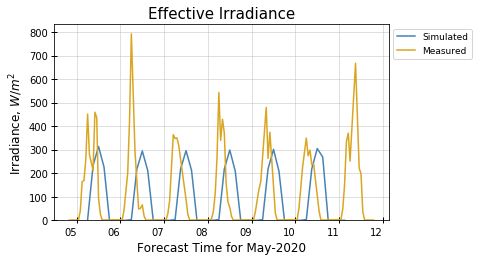

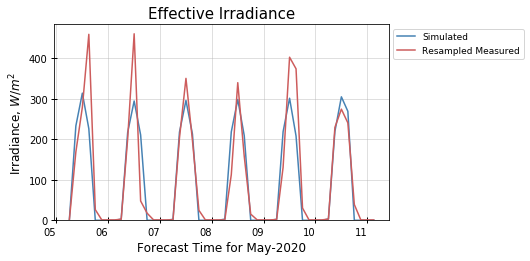

In [98]:
#Effective Irradiance Comparison Plot
plt.style.use('fast')

#Figure 1
fig1, ax1 = plt.subplots();

effective_irrad_calc.plot(label='Simulated', color='steelblue')
plt.plot(measured_irrad.index,measured_irrad['Meteocontrol Irrad., W/m2'], 
         label='Measured', color='goldenrod')

plt.rc('font', family='Helvetica')

plt.title('Effective Irradiance', fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^{2}$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('1_Sim_Mea_Irrad.eps', bbox_inches='tight')

#Figure 2
fig2, ax2 = plt.subplots();

effective_irrad_calc.plot(label='Simulated', color='steelblue')
plt.plot(new_measured_irrad.index, new_measured_irrad['Meteocontrol Irrad., W/m2'], 
         label='Resampled Measured', color='indianred')

plt.rc('font', family='Helvetica')

plt.title('Effective Irradiance', fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^{2}$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('1_Sim_ReMea_Irrad.eps', bbox_inches='tight')

data_irrad_error.head()

##### 8.1.3. Measured vs. Modeled DC Voltage

In [99]:
#Percentage Error Daily Values
error_DCVol_SysA = (abs(new_measured_dcvoltage['DC Voltage SysA String 1, V'] - sc_SysA['v_mp'])
               /new_measured_dcvoltage['DC Voltage SysA String 1, V'])*100;

error_DCVol_SysB = (abs(new_measured_dcvoltage['DC Voltage SysB String 1, V'] - sc_SysB['v_mp'])
               /new_measured_dcvoltage['DC Voltage SysB String 1, V'])*100;

data_error_DCVol = list(zip(datetime_index, new_measured_dcvoltage['DC Voltage SysA String 1, V'], 
                            sc_SysA['v_mp'], error_DCVol_SysA, new_measured_dcvoltage['DC Voltage SysB String 1, V'],
                            sc_SysB['v_mp'], error_DCVol_SysB));

data_error_DCVol = pd.DataFrame(data_error_DCVol, columns=['Datetime', 'SysA Measured', 'SysA Simulated', 
                                                           'SysA Error %', 'SysB Measured', 'SysB Simulated', 
                                                           'SysB Error %']);
data_error_DCVol = data_error_DCVol.round(2);

,Datetime,SysA Measured,SysA Simulated,SysA Error %,SysB Measured,SysB Simulated,SysB Error %
0,2020-05-05 06:00:00-05:00,521.0,571.70,9.73,262.6,643.17,144.92
1,2020-05-05 09:00:00-05:00,656.1,648.03,1.23,727.8,729.03,0.17
2,2020-05-05 12:00:00-05:00,648.0,636.77,1.73,718.5,716.37,0.30
3,2020-05-05 15:00:00-05:00,620.7,638.22,2.82,710.2,718.00,1.10
4,2020-05-05 18:00:00-05:00,608.9,380.26,37.55,683.5,427.79,37.41


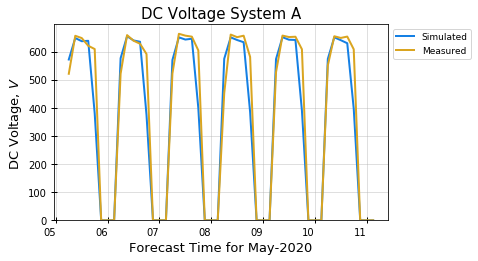

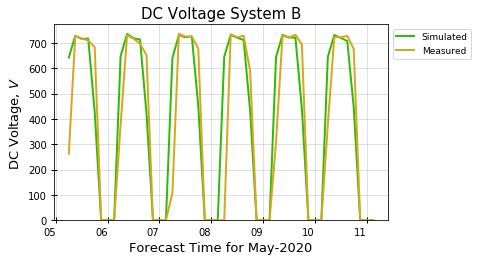

In [100]:
#DC Voltage Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

sc_SysA['v_mp'].plot(label='Simulated', color='#1580E4', linewidth=2)
plt.plot(new_measured_dcvoltage.index,new_measured_dcvoltage['DC Voltage SysA String 1, V'], 
         label='Measured', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')

plt.title('DC Voltage System A', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Voltage, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('1_Sim_ReMea_DCVoltage_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

sc_SysB['v_mp'].plot(label='Simulated', color='#2DBD07', linewidth=2)
plt.plot(new_measured_dcvoltage.index,new_measured_dcvoltage['DC Voltage SysB String 1, V'], 
         label='Measured', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')

plt.title('DC Voltage System B', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Voltage, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('1_Sim_ReMea_DCVoltage_SysB.eps', bbox_inches='tight')

data_error_DCVol.head()

##### 8.1.4. Measured vs. Modeled DC Current

In [101]:
#Percentage Error Daily Values
error_DCCur_SysA = (abs(new_measured_dccurrent['DC Current SysA String 1, A'] - sc_SysA['i_mp'])
               /new_measured_dccurrent['DC Current SysA String 1, A'])*100;

net_curr_SysB = new_measured_dccurrent['DC Current SysB String 1, A'] + new_measured_dccurrent['DC Current SysB String 2, A']

error_DCCur_SysB = (abs(net_curr_SysB.values - sc_SysB['i_mp'])
               /net_curr_SysB.values)*100;

data_error_DCCur = list(zip(datetime_index, new_measured_dccurrent['DC Current SysA String 1, A'], 
                            sc_SysA['i_mp'], error_DCCur_SysA, net_curr_SysB.values,
                            sc_SysB['i_mp'], error_DCCur_SysB));

data_error_DCCur = pd.DataFrame(data_error_DCCur, columns=['Datetime', 'SysA Measured', 'SysA Simulated', 
                                                           'SysA Error %', 'SysB Measured', 'SysB Simulated', 
                                                           'SysB Error %']);
data_error_DCCur = data_error_DCCur.round(2);

,Datetime,SysA Measured,SysA Simulated,SysA Error %,SysB Measured,SysB Simulated,SysB Error %
0,2020-05-05 06:00:00-05:00,0.00,0.20,inf,0.10,0.10,0.11
1,2020-05-05 09:00:00-05:00,10.35,18.45,78.23,5.26,9.22,75.35
2,2020-05-05 12:00:00-05:00,17.14,24.83,44.86,8.68,12.41,43.03
3,2020-05-05 15:00:00-05:00,20.78,17.91,13.83,14.84,8.95,39.67
4,2020-05-05 18:00:00-05:00,1.74,0.00,99.98,0.96,0.00,99.98


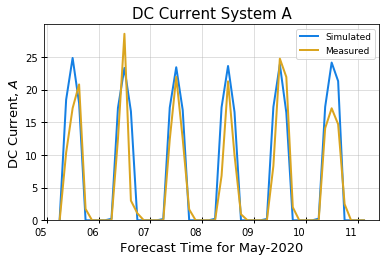

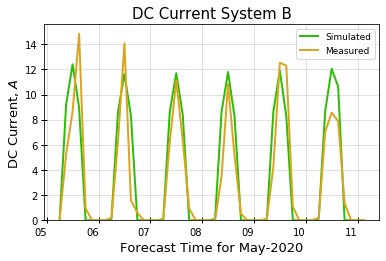

In [102]:
#DC Current Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

sc_SysA['i_mp'].plot(label='Simulated', color='#1580E4', linewidth=2)
plt.plot(new_measured_dccurrent.index,new_measured_dccurrent['DC Current SysA String 1, A'], 
         label='Measured', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')

plt.title('DC Current System A', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Current, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('1_Sim_ReMea_DCCurrent_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

sc_SysB['i_mp'].plot(label='Simulated', color='#2DBD07', linewidth=2)
plt.plot(new_measured_dccurrent.index, net_curr_SysB.values, 
         label='Measured', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')

plt.title('DC Current System B', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Current, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('1_Sim_ReMea_DCCurrent_SysB.eps', bbox_inches='tight')

data_error_DCCur.head()

##### 8.1.5. Measured vs. Modeled DC Power

In [103]:
#Percentage Error Daily Values
error_DCPow_SysA = (abs(new_measured_dcpower['DC Power SysA String 1, W'] - sc_SysA['p_mp'])
               /new_measured_dcpower['DC Power SysA String 1, W'])*100;

net_DCPow_SysB = new_measured_dcpower['DC Power SysB String 1, W'] + new_measured_dcpower['DC Power SysB String 2, W']

error_DCPow_SysB = (abs(net_DCPow_SysB.values - sc_SysB['p_mp'])
               /net_DCPow_SysB.values)*100;

data_error_DCPow = list(zip(datetime_index, new_measured_dcpower['DC Power SysA String 1, W'], 
                            sc_SysA['p_mp'], error_DCPow_SysA, net_DCPow_SysB,
                            sc_SysB['p_mp'], error_DCPow_SysB));

data_error_DCPow = pd.DataFrame(data_error_DCPow, columns=['Datetime', 'SysA Measured', 'SysA Simulated', 
                                                           'SysA Error %', 'SysB Measured', 'SysB Simulated', 
                                                           'SysB Error %']);
data_error_DCPow = data_error_DCPow.round(2);

,Datetime,SysA Measured,SysA Simulated,SysA Error %,SysB Measured,SysB Simulated,SysB Error %
0,2020-05-05 06:00:00-05:00,71.98,114.21,58.68,1.02,64.25,6198.59
1,2020-05-05 09:00:00-05:00,6790.52,11953.74,76.04,3714.38,6723.98,81.03
2,2020-05-05 12:00:00-05:00,11070.89,15810.54,42.81,6172.70,8893.43,44.08
3,2020-05-05 15:00:00-05:00,12729.23,11427.45,10.23,10500.76,6427.94,38.79
4,2020-05-05 18:00:00-05:00,1089.71,0.15,99.99,476.02,0.08,99.98


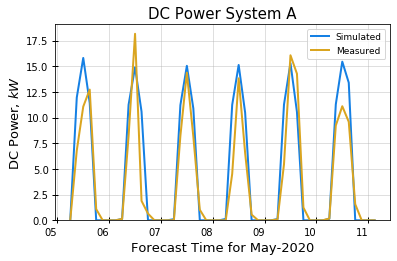

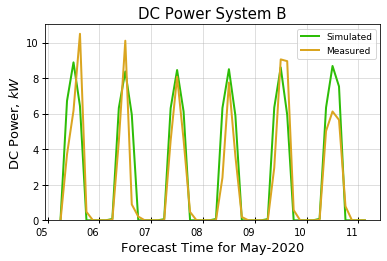

In [104]:
#DC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

kilo_DCPow_Sim_SysA = sc_SysA['p_mp']/kilo
kilo_DCPow_Mea_SysA = new_measured_dcpower['DC Power SysA String 1, W']/kilo

kilo_DCPow_Sim_SysA.plot(label='Simulated', color='#1580E4', linewidth=2)
plt.plot(new_measured_dcpower.index, kilo_DCPow_Mea_SysA, 
         label='Measured', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')

plt.title('DC Power System A', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Power, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('1_Sim_ReMea_DCPower_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

kilo_DCPow_Sim_SysB = sc_SysB['p_mp']/kilo
kilo_DCPow_Mea_SysB = net_DCPow_SysB/kilo

kilo_DCPow_Sim_SysB.plot(label='Simulated', color='#2DBD07', linewidth=2)
plt.plot(new_measured_dcpower.index, kilo_DCPow_Mea_SysB, 
         label='Measured', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')

plt.title('DC Power System B', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Power, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('1_Sim_ReMea_DCPower_SysB.eps', bbox_inches='tight')

data_error_DCPow.head()

##### 8.1.6. Measured vs. Modeled AC Power

In [105]:
#Measured AC Power in W to kW
kilo_ACPow_Mea_SysA = new_measured_acpower['AC Power SysA, W']/kilo
kilo_ACPow_Mea_SysB = new_measured_acpower['AC Power SysB, W']/kilo

#Percentage Error Daily Values
error_ACPow_SysA = (abs(kilo_ACPow_Mea_SysA.values - cont_ACPow_SysA)
               /kilo_ACPow_Mea_SysA.values)*100;

error_ACPow_SysB = (abs(kilo_ACPow_Mea_SysB.values - cont_ACPow_SysB)
               /kilo_ACPow_Mea_SysB.values)*100;

data_error_ACPow = list(zip(datetime_index, kilo_ACPow_Mea_SysA, 
                            cont_ACPow_SysA, error_ACPow_SysA, kilo_ACPow_Mea_SysB,
                            cont_ACPow_SysB, error_ACPow_SysB));

data_error_ACPow = pd.DataFrame(data_error_ACPow, columns=['Datetime', 'SysA Measured', 'SysA Simulated', 
                                                           'SysA Error %', 'SysB Measured', 'SysB Simulated', 
                                                           'SysB Error %']);
data_error_ACPow = data_error_ACPow.round(2);

,Datetime,SysA Measured,SysA Simulated,SysA Error %,SysB Measured,SysB Simulated,SysB Error %
0,2020-05-05 06:00:00-05:00,0.02,-0.00,105.30,0.00,-0.00,159.80
1,2020-05-05 09:00:00-05:00,6.63,11.69,76.22,3.60,6.55,81.80
2,2020-05-05 12:00:00-05:00,10.87,15.49,42.46,5.99,8.69,45.03
3,2020-05-05 15:00:00-05:00,12.51,11.17,10.75,10.21,6.26,38.74
4,2020-05-05 18:00:00-05:00,0.93,-0.00,100.11,0.46,-0.00,100.13


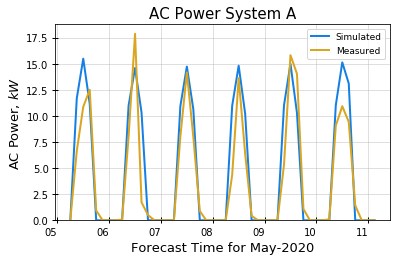

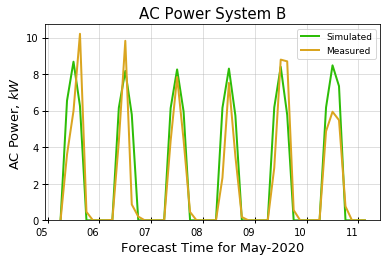

In [106]:
#AC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

cont_ACPow_SysA.plot(label='Simulated', color='#1580E4', linewidth=2)
plt.plot(new_measured_acpower.index, kilo_ACPow_Mea_SysA, 
         label='Measured', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')

plt.title('AC Power System A', fontname="Helvetica", fontsize=15);
plt.ylabel('AC Power, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('1_Sim_ReMea_ACPower_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

cont_ACPow_SysB.plot(label='Simulated', color='#2DBD07', linewidth=2)
plt.plot(new_measured_acpower.index, kilo_ACPow_Mea_SysB, 
         label='Measured', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')

plt.title('AC Power System B', fontname="Helvetica", fontsize=15);
plt.ylabel('AC Power, $kW$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('1_Sim_ReMea_ACPower_SysB.eps', bbox_inches='tight')

data_error_ACPow.head()

##### 8.1.7. Measured vs. Modeled Module Temperature

In [107]:
#Percentage Error Daily Values
error_ModTemp = (abs(new_measured_modtemp['Modules Temp, °C'] - pvtemps['temp_cell'])
               /new_measured_modtemp['Modules Temp, °C'])*100;

data_error_ModTemp = list(zip(datetime_index, new_measured_modtemp['Modules Temp, °C'], 
                            pvtemps['temp_cell'], error_ModTemp));

data_error_ModTemp = pd.DataFrame(data_error_ModTemp, columns=['Datetime', 'Measured', 'Simulated', 
                                                           'Error %']);
data_error_ModTemp = data_error_ModTemp.round(2);

,Datetime,Measured,Simulated,Error %
0,2020-05-05 06:00:00-05:00,13.88,9.98,28.12
1,2020-05-05 09:00:00-05:00,22.36,23.29,4.15
2,2020-05-05 12:00:00-05:00,28.60,29.69,3.81
3,2020-05-05 15:00:00-05:00,33.97,26.89,20.84
4,2020-05-05 18:00:00-05:00,15.25,18.41,20.75


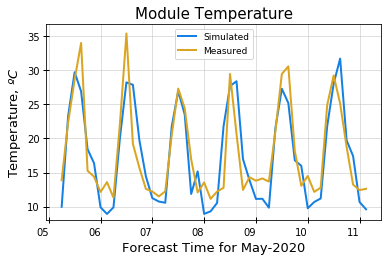

In [108]:
#AC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

pvtemps['temp_cell'].plot(label='Simulated', color='#1580E4', linewidth=2)
plt.plot(new_measured_modtemp.index, new_measured_modtemp['Modules Temp, °C'], 
         label='Measured', color='goldenrod', linewidth=2)

plt.rc('font', family='Helvetica')

plt.title('Module Temperature', fontname="Helvetica", fontsize=15);
plt.ylabel('Temperature, $ºC$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(8, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('1_Sim_ReMea_ModTemp.eps', bbox_inches='tight')

data_error_ModTemp.head()

##### 8.1.8. Measured vs. Modeled Energy

In [109]:
#Daily Measured Energy (It is Given Hourly)
mea_daily_energy_SysA = new_measured_energy['Energy SysA, kWh'].resample('1d').max();
mea_daily_energy_SysB = new_measured_energy['Energy SysB, kWh'].resample('1d').max();

In [110]:
#Percentage Error Daily Values
error_Energy_SysA = (abs(mea_daily_energy_SysA.values - daily_energy['SysA'])
               /mea_daily_energy_SysA.values)*100;

error_Energy_SysB = (abs(mea_daily_energy_SysB.values - daily_energy['SysB'])
               /mea_daily_energy_SysB.values)*100;

data_error_Energy = list(zip(datetime_index, mea_daily_energy_SysA, 
                            daily_energy['SysA'], error_Energy_SysA, mea_daily_energy_SysB,
                            daily_energy['SysB'], error_Energy_SysB));

data_error_Energy = pd.DataFrame(data_error_Energy, columns=['Datetime', 'SysA Measured', 'SysA Simulated', 
                                                           'SysA Error %', 'SysB Measured', 'SysB Simulated', 
                                                           'SysB Error %']);
data_error_Energy = data_error_Energy.round(2);

,Datetime,SysA Measured,SysA Simulated,SysA Error %,SysB Measured,SysB Simulated,SysB Error %
0,2020-05-05 06:00:00-05:00,98.42,115.02,16.87,59.66,64.48,8.07
1,2020-05-05 09:00:00-05:00,100.85,107.74,6.83,55.13,60.39,9.54
2,2020-05-05 12:00:00-05:00,97.40,108.96,11.87,53.68,61.08,13.78
3,2020-05-05 15:00:00-05:00,94.50,108.07,14.36,51.76,60.57,17.02
4,2020-05-05 18:00:00-05:00,101.43,108.94,7.41,57.75,61.07,5.74


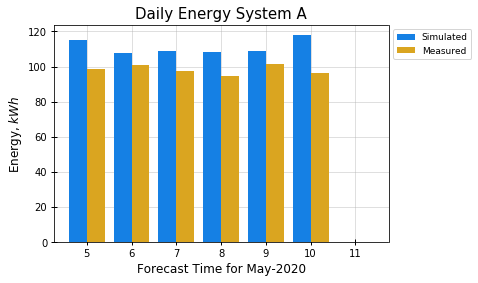

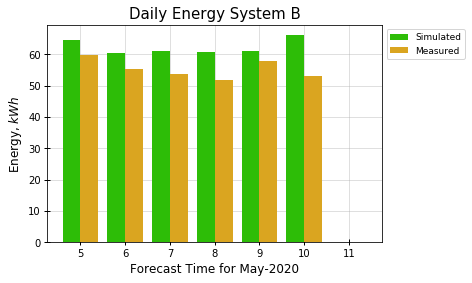

In [111]:
#Energy Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

plt.bar(r1, daily_energy['SysA'], width, label='Simulated', color='#1580E4', linewidth=2);
plt.bar(r3, mea_daily_energy_SysA, width, label='Measured', color='goldenrod', linewidth=2);

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Daily Energy System A', fontname="Helvetica", fontsize=15);
plt.ylabel('Energy, $kWh$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width/2, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('1_Sim_ReMea_Energy_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

plt.bar(r1, daily_energy['SysB'], width, label='Simulated', color='#2DBD07', linewidth=2);
plt.bar(r3, mea_daily_energy_SysB, width, label='Measured', color='goldenrod', linewidth=2);

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Daily Energy System B', fontname="Helvetica", fontsize=15);
plt.ylabel('Energy, $kWh$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width/2, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('1_Sim_ReMea_Energy_SysB.eps', bbox_inches='tight')

data_error_Energy.head()

### 8.2. ALL SIMULATION MODELS COMPARISON
This sub-section presents the comparison between all simulation models, i.e. (i.) PVLIB-Python (Method 1 and 2), (ii.) PVLIB-Python ModelChain, (iii.) PVSyst ModelChain, (iv.) PVWatts Manual with losses, (v.) PVWatts ModelChain with losses and (vi.) PVWatts ModelChain without losses.

##### 8.2.1. Max. DC Power Comparison

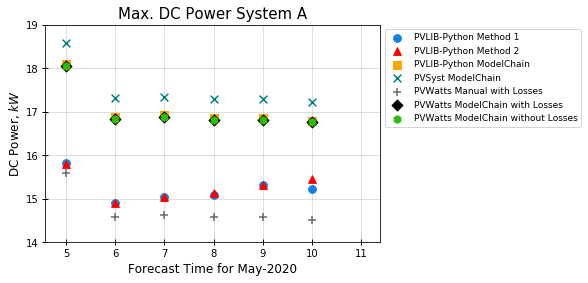

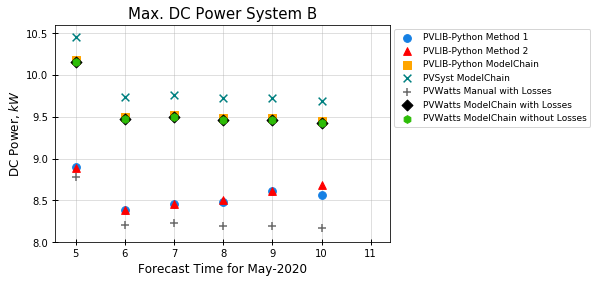

In [112]:
#Maximum System A' DC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

plt.scatter(x, scaled_results_DS_SysA['p_mp']/kilo, label='PVLIB-Python Method 1', color='#1580E4', marker='o', s=60)
plt.scatter(x, sc_max_SysA['p_mp']/kilo, label='PVLIB-Python Method 2', color='red', marker='^', s=60)
plt.scatter(x, pvlib_max_mc_DCpmp_SysA['p_mp']/kilo, label='PVLIB-Python ModelChain', color='orange', marker='s', s=60)
plt.scatter(x, pvsyst_max_mc_DCpmp_SysA['p_mp']/kilo, label='PVSyst ModelChain', color='teal', marker='x', s=60)
plt.scatter(x, pvwatts_max_DCpmp_SysA/kilo, label='PVWatts Manual with Losses', color='dimgray', marker='+', s=60)
plt.scatter(x, pvwatts_max_mc_losses_DCpmp_SysA/kilo, label='PVWatts ModelChain with Losses', color='black', marker='D', s=60)
plt.scatter(x, pvwatts_max_mc_DCpmp_SysA/kilo, label='PVWatts ModelChain without Losses', color='#2DBD07', marker='h', s=60)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Max. DC Power System A', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Power, $kW$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x, int_days)
plt.ylim(14, 19)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('2_All_Sim_Mod_MDCPower_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

plt.scatter(x, scaled_results_DS_SysB['p_mp']/kilo, label='PVLIB-Python Method 1', color='#1580E4', marker='o', s=60)
plt.scatter(x, sc_max_SysB['p_mp']/kilo, label='PVLIB-Python Method 2', color='red', marker='^', s=60)
plt.scatter(x, pvlib_max_mc_DCpmp_SysB['p_mp']/kilo, label='PVLIB-Python ModelChain', color='orange', marker='s', s=60)
plt.scatter(x, pvsyst_max_mc_DCpmp_SysB['p_mp']/kilo, label='PVSyst ModelChain', color='teal', marker='x', s=60)
plt.scatter(x, pvwatts_max_DCpmp_SysB/kilo, label='PVWatts Manual with Losses', color='dimgray', marker='+', s=60)
plt.scatter(x, pvwatts_max_mc_losses_DCpmp_SysB/kilo, label='PVWatts ModelChain with Losses', color='black', marker='D', s=60)
plt.scatter(x, pvwatts_max_mc_DCpmp_SysB/kilo, label='PVWatts ModelChain without Losses', color='#2DBD07', marker='h', s=60)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Max. DC Power System B', fontname="Helvetica", fontsize=15);
plt.ylabel('DC Power, $kW$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x, int_days)
plt.ylim(8, 10.6)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('2_All_Sim_Mod_MaxDCPower_SysB.eps', bbox_inches='tight')

##### 8.2.2. Max. AC Power Comparison

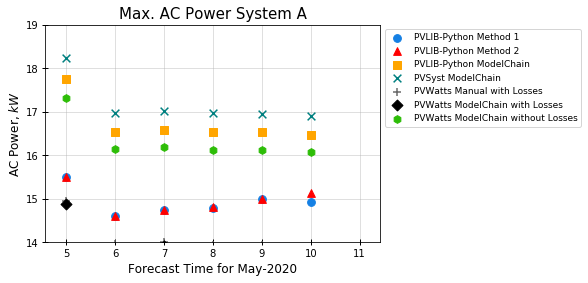

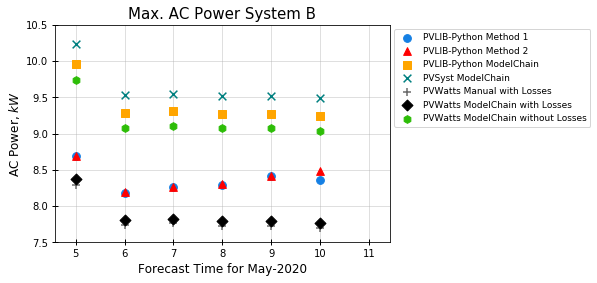

In [113]:
#Maximum System A' AC Power Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

plt.scatter(x, Pot_AC_SysA_method_1, label='PVLIB-Python Method 1', color='#1580E4', marker='o', s=60)
plt.scatter(x, Pot_AC_SysA_method_2, label='PVLIB-Python Method 2', color='red', marker='^', s=60)
plt.scatter(x, pvlib_max_mc_ACpmp_SysA/kilo, label='PVLIB-Python ModelChain', color='orange', marker='s', s=60)
plt.scatter(x, pvsyst_max_mc_ACpmp_SysA/kilo, label='PVSyst ModelChain', color='teal', marker='x', s=60)
plt.scatter(x, pvwatts_max_ACpmp_SysA/kilo, label='PVWatts Manual with Losses', color='dimgray', marker='+', s=60)
plt.scatter(x, pvwatts_max_mc_losses_ACpmp_SysA/kilo, label='PVWatts ModelChain with Losses', color='black', marker='D', s=60)
plt.scatter(x, pvwatts_max_mc_ACpmp_SysA/kilo, label='PVWatts ModelChain without Losses', color='#2DBD07', marker='h', s=60)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Max. AC Power System A', fontname="Helvetica", fontsize=15);
plt.ylabel('AC Power, $kW$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x, int_days)
plt.ylim(14, 19)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('2_All_Sim_Mod_MaxACPower_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

plt.scatter(x, Pot_AC_SysB_method_1, label='PVLIB-Python Method 1', color='#1580E4', marker='o', s=60)
plt.scatter(x, Pot_AC_SysB_method_2, label='PVLIB-Python Method 2', color='red', marker='^', s=60)
plt.scatter(x, pvlib_max_mc_ACpmp_SysB/kilo, label='PVLIB-Python ModelChain', color='orange', marker='s', s=60)
plt.scatter(x, pvsyst_max_mc_ACpmp_SysB/kilo, label='PVSyst ModelChain', color='teal', marker='x', s=60)
plt.scatter(x, pvwatts_max_ACpmp_SysB/kilo, label='PVWatts Manual with Losses', color='dimgray', marker='+', s=60)
plt.scatter(x, pvwatts_max_mc_losses_ACpmp_SysB/kilo, label='PVWatts ModelChain with Losses', color='black', marker='D', s=60)
plt.scatter(x, pvwatts_max_mc_ACpmp_SysB/kilo, label='PVWatts ModelChain without Losses', color='#2DBD07', marker='h', s=60)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Max. AC Power System B', fontname="Helvetica", fontsize=15);
plt.ylabel('AC Power, $kW$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x, int_days)
plt.ylim(7.5, 10.5)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('2_All_Sim_Mod_MaxACPower_SysB.eps', bbox_inches='tight')

##### 8.2.3. Max. Daily Energy Comparison
As mentioned in Section 6.7., it was easier to get the daily energy production by applying the Method 2 rather than the Method 1 because the first one retrieve a 'continuous' data of AC power during each day (and not only the maximum value as stated with Method 1). Due to this reason, **the PVLIB-Python Method 1 data for energy is not plotted**.

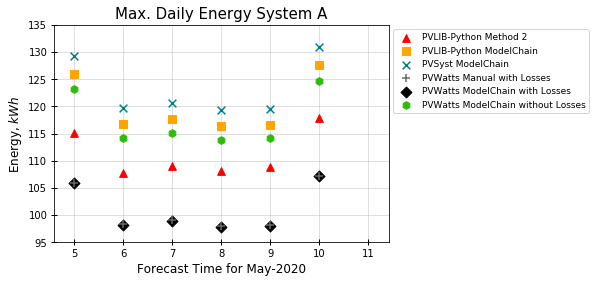

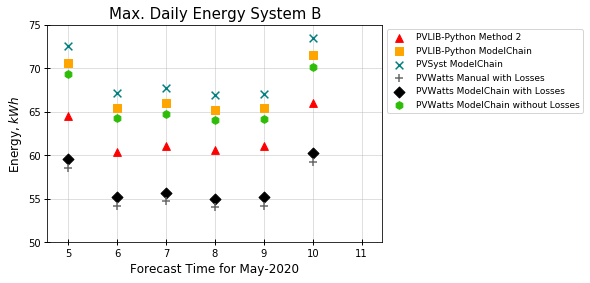

In [114]:
#Maximum System A' Daily Energy Production Comparison Plot
plt.style.use('fast')

#System A Figure
fig1, ax1 = plt.subplots();

plt.scatter(x, daily_energy['SysA'], label='PVLIB-Python Method 2', color='red', marker='^', s=60)
plt.scatter(x, pvlib_daily_energy['SysA']/kilo, label='PVLIB-Python ModelChain', color='orange', marker='s', s=60)
plt.scatter(x, pvsyst_daily_energy['SysA']/kilo, label='PVSyst ModelChain', color='teal', marker='x', s=60)
plt.scatter(x, pwmle_daily_energy['SysA']/kilo, label='PVWatts Manual with Losses', color='dimgray', marker='+', s=60,zorder=10)
plt.scatter(x, pwmcle_daily_energy['SysA']/kilo, label='PVWatts ModelChain with Losses', color='black', marker='D', s=60)
plt.scatter(x, pwmc_daily_energy['SysA']/kilo, label='PVWatts ModelChain without Losses', color='#2DBD07', marker='h', s=60)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Max. Daily Energy System A', fontname="Helvetica", fontsize=15);
plt.ylabel('Energy, $kWh$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x, int_days)
plt.ylim(95, 135)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('2_All_Sim_Mod_MaxEnergy_SysA.eps', bbox_inches='tight')

#System B Figure
fig2, ax2 = plt.subplots();

plt.scatter(x, daily_energy['SysB'], label='PVLIB-Python Method 2', color='red', marker='^', s=60)
plt.scatter(x, pvlib_daily_energy['SysB']/kilo, label='PVLIB-Python ModelChain', color='orange', marker='s', s=60)
plt.scatter(x, pvsyst_daily_energy['SysB']/kilo, label='PVSyst ModelChain', color='teal', marker='x', s=60)
plt.scatter(x, pwmle_daily_energy['SysB']/kilo, label='PVWatts Manual with Losses', color='dimgray', marker='+', s=60,zorder=10)
plt.scatter(x, pwmcle_daily_energy['SysB']/kilo, label='PVWatts ModelChain with Losses', color='black', marker='D', s=60)
plt.scatter(x, pwmc_daily_energy['SysB']/kilo, label='PVWatts ModelChain without Losses', color='#2DBD07', marker='h', s=60)

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Max. Daily Energy System B', fontname="Helvetica", fontsize=15);
plt.ylabel('Energy, $kWh$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x, int_days)
plt.ylim(50,75)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('2_All_Sim_Mod_MaxEnergy_SysB.eps', bbox_inches='tight')

### 8.3. ALL SIMULATION MODELS vs. MEASURED DATA
This sub-section presents the comparison between all the simulation models (stated at the previous, 8.2., sub-section) vs. Measured Data.

The comparison is between the maximum average values of the variables analyzed.

___
**Note:** 
It is very important to note that the maximum value will tend to present a significant and therefore unreliable error. This is due to the high current variability in the actual application; This high 'volatility' causes alterations in DC Power, AC Power and Daily Energy, as will be seen below. Despite this, the analysis will show how close it is to the maximum measured value.
___

##### 8.3.1. DC Power Average Values
Average values of the DC Power for each simulation model at the time window analyzed.

In [115]:
#Averaging DC Power

#System A
#PVLIB-Python Method 1
new_scaled_results_DS_SysA = scaled_results_DS_SysA[:-1]
av_scaled_results_DS_SysA = np.average(new_scaled_results_DS_SysA['p_mp'])

#PVLIB-Python Method 2
new_sc_max_SysA = sc_max_SysA[:-1]
av_sc_max_SysA = np.average(new_sc_max_SysA['p_mp'])

#PVLIB-Python ModelChain
new_pvlib_max_mc_DCpmp_SysA = pvlib_max_mc_DCpmp_SysA[:-1]
av_pvlib_max_mc_DCpmp_SysA = np.average(new_pvlib_max_mc_DCpmp_SysA['p_mp'])

#PVSyst ModelChain
new_pvsyst_max_mc_DCpmp_SysA = pvsyst_max_mc_DCpmp_SysA[:-1]
av_pvsyst_max_mc_DCpmp_SysA = np.average(new_pvsyst_max_mc_DCpmp_SysA['p_mp'])

#PVWatts Manual with Losses
new_pvwatts_max_DCpmp_SysA = pvwatts_max_DCpmp_SysA[:-1]
av_pvwatts_max_DCpmp_SysA = np.average(new_pvwatts_max_DCpmp_SysA['p_mp'])

#PVWatts ModelChain with Losses
new_pvwatts_max_mc_losses_DCpmp_SysA = pvwatts_max_mc_losses_DCpmp_SysA[:-1]
av_pvwatts_max_mc_losses_DCpmp_SysA = np.average(new_pvwatts_max_mc_losses_DCpmp_SysA['p_mp'])

#PVWatts ModelChain without Losses
new_pvwatts_max_mc_DCpmp_SysA = pvwatts_max_mc_DCpmp_SysA[:-1]
av_pvwatts_max_mc_DCpmp_SysA = np.average(new_pvwatts_max_mc_DCpmp_SysA['p_mp'])

#System B
#PVLIB-Python Method 1
new_scaled_results_DS_SysB = scaled_results_DS_SysB[:-1]
av_scaled_results_DS_SysB = np.average(new_scaled_results_DS_SysB['p_mp'])

#PVLIB-Python Method 2
new_sc_max_SysB = sc_max_SysB[:-1]
av_sc_max_SysB = np.average(new_sc_max_SysB['p_mp'])

#PVLIB-Python ModelChain
new_pvlib_max_mc_DCpmp_SysB = pvlib_max_mc_DCpmp_SysB[:-1]
av_pvlib_max_mc_DCpmp_SysB = np.average(new_pvlib_max_mc_DCpmp_SysB['p_mp'])

#PVSyst ModelChain
new_pvsyst_max_mc_DCpmp_SysB = pvsyst_max_mc_DCpmp_SysB[:-1]
av_pvsyst_max_mc_DCpmp_SysB = np.average(new_pvsyst_max_mc_DCpmp_SysB['p_mp'])

#PVWatts Manual with Losses
new_pvwatts_max_DCpmp_SysB = pvwatts_max_DCpmp_SysB[:-1]
av_pvwatts_max_DCpmp_SysB = np.average(new_pvwatts_max_DCpmp_SysB['p_mp'])

#PVWatts ModelChain with Losses
new_pvwatts_max_mc_losses_DCpmp_SysB = pvwatts_max_mc_losses_DCpmp_SysB[:-1]
av_pvwatts_max_mc_losses_DCpmp_SysB = np.average(new_pvwatts_max_mc_losses_DCpmp_SysB['p_mp'])

#PVWatts ModelChain without Losses
new_pvwatts_max_mc_DCpmp_SysB = pvwatts_max_mc_DCpmp_SysB[:-1]
av_pvwatts_max_mc_DCpmp_SysB = np.average(new_pvwatts_max_mc_DCpmp_SysB['p_mp'])

##### 8.3.2. AC Power Average Values
Average values of the AC Power for each simulation model at the time window analyzed.

In [116]:
#Averaging AC Power

#System A
#PVLIB-Python Method 1
new_Pot_AC_SysA_method_1 = Pot_AC_SysA_method_1[:-1]
new_Pot_AC_SysA_method_1 = new_Pot_AC_SysA_method_1*kilo
av_Pot_AC_SysA_method_1 = np.average(new_Pot_AC_SysA_method_1)

#PVLIB-Python Method 2
new_Pot_AC_SysA_method_2 = Pot_AC_SysA_method_2[:-1]
new_Pot_AC_SysA_method_2 = new_Pot_AC_SysA_method_2*kilo
av_Pot_AC_SysA_method_2 = np.average(new_Pot_AC_SysA_method_2)

#PVLIB-Python ModelChain
new_pvlib_max_mc_ACpmp_SysA = pvlib_max_mc_ACpmp_SysA[:-1]
av_pvlib_max_mc_ACpmp_SysA = np.average(new_pvlib_max_mc_ACpmp_SysA)

#PVSyst ModelChain
new_pvsyst_max_mc_ACpmp_SysA = pvsyst_max_mc_ACpmp_SysA[:-1]
av_pvsyst_max_mc_ACpmp_SysA = np.average(new_pvsyst_max_mc_ACpmp_SysA)

#PVWatts Manual with Losses
new_pvwatts_max_ACpmp_SysA = pvwatts_max_ACpmp_SysA[:-1]
av_pvwatts_max_ACpmp_SysA = np.average(new_pvwatts_max_ACpmp_SysA)

#PVWatts ModelChain with Losses
new_pvwatts_max_mc_losses_ACpmp_SysA = pvwatts_max_mc_losses_ACpmp_SysA[:-1]
av_pvwatts_max_mc_losses_ACpmp_SysA = np.average(new_pvwatts_max_mc_losses_ACpmp_SysA)

#PVWatts ModelChain without Losses
new_pvwatts_max_mc_ACpmp_SysA = pvwatts_max_mc_ACpmp_SysA[:-1]
av_pvwatts_max_mc_ACpmp_SysA = np.average(new_pvwatts_max_mc_ACpmp_SysA)

#System B
#PVLIB-Python Method 1
new_Pot_AC_SysB_method_1 = Pot_AC_SysB_method_1[:-1]
new_Pot_AC_SysB_method_1 = new_Pot_AC_SysB_method_1*kilo
av_Pot_AC_SysB_method_1 = np.average(new_Pot_AC_SysB_method_1)

#PVLIB-Python Method 2
new_Pot_AC_SysB_method_2 = Pot_AC_SysB_method_2[:-1]
new_Pot_AC_SysB_method_2 = new_Pot_AC_SysB_method_2*kilo
av_Pot_AC_SysB_method_2 = np.average(new_Pot_AC_SysB_method_2)

#PVLIB-Python ModelChain
new_pvlib_max_mc_ACpmp_SysB = pvlib_max_mc_ACpmp_SysB[:-1]
av_pvlib_max_mc_ACpmp_SysB = np.average(new_pvlib_max_mc_ACpmp_SysB)

#PVSyst ModelChain
new_pvsyst_max_mc_ACpmp_SysB = pvsyst_max_mc_ACpmp_SysB[:-1]
av_pvsyst_max_mc_ACpmp_SysB = np.average(new_pvsyst_max_mc_ACpmp_SysB)

#PVWatts Manual with Losses
new_pvwatts_max_ACpmp_SysB = pvwatts_max_ACpmp_SysB[:-1]
av_pvwatts_max_ACpmp_SysB = np.average(new_pvwatts_max_ACpmp_SysB)

#PVWatts ModelChain with Losses
new_pvwatts_max_mc_losses_ACpmp_SysB = pvwatts_max_mc_losses_ACpmp_SysB[:-1]
av_pvwatts_max_mc_losses_ACpmp_SysB = np.average(new_pvwatts_max_mc_losses_ACpmp_SysB)

#PVWatts ModelChain without Losses
new_pvwatts_max_mc_ACpmp_SysB = pvwatts_max_mc_ACpmp_SysB[:-1]
av_pvwatts_max_mc_ACpmp_SysB = np.average(new_pvwatts_max_mc_ACpmp_SysB)

##### 8.3.3. Daily Energy Average Values
Average values of the Daily Energy for each simulation model at the time window analyzed.

As mentioned in Section 6.7. and stated in the sub-section 8.2.3., the PVLIB-Python Method 1 data for daily energy is not plotted.

In [117]:
#Averaging Daily Energy

#System A
#PVLIB-Python Method 2
new_daily_energy = daily_energy[:-1]
new_daily_energy = new_daily_energy*kilo
av_daily_energy_SysA = np.average(new_daily_energy['SysA'])

#PVLIB-Python ModelChain
new_pvlib_daily_energy = pvlib_daily_energy[:-1]
av_pvlib_daily_energy_SysA = np.average(new_pvlib_daily_energy['SysA'])

#PVSyst ModelChain
new_pvsyst_daily_energy = pvsyst_daily_energy[:-1]
av_pvsyst_daily_energy_SysA = np.average(new_pvsyst_daily_energy['SysA'])

#PVWatts Manual with Losses
new_pwmle_daily_energy = pwmle_daily_energy[:-1]
av_pwmle_daily_energy_SysA = np.average(new_pwmle_daily_energy['SysA'])

#PVWatts ModelChain with Losses
new_pwmcle_daily_energy = pwmcle_daily_energy[:-1]
av_pwmcle_daily_energy_SysA = np.average(new_pwmcle_daily_energy['SysA'])

#PVWatts ModelChain without Losses
new_pwmc_daily_energy = pwmc_daily_energy[:-1]
av_pwmc_daily_energy_SysA = np.average(new_pwmc_daily_energy['SysA'])

#System B
#PVLIB-Python Method 2
av_daily_energy_SysB = np.average(new_daily_energy['SysB'])

#PVLIB-Python ModelChain
av_pvlib_daily_energy_SysB = np.average(new_pvlib_daily_energy['SysB'])

#PVSyst ModelChain
av_pvsyst_daily_energy_SysB = np.average(new_pvsyst_daily_energy['SysB'])

#PVWatts Manual with Losses
av_pwmle_daily_energy_SysB = np.average(new_pwmle_daily_energy['SysB'])

#PVWatts ModelChain with Losses
av_pwmcle_daily_energy_SysB = np.average(new_pwmcle_daily_energy['SysB'])

#PVWatts ModelChain without Losses
av_pwmc_daily_energy_SysB = np.average(new_pwmc_daily_energy['SysB'])

##### 8.3.4. Maximum and Average Measured Values
First, the maximum values measured by Meteocontrol' data acquisition system at Los Andes University Photovoltaic System are found; then, the average value for each variable (DC Power, AC Power and Daily Energy) is retrieved.

In [118]:
#Averaging DC Power
#System A
max_mea_dcpower_SysA = new_measured_dcpower['DC Power SysA String 1, W'].resample('1d').max();
new_max_mea_dcpower_SysA = max_mea_dcpower_SysA[:-1]
av_max_mea_dcpower_SysA = np.average(new_max_mea_dcpower_SysA)

#System B
max_mea_dcpower_SysB = net_DCPow_SysB.resample('1d').max();
new_max_mea_dcpower_SysB = max_mea_dcpower_SysB[:-1]
av_max_mea_dcpower_SysB = np.average(new_max_mea_dcpower_SysB)

#Averaging AC Power
#System A
max_mea_acpower_SysA = new_measured_acpower['AC Power SysA, W'].resample('1d').max();
new_max_mea_acpower_SysA = max_mea_acpower_SysA[:-1]
av_max_mea_acpower_SysA = np.average(new_max_mea_acpower_SysA)

#System B
max_mea_acpower_SysB = new_measured_acpower['AC Power SysB, W'].resample('1d').max();
new_max_mea_acpower_SysB = max_mea_acpower_SysB[:-1]
av_max_mea_acpower_SysB = np.average(new_max_mea_acpower_SysB)

#Averaging Daily Energy
#System A
new_max_mea_energy_SysA = mea_daily_energy_SysA[:-1]
av_max_mea_energy_SysA = np.average(new_max_mea_energy_SysA*kilo)

#System B
new_max_mea_energy_SysB = mea_daily_energy_SysB[:-1]
av_max_mea_energy_SysB = np.average(new_max_mea_energy_SysB*kilo)

##### 8.3.5. DC Power Percentage Error

In [119]:
comp_index = ['PVLIB-Python Method 1', 'PVLIB-Python Method 2', 'PVLIB-Python ModelChain', 'PVSyst ModelChain',
             'PVWatts Manual with Losses', 'PVWatts ModelChain with Losses', 'PVWatts ModelChain without Losses']
comp_index = pd.DataFrame(comp_index)

In [120]:
#System A
comp_dcpower_SysA = []

#PVLIB-Python Method 1
error_dcpower = ((av_max_mea_dcpower_SysA - av_scaled_results_DS_SysA)
                     /av_max_mea_dcpower_SysA)*100;

comp_dcpower_SysA.append(error_dcpower)

#PVLIB-Python Method 2
error_dcpower = ((av_max_mea_dcpower_SysA - av_sc_max_SysA)
                     /av_max_mea_dcpower_SysA)*100;

comp_dcpower_SysA.append(error_dcpower)

#PVLIB-Python ModelChain
error_dcpower = ((av_max_mea_dcpower_SysA - av_pvlib_max_mc_DCpmp_SysA)
                     /av_max_mea_dcpower_SysA)*100;

comp_dcpower_SysA.append(error_dcpower)

#PVSyst ModelChain
error_dcpower = ((av_max_mea_dcpower_SysA - av_pvsyst_max_mc_DCpmp_SysA)
                     /av_max_mea_dcpower_SysA)*100;

comp_dcpower_SysA.append(error_dcpower)

#PVWatts Manual with Losses
error_dcpower = ((av_max_mea_dcpower_SysA - av_pvwatts_max_DCpmp_SysA)
                     /av_max_mea_dcpower_SysA)*100;

comp_dcpower_SysA.append(error_dcpower)

#PVWatts ModelChain with Losses
error_dcpower = ((av_max_mea_dcpower_SysA - av_pvwatts_max_mc_losses_DCpmp_SysA)
                     /av_max_mea_dcpower_SysA)*100;

comp_dcpower_SysA.append(error_dcpower)

#PVWatts ModelChain without Losses
error_dcpower = ((av_max_mea_dcpower_SysA - av_pvwatts_max_mc_DCpmp_SysA)
                     /av_max_mea_dcpower_SysA)*100;

comp_dcpower_SysA.append(error_dcpower)

comp_dcpower_SysA = pd.DataFrame(comp_dcpower_SysA, columns=['Error DC Power SysA'])
comp_dcpower_SysA['Sim. Model'] = comp_index
comp_dcpower_SysA.sort_values('Error DC Power SysA', inplace=True)
comp_dcpower_SysA.reset_index(inplace=True)

#System B
comp_dcpower_SysB = []

#PVLIB-Python Method 1
error_dcpower = ((av_max_mea_dcpower_SysB - av_scaled_results_DS_SysB)
                     /av_max_mea_dcpower_SysB)*100;

comp_dcpower_SysB.append(error_dcpower)

#PVLIB-Python Method 2
error_dcpower = ((av_max_mea_dcpower_SysB - av_sc_max_SysB)
                     /av_max_mea_dcpower_SysB)*100;

comp_dcpower_SysB.append(error_dcpower)

#PVLIB-Python ModelChain
error_dcpower = ((av_max_mea_dcpower_SysB - av_pvlib_max_mc_DCpmp_SysB)
                     /av_max_mea_dcpower_SysB)*100;

comp_dcpower_SysB.append(error_dcpower)

#PVSyst ModelChain
error_dcpower = ((av_max_mea_dcpower_SysB - av_pvsyst_max_mc_DCpmp_SysB)
                     /av_max_mea_dcpower_SysB)*100;

comp_dcpower_SysB.append(error_dcpower)

#PVWatts Manual with Losses
error_dcpower = ((av_max_mea_dcpower_SysB - av_pvwatts_max_DCpmp_SysB)
                     /av_max_mea_dcpower_SysB)*100;

comp_dcpower_SysB.append(error_dcpower)

#PVWatts ModelChain with Losses
error_dcpower = ((av_max_mea_dcpower_SysB - av_pvwatts_max_mc_losses_DCpmp_SysB)
                     /av_max_mea_dcpower_SysB)*100;

comp_dcpower_SysB.append(error_dcpower)

#PVWatts ModelChain without Losses
error_dcpower = ((av_max_mea_dcpower_SysB - av_pvwatts_max_mc_DCpmp_SysB)
                     /av_max_mea_dcpower_SysB)*100;

comp_dcpower_SysB.append(error_dcpower)

comp_dcpower_SysB = pd.DataFrame(comp_dcpower_SysB, columns=['Error DC Power SysB'])
comp_dcpower_SysB['Sim. Model'] = comp_index
comp_dcpower_SysB.sort_values('Error DC Power SysB', inplace=True)
comp_dcpower_SysB.reset_index(inplace=True)

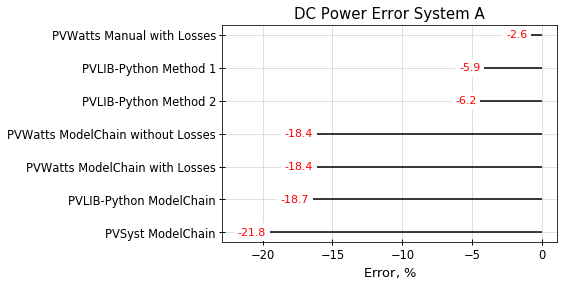

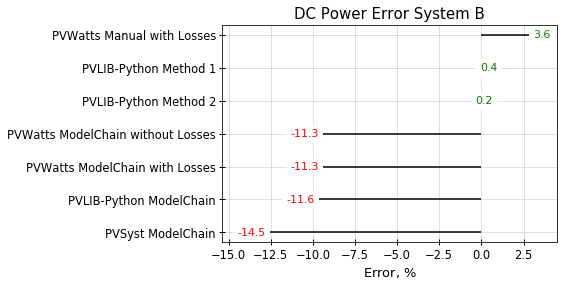

In [121]:
#DC Power Percentage Error
plt.style.use('fast')

#System A
fig1, ax1 = plt.subplots();

plt.hlines(y=comp_dcpower_SysA.index, xmin=0, xmax=comp_dcpower_SysA['Error DC Power SysA'])

for x, y, tex in zip(comp_dcpower_SysA['Error DC Power SysA'], comp_dcpower_SysA.index, 
                     comp_dcpower_SysA['Error DC Power SysA']):
    t = plt.text(x, y, round(tex, 1), horizontalalignment='left' if x < 0 else 'center', 
                 verticalalignment='center', bbox=dict(facecolor='white', linewidth=0),
                 fontdict={'color':'red' if x < 0 else 'green', 'size':11, 'name':'Helvetica'})

plt.rc('font', family='Helvetica')

plt.yticks(comp_dcpower_SysA.index, comp_dcpower_SysA['Sim. Model'], fontname="Helvetica", fontsize=13)
plt.title('DC Power Error System A', fontname="Helvetica", fontsize=15);
plt.xlabel('Error, $\%$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5, labelsize=11.5)

plt.rcParams['axes.axisbelow'] = True;
plt.grid(True, zorder = 0);
plt.tight_layout;
plt.savefig('3_Error_DCPower_SysA.eps', bbox_inches='tight')

#System B
fig2, ax2 = plt.subplots();

plt.hlines(y=comp_dcpower_SysB.index, xmin=0, xmax=comp_dcpower_SysB['Error DC Power SysB'])

for x, y, tex in zip(comp_dcpower_SysB['Error DC Power SysB'], comp_dcpower_SysB.index, 
                     comp_dcpower_SysB['Error DC Power SysB']):
    t = plt.text(x, y, round(tex, 1), horizontalalignment='left' if x < 0 else 'center', 
                 verticalalignment='center', bbox=dict(facecolor='white', linewidth=0),
                 fontdict={'color':'red' if x < 0 else 'green', 'size':11, 'name':'Helvetica'})

plt.rc('font', family='Helvetica')

plt.yticks(comp_dcpower_SysB.index, comp_dcpower_SysB['Sim. Model'], fontname="Helvetica", fontsize=13)
plt.title('DC Power Error System B', fontname="Helvetica", fontsize=15);
plt.xlabel('Error, $\%$', fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5, labelsize=11.5)

plt.rcParams['axes.axisbelow'] = True;
plt.grid(True, zorder = 0);
plt.tight_layout;
plt.savefig('3_Error_DCPower_SysB.eps', bbox_inches='tight')

___
Another *Error Plot* design:

```python
#DC Power Percentage Error
plt.style.use('fast')

z = comp_dcpower_SysA['Error DC Power SysA'].values
df = []
for a in z:
    if a < 0:
        df.append('red')
    else:
        df.append('green')

plt.hlines(y=comp_dcpower_SysA.index, xmin=0, xmax=comp_dcpower_SysA['Error DC Power SysA'], 
           color=df, alpha=0.65, linewidth=5)

plt.rc('font', family='Helvetica')

plt.yticks(comp_dcpower_SysA.index, comp_dcpower_SysA['Sim. Model'], fontname="Helvetica", fontsize=11.5)
plt.title('DC Power Error', fontname="Helvetica", fontsize=15);
plt.xlabel('Error, $\%$', fontname="Helvetica", fontsize=11.5);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5, labelsize=11.5)

plt.rcParams['axes.axisbelow'] = True;
plt.grid(True, zorder = 0);
plt.tight_layout;
```
___

##### 8.3.6. AC Power Percentage Error

In [122]:
#System A
comp_acpower_SysA = []

#PVLIB-Python Method 1
error_acpower = ((av_max_mea_acpower_SysA - av_Pot_AC_SysA_method_1)
                     /av_max_mea_acpower_SysA)*100;

comp_acpower_SysA.append(error_acpower)

#PVLIB-Python Method 2
error_acpower = ((av_max_mea_acpower_SysA - av_Pot_AC_SysA_method_2)
                     /av_max_mea_acpower_SysA)*100;

comp_acpower_SysA.append(error_acpower)

#PVLIB-Python ModelChain
error_acpower = ((av_max_mea_acpower_SysA - av_pvlib_max_mc_ACpmp_SysA)
                     /av_max_mea_acpower_SysA)*100;

comp_acpower_SysA.append(error_acpower)

#PVSyst ModelChain
error_acpower = ((av_max_mea_acpower_SysA - av_pvsyst_max_mc_ACpmp_SysA)
                     /av_max_mea_acpower_SysA)*100;

comp_acpower_SysA.append(error_acpower)

#PVWatts Manual with Losses
error_acpower = ((av_max_mea_acpower_SysA - av_pvwatts_max_ACpmp_SysA)
                     /av_max_mea_acpower_SysA)*100;

comp_acpower_SysA.append(error_dcpower)

#PVWatts ModelChain with Losses
error_acpower = ((av_max_mea_acpower_SysA - av_pvwatts_max_mc_losses_ACpmp_SysA)
                     /av_max_mea_acpower_SysA)*100;

comp_acpower_SysA.append(error_acpower)

#PVWatts ModelChain without Losses
error_acpower = ((av_max_mea_acpower_SysA - av_pvwatts_max_mc_ACpmp_SysA)
                     /av_max_mea_acpower_SysA)*100;

comp_acpower_SysA.append(error_acpower)

comp_acpower_SysA = pd.DataFrame(comp_acpower_SysA, columns=['Error AC Power SysA'])
comp_acpower_SysA['Sim. Model'] = comp_index
comp_acpower_SysA.sort_values('Error AC Power SysA', inplace=True)
comp_acpower_SysA.reset_index(inplace=True)

#System B
comp_acpower_SysB = []

#PVLIB-Python Method 1
error_acpower = ((av_max_mea_acpower_SysB - av_Pot_AC_SysB_method_1)
                     /av_max_mea_acpower_SysB)*100;

comp_acpower_SysB.append(error_acpower)

#PVLIB-Python Method 2
error_acpower = ((av_max_mea_acpower_SysB - av_Pot_AC_SysB_method_2)
                     /av_max_mea_acpower_SysB)*100;

comp_acpower_SysB.append(error_acpower)

#PVLIB-Python ModelChain
error_acpower = ((av_max_mea_acpower_SysB - av_pvlib_max_mc_ACpmp_SysB)
                     /av_max_mea_acpower_SysB)*100;

comp_acpower_SysB.append(error_acpower)

#PVSyst ModelChain
error_acpower = ((av_max_mea_acpower_SysB - av_pvsyst_max_mc_ACpmp_SysB)
                     /av_max_mea_acpower_SysB)*100;

comp_acpower_SysB.append(error_acpower)

#PVWatts Manual with Losses
error_acpower = ((av_max_mea_acpower_SysB - av_pvwatts_max_ACpmp_SysB)
                     /av_max_mea_acpower_SysB)*100;

comp_acpower_SysB.append(error_acpower)

#PVWatts ModelChain with Losses
error_acpower = ((av_max_mea_acpower_SysB - av_pvwatts_max_mc_losses_ACpmp_SysB)
                     /av_max_mea_acpower_SysB)*100;

comp_acpower_SysB.append(error_acpower)

#PVWatts ModelChain without Losses
error_acpower = ((av_max_mea_acpower_SysB - av_pvwatts_max_mc_ACpmp_SysB)
                     /av_max_mea_acpower_SysB)*100;

comp_acpower_SysB.append(error_acpower)

comp_acpower_SysB = pd.DataFrame(comp_acpower_SysB, columns=['Error AC Power SysB'])
comp_acpower_SysB['Sim. Model'] = comp_index
comp_acpower_SysB.sort_values('Error AC Power SysB', inplace=True)
comp_acpower_SysB.reset_index(inplace=True)

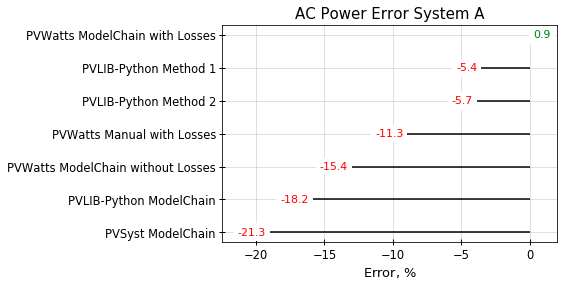

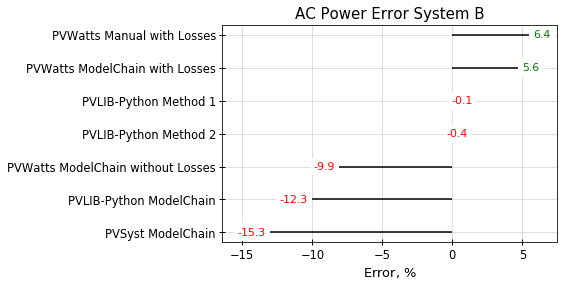

In [123]:
#AC Power Percentage Error
plt.style.use('fast')

#System A
fig1, ax1 = plt.subplots();
plt.hlines(y=comp_acpower_SysA.index, xmin=0, xmax=comp_acpower_SysA['Error AC Power SysA'])

for x, y, tex in zip(comp_acpower_SysA['Error AC Power SysA'], comp_acpower_SysA.index, 
                     comp_acpower_SysA['Error AC Power SysA']):
    t = plt.text(x, y, round(tex, 1), horizontalalignment='left' if x < 0 else 'center', 
                 verticalalignment='center', bbox=dict(facecolor='white', linewidth=0),
                 fontdict={'color':'red' if x < 0 else 'green', 'size':11, 'name':'Helvetica'})

plt.rc('font', family='Helvetica')

plt.yticks(comp_acpower_SysA.index, comp_acpower_SysA['Sim. Model'], fontname="Helvetica", fontsize=13)
plt.title('AC Power Error System A', fontname="Helvetica", fontsize=15);
plt.xlabel('Error, $\%$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5, labelsize=11.5)

plt.rcParams['axes.axisbelow'] = True;
plt.grid(True, zorder = 0);
plt.tight_layout;
plt.savefig('3_Error_ACPower_SysA.eps', bbox_inches='tight')

#System B
fig2, ax2 = plt.subplots();
plt.hlines(y=comp_acpower_SysB.index, xmin=0, xmax=comp_acpower_SysB['Error AC Power SysB'])

for x, y, tex in zip(comp_acpower_SysB['Error AC Power SysB'], comp_acpower_SysB.index, 
                     comp_acpower_SysB['Error AC Power SysB']):
    t = plt.text(x, y, round(tex, 1), horizontalalignment='left' if x < 0 else 'center', 
                 verticalalignment='center', bbox=dict(facecolor='white', linewidth=0),
                 fontdict={'color':'red' if x < 0 else 'green', 'size':11, 'name':'Helvetica'})

plt.rc('font', family='Helvetica')

plt.yticks(comp_acpower_SysB.index, comp_acpower_SysB['Sim. Model'], fontname="Helvetica", fontsize=13)
plt.title('AC Power Error System B', fontname="Helvetica", fontsize=15);
plt.xlabel('Error, $\%$', fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5, labelsize=11.5)

plt.rcParams['axes.axisbelow'] = True;
plt.grid(True, zorder = 0);
plt.tight_layout;
plt.savefig('3_Error_ACPower_SysB.eps', bbox_inches='tight')

##### 8.3.7. Daily Energy Percentage Error
As mentioned in Section 6.7., it was easier to get the daily energy production by applying the Method 2 rather than the Method 1 because the first one retrieve a 'continuous' data of daily energy during each day (and not only the maximum value as stated with Method 1). Due to this reason, **the PVLIB-Python Method 1 data for daily energy is not plotted**.

___
**Note:** The DataFrame variable (for x-label index) ```comp_index``` is created again without the PVLIB-Python Method 1 label.
___

In [124]:
comp_index = []
comp_index = ['PVLIB-Python Method 2', 'PVLIB-Python ModelChain', 'PVSyst ModelChain',
             'PVWatts Manual with Losses', 'PVWatts ModelChain with Losses', 'PVWatts ModelChain without Losses']
comp_index = pd.DataFrame(comp_index)

In [125]:
#System A
comp_energy_SysA = []

#PVLIB-Python Method 2
error_energy = ((av_max_mea_energy_SysA - av_daily_energy_SysA)
                     /av_max_mea_energy_SysA)*100;

comp_energy_SysA.append(error_energy)

#PVLIB-Python ModelChain
error_energy = ((av_max_mea_energy_SysA - av_pvlib_daily_energy_SysA)
                     /av_max_mea_energy_SysA)*100;

comp_energy_SysA.append(error_energy)

#PVSyst ModelChain
error_energy = ((av_max_mea_energy_SysA - av_pvsyst_daily_energy_SysA)
                     /av_max_mea_energy_SysA)*100;

comp_energy_SysA.append(error_energy)

#PVWatts Manual with Losses
error_energy = ((av_max_mea_energy_SysA - av_pwmle_daily_energy_SysA)
                     /av_max_mea_energy_SysA)*100;

comp_energy_SysA.append(error_energy)

#PVWatts ModelChain with Losses
error_energy = ((av_max_mea_energy_SysA - av_pwmcle_daily_energy_SysA)
                     /av_max_mea_energy_SysA)*100;

comp_energy_SysA.append(error_energy)

#PVWatts ModelChain without Losses
error_energy = ((av_max_mea_energy_SysA - av_pwmc_daily_energy_SysA)
                     /av_max_mea_energy_SysA)*100;

comp_energy_SysA.append(error_energy)

comp_energy_SysA = pd.DataFrame(comp_energy_SysA, columns=['Error Energy SysA'])
comp_energy_SysA['Sim. Model'] = comp_index
comp_energy_SysA.sort_values('Error Energy SysA', inplace=True)
comp_energy_SysA.reset_index(inplace=True)

#System B
comp_energy_SysB = []

#PVLIB-Python Method 2
error_energy = ((av_max_mea_energy_SysB - av_daily_energy_SysB)
                     /av_max_mea_energy_SysB)*100;

comp_energy_SysB.append(error_energy)

#PVLIB-Python ModelChain
error_energy = ((av_max_mea_energy_SysB - av_pvlib_daily_energy_SysB)
                     /av_max_mea_energy_SysB)*100;

comp_energy_SysB.append(error_energy)

#PVSyst ModelChain
error_energy = ((av_max_mea_energy_SysB - av_pvsyst_daily_energy_SysB)
                     /av_max_mea_energy_SysB)*100;

comp_energy_SysB.append(error_energy)

#PVWatts Manual with Losses
error_energy = ((av_max_mea_energy_SysB - av_pwmle_daily_energy_SysB)
                     /av_max_mea_energy_SysB)*100;

comp_energy_SysB.append(error_energy)

#PVWatts ModelChain with Losses
error_energy = ((av_max_mea_energy_SysB - av_pwmcle_daily_energy_SysB)
                     /av_max_mea_energy_SysB)*100;

comp_energy_SysB.append(error_energy)

#PVWatts ModelChain without Losses
error_energy = ((av_max_mea_energy_SysB - av_pwmc_daily_energy_SysB)
                     /av_max_mea_energy_SysB)*100;

comp_energy_SysB.append(error_energy)

comp_energy_SysB = pd.DataFrame(comp_energy_SysB, columns=['Error Energy SysB'])
comp_energy_SysB['Sim. Model'] = comp_index
comp_energy_SysB.sort_values('Error Energy SysB', inplace=True)
comp_energy_SysB.reset_index(inplace=True)

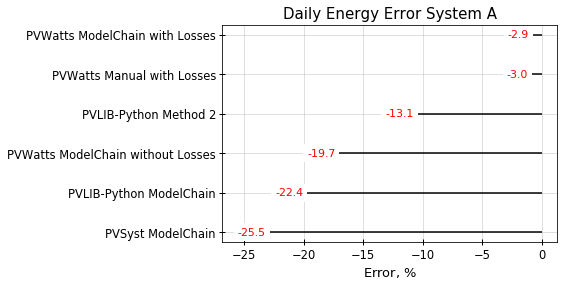

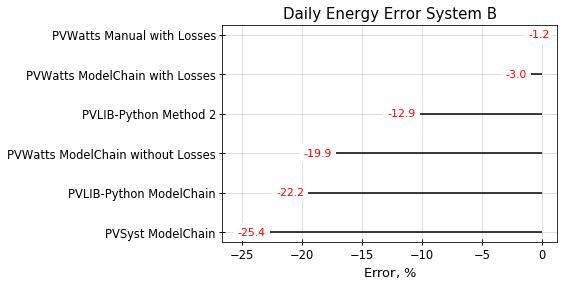

In [126]:
#Daily Energy Percentage Error
plt.style.use('fast')

#System A
fig1, ax1 = plt.subplots();
plt.hlines(y=comp_energy_SysA.index, xmin=0, xmax=comp_energy_SysA['Error Energy SysA'])

for x, y, tex in zip(comp_energy_SysA['Error Energy SysA'], comp_energy_SysA.index, 
                     comp_energy_SysA['Error Energy SysA']):
    t = plt.text(x, y, round(tex, 1), horizontalalignment='left' if x < 0 else 'center', 
                 verticalalignment='center', bbox=dict(facecolor='white', linewidth=0),
                 fontdict={'color':'red' if x < 0 else 'green', 'size':11, 'name':'Helvetica'})

plt.rc('font', family='Helvetica')

plt.yticks(comp_energy_SysA.index, comp_energy_SysA['Sim. Model'], fontname="Helvetica", fontsize=13)
plt.title('Daily Energy Error System A', fontname="Helvetica", fontsize=15);
plt.xlabel('Error, $\%$', fontname="Helvetica", fontsize=13);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5, labelsize=11.5)

plt.rcParams['axes.axisbelow'] = True;
plt.grid(True, zorder = 0);
plt.tight_layout;
plt.savefig('3_Error_Energy_SysA.eps', bbox_inches='tight')

#System B
fig2, ax2 = plt.subplots();
plt.hlines(y=comp_energy_SysB.index, xmin=0, xmax=comp_energy_SysB['Error Energy SysB'])

for x, y, tex in zip(comp_energy_SysB['Error Energy SysB'], comp_energy_SysB.index, 
                     comp_energy_SysB['Error Energy SysB']):
    t = plt.text(x, y, round(tex, 1), horizontalalignment='left' if x < 0 else 'center', 
                 verticalalignment='center', bbox=dict(facecolor='white', linewidth=0),
                 fontdict={'color':'red' if x < 0 else 'green', 'size':11, 'name':'Helvetica'})

plt.rc('font', family='Helvetica')

plt.yticks(comp_energy_SysB.index, comp_energy_SysB['Sim. Model'], fontname="Helvetica", fontsize=13)
plt.title('Daily Energy Error System B', fontname="Helvetica", fontsize=15);
plt.xlabel('Error, $\%$', fontname="Helvetica", fontsize=13);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5, labelsize=11.5)

plt.rcParams['axes.axisbelow'] = True;
plt.grid(True, zorder = 0);
plt.tight_layout;
plt.savefig('3_Error_Energy_SysB.eps', bbox_inches='tight')

___
## SECTION 9: CONCLUSIONS

### 9.1. PVLIB-Python MODELING CONCLUSIONS
A complete PVLIB-Python simulation analysis for Los Andes University Photovoltaic System was performed. All the [Sandia' PVPMV SAND2017-10067C](https://www.osti.gov/servlets/purl/1474242) modeling methods and practices were taken into account in order to increase precision of simulated results and, therefore, increase reliability in comparison with the real photovoltaic system.

The simulation was develop in six (6) sections in order to accomplish the Section 1-2 from Joshua Stein' Report Outline SAND2017-10067C and to increase reliability by truly studying each variable taken into account for the simulation analysis. The two remain sections were analyzed in order to comprehend the behaviour of ModelChain class and another two main simulation models as PVSyst and NREL' PVWatts; those sections are concluded at sub-section 9.2.

The first six sections studied can be arranged into three main groups:

- Weather Forecast Data and Models (Sections 1 to 3).

- Derivation of Effective Meteorological Components (Section 4).

- Photovoltaic System Modeling and Outputs (Section 5 to 6).

##### 9.1.1. Weather Forecast Data and Models
As explained at sub-section 3.1., the selected weather model was GFS (0.5º accuracy). The advange of the GFS weather database is that it contains 3 hour resolution of the meteorological data at any country in the world. Despite being a model based on prediction and forecast, undoubtedly, to studied dates close to the current day (or the day in which the author performed the analysis), the precision is adequate but it degrades as that 'time window 'studied moves away from the current day.

In natural subjects, it is incontestable that environmental peaks occur that disturb the precision of the simulation. However, as presented in sub-section 8.1.3., The results are very close to the real thing. There is no doubt that the better the hourly resolution of the meteorological data, the higher the accuracy of the reports.

##### 9.1.2. Derivation of Effective Meteorological Components
It is relevant to obtain the calculation of the effective irradiance that 'hits' the installed photovoltaic array. PVLIB-Python offers a lot of methods and functions to do this. All available options were studied and this led to a broad understanding of the models, in addition to a favorable selection that led to a correct calculation of the effective irradiance.

As presented in sub-section 8.1.3, it is worth highlighting the reliability that PVLIB-Python offers since the simulation has a behavior very close to the real one. In addition, it should be noted that the actual meteorological measurement was carried out with a Meteocontrol' data acquisition system  arranged in a reference cell, a company that carries out the study of monitoring and follow-up of the Los Andes Photovoltaic System.

##### 9.1.3. Photovoltaic System Modeling and Outputs
The system modeling is also a great-attention-to-detail job as this ensures the adequate scalability of voltage and current (and, therefore, power and energy) of the photovoltaic system. As shown in sub-section 8.1., simulation model reports maintain close proximity to the actual behavior of the analyzed variables, which strengthens the precision and reliability of Sandia' PVLIB-Python.

In general, the author confirms the power of Sandia' PVLIB-Python as the accuracy that it manages in its simulation models was validated. In addition, it is very useful that it is *open-source* since in this way the many authors are free to work on the source code, as presented in this Jupyter Notebook.


### 9.2. ALL SIMULATION MODELS CONCLUSIONS
The main available and accessible simulation models were validated, such as PVLIB-Python, PVSyst and PVWatts. Validation was performed comparing the proximity between the results of all the simulation models proposed (manual and ModelChain) and also for the accuracy against the actual value reported by Meteocontrol 'data acquisition system.

As shown in sub-section 8.2., the maximum discrepancy of the data found was approximately 20%. This indicates that, in 'critical' cases, the tendency is to maintain adequate and close behavior with each other.

**Note:** It is important to take into account that this 20% 'critical' discrepancy is due to the fact that system losses models were introduced into the system in some simulation models; specifically in the PVWatts simulation model to maintain consistency with its employability. The system losses are different from meteorological losses.

Finally, as shown in sub-section 8.3., the maximum error between the simulation models and actual performance data of Los Andes Photovoltaic System is 25.5% (*PVLIB-Python ModelChain Daily Energy Error System A*). This indicator maintains consistency with previous comments.

___

By Nelson Andrés Salazar Peña (na.salazar10@uniandes.edu.co).

Reviewed by Andrés Leonardo González Mancera, Ph.D. (angonzal@uniandes.edu.co).
___